# IMPORT

In this notebook I did not normalized images before evolving, just when predicting

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import pickle
import time
from skimage.measure import compare_ssim
import tensorflow as tf
from keras.models import Model,load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.utils import to_categorical
import keras

Using TensorFlow backend.


In [2]:
np.random.seed(0)

# GLOBAL VARS

In [3]:
INDIVIDUALS = 50
P_CROSS = 0.6
P_MUTATION = 0.01
CIFAR_IMG= 32

# THE DATA

In [4]:
from keras.datasets import cifar10

# The data, split between train and test sets:
(x_train_C, y_train_C), (x_test_C, y_test_C) = cifar10.load_data()
print('x_train shape:', x_train_C.shape)
print(x_train_C.shape[0], 'train samples')
print(x_test_C.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
num_classes=10
epochs=10
img_shape=32 
y_train_C = to_categorical(y_train_C, num_classes)
y_test_C = to_categorical(y_test_C, num_classes)


input_shape=(32,32,1)

x_train_C = x_train_C.astype('float32')
x_test_C = x_test_C.astype('float32')
x_train_C /= 255
x_test_C /= 255


print('x_train shape:', x_train_C.shape)
print('Number of images in x_train', x_train_C.shape[0])
print('Number of images in x_test', x_test_C.shape[0])
print('y_train shape:', y_train_C.shape)
print("input shape: ",input_shape)


# CONVERT TO GRAY SCALE

import matplotlib.pyplot as plt
import numpy as np

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

x_train_C = grayscale(x_train_C)
x_test_C = grayscale(x_test_C)

# now we have only one channel in the images
img_channels = 1



FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Lora\\.keras\\datasets\\cifar-10-batches-py\\data_batch_1'

# READ PICKLE FILES

In [4]:
with open('subset_cifar', 'rb') as f:
    original = pickle.load(f)
    adversarial= pickle.load(f)
    original_y = pickle.load(f)
    adversarial_y = pickle.load(f)

In [5]:
print(f"Original shape {original.shape}")
print(f"Adversarial shape {adversarial.shape}")
print(f"Original labels shape {original_y.shape}")
print(f"Adversarial labels shape {adversarial_y.shape}")

Original shape (914, 32, 32, 1)
Adversarial shape (133, 32, 32, 1)
Original labels shape (914, 1)
Adversarial labels shape (133, 1)


# LOAD THE MODEL

3. CNN v2

This network is made for CIFAR 10. The network is taken from [this blog]( https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/) . In this version below I didn't use some things used in the blog e.g. z-score and data augmentation.


This network has training accuracy: 0.8940 , validation accuracy: 0.8245.

**NOTE:** Training really slow, try to avoid it.

In [6]:
# Network 3 
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

input_shape = (CIFAR_IMG,CIFAR_IMG,1)
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
 
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


'''
history = model.fit(x=x_train_C,y=y_train_C, epochs=150, batch_size=64, validation_data=[x_test_C,y_test_C])

score= model.evaluate(x_test_C, y_test_C,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save_weights("CNN_CIFAR10_net3.h5")
files.download('CNN_CIFAR10_net3.h5')
'''

model = load_model("CNN_CIFAR10_net3.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

# GENETIC ALGORITHM FUNCTIONS

In [7]:

def computing_SSIM(individual,target):
    return compare_ssim(individual.reshape(CIFAR_IMG,CIFAR_IMG), target.reshape(CIFAR_IMG,CIFAR_IMG))

def calculate_fitness(model,ind,target_image,label,l1=0.2, l2=0.8, N=50, num_classes=10):
  # predict the population
  predictions=model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1) / 255.0)  
  # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
  predictions=predictions[0]
  po=predictions[label]
  # set that value to 0
  predictions[label]=0
  # take next highest one
  pd = np.max(predictions)
  diff=pd-po
  return l1*computing_SSIM(ind.reshape(CIFAR_IMG,CIFAR_IMG),target_image.reshape(CIFAR_IMG,CIFAR_IMG)) +l2*(diff)
  


def pop_fitness(model,pop,target,label):
    return [calculate_fitness(model, p, target, label) for p in pop]

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, 10)

def p_noise(x):
  if 0.01 > np.random.uniform():
    return x + gaussian_noise()
  else:
    return x
    
def add_noise(image):
    noise_v=np.vectorize(p_noise)
    return noise_v(image) #np.array([x + gaussian_noise() if P_MUTATION > np.random.uniform(0.0, 1.0) else x+0 for x in image])

def k_crossover(im1, im2, k=1):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, CIFAR_IMG*CIFAR_IMG-1, 1) for p in range(k)])
    points = sorted([np.random.randint(0,CIFAR_IMG*CIFAR_IMG-1,1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, model, ground_truth, target, k=3):

    indices = np.random.choice(range(len(pop)), k, replace=False) #we get 3 indxes [2 34 46]    
    individuals = pop.take(indices,axis=0)
    scores = pop_fitness(model,np.expand_dims(individuals.reshape(individuals.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3), ground_truth.reshape(CIFAR_IMG,CIFAR_IMG), target)
    index_max = np.argmax(scores)
    winner = individuals[index_max]
    return winner


def check_adv_termination(ind, label,ground_truth, model):
  # individual - the best one from the generation
  # label - class we want
  # ground_truth - the image (32,32)
  # model we are using 
  dist = 1-compare_ssim(ind.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG))
  predictions= model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0)
  predicted_label= np.argmax(predictions[0])
  if label != predicted_label and dist < 0.001:
    print("FOUND ADVERSARIAL")
    print(f"Fitness of the adversarial {calculate_fitness(model,ind,ground_truth,label)}")
    return ind
  return []

def init_pop_from_sample(n,img,label):
    x = np.array([add_noise(img) for i in range(n)])
    return x.reshape(n, CIFAR_IMG*CIFAR_IMG)



Functions from the past, just didn't want to erase them yet

In [9]:
'''
def check_adverserial(pop, model, fitness, target,ground_truth):
    #print(f"this is adversarial function")
    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))
    #print(f"These are predictions made here {preds}")
    for ind, pr in zip(pop,preds): 
      #print(f"prediction for an individual {pr}")
      preds=np.argmax(pr)
      #print(f"getting the index of highest value in predictions {preds}")
      #setting the value to 0
      pr[0]=0
      #print(f"this is our target {target}")
      #print(f"this is out ground_truth {ground_truth.shape}")
      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))
      #print(f"these are the fitness values {fitness}")
      next_highest = np.argmax(pr)
      #print(f"getting the next highest value {next_highest}")
      if next_highest != target and fitness > 0.98:
          return ind, True
      return None, False

def init_pop(n, num, data, labels):
    indices = np.where(labels==num)[0]
    n_indices = np.random.choice(indices, n, replace=True)
    sample = np.take(data, n_indices, axis=0)
    return sample, np.full((n), num, dtype=int) # return sample+array of labels


Cyrils model

def save_trained_model(model, filename='SVC_model.sav'):
    pickle.dump(model, open(filename, 'wb'))
    
def load_trained_model(filename='SVC_model.sav'):
    return pickle.load(open(filename, 'rb'))

'''

'\ndef check_adverserial(pop, model, fitness, target,ground_truth):\n    #print(f"this is adversarial function")\n    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))\n    #print(f"These are predictions made here {preds}")\n    for ind, pr in zip(pop,preds): \n      #print(f"prediction for an individual {pr}")\n      preds=np.argmax(pr)\n      #print(f"getting the index of highest value in predictions {preds}")\n      #setting the value to 0\n      pr[0]=0\n      #print(f"this is our target {target}")\n      #print(f"this is out ground_truth {ground_truth.shape}")\n      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))\n      #print(f"these are the fitness values {fitness}")\n      next_highest = np.argmax(pr)\n      #print(f"getting the next highest value {next_highest}")\n      if next_highest != target and fitness > 0.98:\n          return ind, True\n      return None, False\n\ndef init_pop(n, num, data, labels):\n    indices = np.where(labels==num)[0]\n 

In [8]:
''' my part of the code ''' 
''' I know it is ugly, I will fix it . this is the intial version'''
# from Goorge Clooney paper
def quadrant_crossover(parent_1,parent_2):

  # reshape parents
  parent_1,parent_2= parent_1.reshape((CIFAR_IMG,CIFAR_IMG)), parent_2.reshape((CIFAR_IMG,CIFAR_IMG))
  # quadrants for both parents
  p1,p2,p3,p4,q1,q2,q3,q4 = [],[],[],[],[],[],[],[]
  child1, child2 = [],[]
  # getting random (x,y) point in 2D matrix
  x,y = np.random.randint(0,CIFAR_IMG-1), np.random.randint(0,CIFAR_IMG-1)  

  # choose which quadrant we want to crossover
  N = np.random.randint(0,3)
  #make quadrants
  for i in range(CIFAR_IMG):
    if (i<=x):
      p1.append(parent_1[i][:y+1])
      p2.append(parent_1[i][y+1:])
      q1.append(parent_2[i][:y+1])
      q2.append(parent_2[i][y+1:])
    else:
      p3.append(parent_1[i][:y+1])
      p4.append(parent_1[i][y+1:])
      q3.append(parent_2[i][:y+1])
      q4.append(parent_2[i][y+1:])

  if (N==0):
    ch1 = connect_quadrants(p1,q2,q3,q4)
    ch2 = connect_quadrants(q1,p2,p3,p4)
  elif (N==1):
    ch1 = connect_quadrants(q1,p2,q3,q4)
    ch2 = connect_quadrants(p1,q2,p3,p4)
  elif (N==2):
    ch1 = connect_quadrants(q1,q2,p3,q4)
    ch2 = connect_quadrants(p1,p2,q3,p4)
  else:
    ch1 = connect_quadrants(q1,q2,q3,p4)
    ch2 = connect_quadrants(p1,p2,p3,q4)

  return ch1,ch2

def connect_quadrants(q1,q2,q3,q4):
  left = np.concatenate((q1,q3))
  right = np.concatenate((q2,q4))
  image = np.concatenate((left,right),axis=1)
  return image.flatten()


def multi_crossover(parent1,parent2,target):
  pop= []
  # 2-k crossover
  pop.append(k_crossover(parent1, parent2))
  # Gorge Clooney crossover
  pop.append(quadrant_crossover(parent1,parent2))
  # uniform crossover
  pop.append(k_crossover(parent1, parent2,1))
  # SSIM similarity 
  flattened_list = [y for x in pop for y in x] # need to flatten the list because pop is list of lists, cause every crossover function returns 2 obj
  ssim = [computing_SSIM(ind,target) for ind in flattened_list ]
  # taking the index of largest two score
  id1=np.argmax(ssim)
  ssim[id1]=0
  id2 = np.argmax(ssim)
  #returning parents
  return flattened_list[id1],flattened_list[id2]
  


In [9]:
def return_best_individual(pop,fitness):
  index = np.argmax(fitness)
  best = pop[index]
  return best, np.max(fitness)

In [10]:
def choose_better_child(ch1, ch2,ground_truth,label,model):
  # I named it better child, but we choose by this parents as well
  ch1_f = calculate_fitness(model,ch1.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  ch2_f = calculate_fitness(model,ch2.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  # change this into ternary operator
  if ch1_f>ch2_f:
    return ch1
  else:
    return ch2              


# THE MAIN LOOP

In [0]:
'''
This not necessary when using subset 
'''
'''
X = flatten(x_train)
X_t = flatten(x_test)
print(f"X train shape {X.shape}")
print(f"X test shape {X_t.shape}")
print(f"y train shape {y.shape}")
print(f"y test shape {y_t.shape}")
'''

'\nX = flatten(x_train)\nX_t = flatten(x_test)\nprint(f"X train shape {X.shape}")\nprint(f"X test shape {X_t.shape}")\nprint(f"y train shape {y.shape}")\nprint(f"y test shape {y_t.shape}")\n'

Initial fitness: 
 [-0.6003743197968582, -0.6012464092882421, -0.6019087320246557, -0.6014880197951772, -0.6022836148095521, -0.6005888507054344, -0.6011141911803378, -0.6006199347239177, -0.6024622861388831, -0.6006025092861443, -0.601838997838289, -0.6018174764350027, -0.6013234496572247, -0.6006019042140215, -0.5999523317169378, -0.6002859145884996, -0.6013769320549351, -0.6023342732597164, -0.6028743711739928, -0.6006267923136724, -0.6006465127265974, -0.6028326187758263, -0.6002066879991809, -0.6002987692340014, -0.6009014088932532, -0.6013053149923098, -0.600691811030488, -0.6014717255143034, -0.6002385191190581, -0.6046284579990849, -0.6013145129157351, -0.6014545502478296, -0.6005576411811194, -0.601324872687319, -0.6006042460735911, -0.6020674037859883, -0.6004529333429227, -0.6028085351237225, -0.6003050958096371, -0.6002419404270258, -0.6012601326004444, -0.6008832743961511, -0.6003449169657735, -0.6022335928817804, -0.6003703453762899, -0.6009268965988709, -0.60210953452151

C:\Users\Lora\Anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


Generation 10
Max fitness value -0.5652045811109089
Generation 20
Max fitness value 0.9463997185838299
Generation 30
Max fitness value 0.9736751835194931
Generation 40
Max fitness value 0.9736904389218513
Generation 50
Max fitness value 0.9736904389218513
Generation 60
Max fitness value 0.9738367183576394
Generation 70
Max fitness value 0.9738367183576394
Generation 80
Max fitness value 0.9743848277376115
Generation 90
Max fitness value 0.9743848277376115
Generation 100
Max fitness value 0.9743848277376115
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


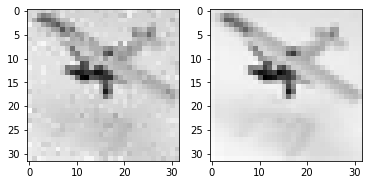

True label: 0
predicted label: 4
Time:  184.66985726356506  seconds
Initial fitness: 
 [-0.5647454811746466, -0.51335339419884, -0.5176256396184207, -0.4728934294938224, -0.5761500352903669, -0.5608477880772119, -0.5037563886012961, -0.5097876723285402, -0.377437972429287, -0.4745472333954934, -0.4503754024788046, -0.5244950638166006, -0.4915508447468713, -0.509158503476504, -0.49371389873977445, -0.49020216458745774, -0.5018221725181606, -0.44555651103450444, -0.49052919025713654, -0.5409480612332946, -0.4944271665036307, -0.496174861549846, -0.4814057869442493, -0.5197032273685608, -0.4507312584147095, -0.4540969149940649, -0.4942127703602354, -0.4728808505105969, -0.5348946360070734, -0.5027935803894585, -0.4976034605377333, -0.530954518688033, -0.4755776444837671, -0.5426232091802929, -0.5881769382624152, -0.4914732596909006, -0.43457055903525876, -0.47107351288055044, -0.48850492621672803, -0.4855467550950924, -0.49433727945409656, -0.5129669255624565, -0.5011331012785913, -0.4787

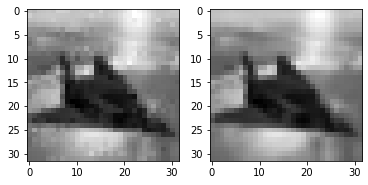

True label: 0
predicted label: 8
Time:  96.96999740600586  seconds
Initial fitness: 
 [-0.4421195247775225, -0.4177810800916012, -0.39651519705087784, -0.35566975997223205, -0.3369256004595441, -0.31502024989137367, -0.3034500899736089, -0.43332089086107917, -0.2004424770504446, -0.34466633156530524, -0.3108003776689402, -0.352897691772725, -0.24599419878404533, -0.33448428764440497, -0.4193963274923125, -0.3617833064508976, -0.20901632686635066, -0.4054793945486443, -0.30018078598077874, -0.42733613917677515, -0.4065414119413193, -0.4089963089041101, -0.15634911543867763, -0.12789300020144367, -0.25696494585982066, -0.13701503565309164, -0.3257892034595965, -0.26841887018742994, -0.32959216054350005, -0.3839470754058526, -0.09949290994136653, -0.41992307227597986, -0.34190090538573154, -0.4001029629990601, -0.24708218370315874, -0.37185426200006905, -0.228472383086611, -0.2395916302769195, -0.3422898910545078, -0.3901238175592301, -0.31151026041624474, -0.32338585886590154, 0.01375122

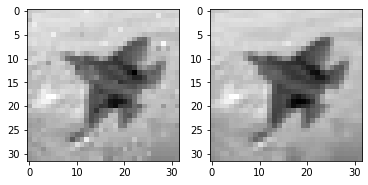

True label: 0
predicted label: 2
Time:  82.88725161552429  seconds
Initial fitness: 
 [-0.5954831704931414, -0.5905392652235264, -0.5949134009384575, -0.590291021847367, -0.592255780630819, -0.5942015607428747, -0.5896024845159176, -0.5929778947185063, -0.5939156700075405, -0.5944444189415157, -0.5936337466342685, -0.5914194350781576, -0.592097881854757, -0.5969236298097795, -0.5895017814755579, -0.5917974649244296, -0.5932650430365948, -0.5959213860757698, -0.5946172583942444, -0.5940180275550493, -0.594481410813971, -0.5923386277982537, -0.5946308241056855, -0.5931481704853349, -0.5940476818226207, -0.5964006565137798, -0.5921195020036629, -0.5940282096878169, -0.5956622669509365, -0.5945700647671137, -0.593145553236785, -0.5936321106921165, -0.5929542676280538, -0.5932936448639624, -0.5932003719470498, -0.5970939723981934, -0.5937801797461598, -0.5957983342834516, -0.5983295808351571, -0.5945492255878455, -0.5945138735520784, -0.5911809140699728, -0.5953609705044756, -0.594219192975

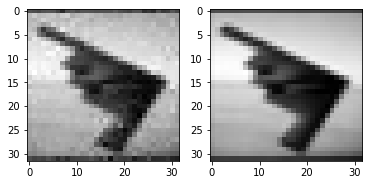

True label: 0
predicted label: 2
Time:  280.1683175563812  seconds
Initial fitness: 
 [-0.539657819284816, -0.5039436303716047, -0.500629143828434, -0.5491007605781276, -0.46933523238688213, -0.5612524038960628, -0.5130362490333881, -0.5420824788479002, -0.5493433429727335, -0.5362636521048316, -0.485206703809715, -0.5054544297034164, -0.4826841823826519, -0.5184597704875923, -0.5351875853145872, -0.5471408301952673, -0.4923082032084373, -0.5221063001075961, -0.5365414944469518, -0.523883599974139, -0.550686839279823, -0.5273784531452984, -0.5471692132451869, -0.5242494697643069, -0.5471820434677218, -0.5258524811937092, -0.5568976316585588, -0.5287534183850784, -0.5917734221449501, -0.5403758843231883, -0.5724470004017719, -0.5412249043947592, -0.4803912630201381, -0.547589767640196, -0.5825244230329195, -0.5597586295724952, -0.5219850875900414, -0.5887587348929275, -0.536048313669975, -0.5466729834848807, -0.5488933578135293, -0.3599948249805056, -0.5528301148591872, -0.5329789512958

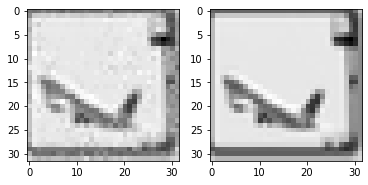

True label: 0
predicted label: 2
Time:  227.2568860054016  seconds
Initial fitness: 
 [-0.6027148844901176, -0.6113534235426193, -0.6000780187456274, -0.6065667081199417, -0.6009482971474908, -0.5986803623513599, -0.5972429714717965, -0.6145988210083296, -0.5894999586451612, -0.5855553669419002, -0.6172036193476842, -0.5991217954304424, -0.5933618251136421, -0.6037508369528201, -0.5980873874535386, -0.6024641858901776, -0.6055396504709251, -0.5962011867536046, -0.5951108363274256, -0.6107467732076194, -0.6017403909722854, -0.5980500839779861, -0.5968708910214973, -0.594706944181272, -0.6018315773103327, -0.6096438619796021, -0.5718112560580293, -0.596845497604426, -0.5926001671593615, -0.613678651381583, -0.5783709020537446, -0.6072000936698441, -0.6003535092897722, -0.608337301420451, -0.6137252245975929, -0.6187892547857146, -0.6066453953424343, -0.6069538690490184, -0.6034235081356631, -0.6002581654762922, -0.6071601335362784, -0.59679027456589, -0.5958368763046238, -0.5946298017834

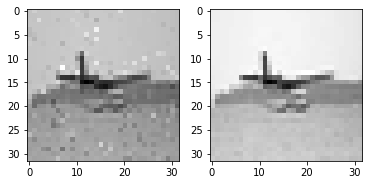

True label: 0
predicted label: 8
Time:  95.48781871795654  seconds
Initial fitness: 
 [-0.6071235263310246, -0.6024436796819111, -0.6061344343562951, -0.6031379601857985, -0.6020361641312081, -0.6040380267905974, -0.6069815494620769, -0.600944258113454, -0.6017991746928736, -0.6043479185463837, -0.6068164223842243, -0.600823699644619, -0.6018042972195721, -0.6050230334510175, -0.6005696728445793, -0.6080805156037541, -0.6043191170189484, -0.6105035872303246, -0.6014290706065881, -0.6022603825283073, -0.6027975734872613, -0.6028334225408022, -0.6030207973932644, -0.6087062679248645, -0.6018450905271523, -0.5999385565151314, -0.6005595783319806, -0.6000150011509643, -0.606279134657056, -0.6049609606816015, -0.6005463109965977, -0.6040611390766535, -0.6012660369681293, -0.6034462279394133, -0.6052945022578531, -0.6003416821481826, -0.6006125712408728, -0.6028175231785283, -0.6002727405482612, -0.6043212880652915, -0.6054253701930833, -0.6000975847419122, -0.6024614428456974, -0.6018916019

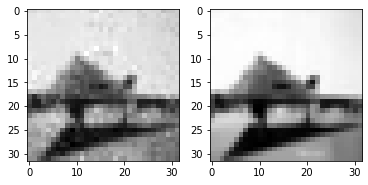

True label: 0
predicted label: 8
Time:  302.80218410491943  seconds
Initial fitness: 
 [-0.5971117946850937, -0.5962556831793558, -0.5938805257472473, -0.5957741181397969, -0.5959662906375918, -0.5961459480554986, -0.5969515934828709, -0.5956373354703395, -0.5944527944616025, -0.5974302764972406, -0.5976260674989962, -0.5955483775418006, -0.5959426644292358, -0.5943073985186784, -0.5942408302312729, -0.5966229504071143, -0.5935125145353131, -0.5962312734938068, -0.5971748261501357, -0.5957071511873933, -0.5940437977948863, -0.5969015173732147, -0.596335282376351, -0.5965042102799485, -0.5953251595968143, -0.5955880302377552, -0.5970884390742093, -0.5958676567962912, -0.5964376986145596, -0.5961691180609513, -0.5959552884459923, -0.5951747170006062, -0.596720621890828, -0.5962538062257186, -0.5963484751215671, -0.5971530056905727, -0.5912709396316788, -0.5965620228078018, -0.5967759002258859, -0.5964532104378841, -0.5937021533440872, -0.5930012399132648, -0.5963866537308118, -0.59696202

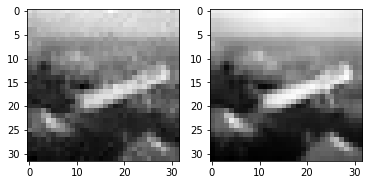

True label: 0
predicted label: 8
Time:  277.34263038635254  seconds
Initial fitness: 
 [-0.5538542242918962, -0.5628754926399763, -0.5758737852960352, -0.5929192269335957, -0.5777396762387785, -0.5790605898224507, -0.5851079453746827, -0.5662938248990976, -0.5716750121155955, -0.5684233707706345, -0.5673860312972617, -0.5798979630091917, -0.5725045248118021, -0.578609951415435, -0.5881446275128815, -0.5883775102144135, -0.5853129791727041, -0.5760102141899671, -0.5843796112278901, -0.5746385634383395, -0.5925468500632658, -0.5658086466790627, -0.5725100087185884, -0.567546312899611, -0.5757403689114178, -0.5711813180103518, -0.574007682429725, -0.5735411892862927, -0.5849698131110854, -0.5787400613179592, -0.5859616864939874, -0.5783664122854361, -0.5699490470873209, -0.5741560602082052, -0.5900396295474944, -0.5766518184843012, -0.5772089440945528, -0.5590699988741659, -0.593702893538647, -0.5899184500315966, -0.5708442975989072, -0.582232905831151, -0.5893361661116595, -0.56942120553

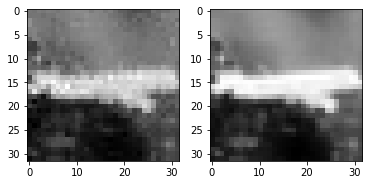

True label: 0
predicted label: 8
Time:  243.43708324432373  seconds
Initial fitness: 
 [-0.07490278603522821, -0.34286561280851074, -0.13523737547807102, -0.15124673049572826, -0.4283160181991843, -0.1792115969949563, -0.15343049475056653, -0.03950911126436302, -0.026657557061232073, 0.029057087309465823, -0.04430566631789998, -0.31688040943807605, -0.09801072459603641, -0.19994413187387147, -0.32817269298382135, -0.34157900418222736, -0.17282907085507185, -0.22295789435947097, -0.07002862801304807, -0.05370307764908505, -0.19318065318986266, -0.46229912890280545, -0.10227324867259843, -0.15750265710433886, -0.08910877656002375, -0.010763483471986468, -0.11586398479167065, -0.2904142001230058, -0.35891458423540157, -0.06627085171311281, -0.10274378882096977, 0.06930238181938722, -0.30001103851908695, -0.20055285910570106, -0.10028173474056276, -0.25724190305459926, -0.12107852309315009, -0.2656101307504745, -0.3024481469824142, -0.06516892558281773, -0.31896759926957274, -0.13677028483

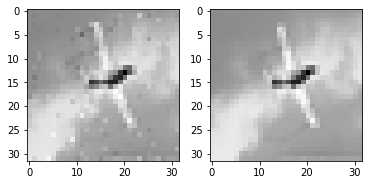

True label: 0
predicted label: 2
Time:  83.04076933860779  seconds
Initial fitness: 
 [-0.542634576129866, -0.5476889376403132, -0.5147351808252527, -0.4841051455517208, -0.4992540871322814, -0.5397365543505914, -0.5439024706795095, -0.5038136845913945, -0.5035579483067429, -0.49747462203651904, -0.4951943357352382, -0.5045398554208009, -0.5113372793035604, -0.44671165654103406, -0.5128585237165021, -0.543627320469558, -0.5178679163391879, -0.48141414596398685, -0.5224518003124567, -0.4588498821756697, -0.4901535478328177, -0.5641523581314513, -0.5552464840064071, -0.5637362735341724, -0.5012610398478199, -0.4810359924102985, -0.4770869125120809, -0.457114818277228, -0.5199568255369136, -0.49440931201021343, -0.4867350953987325, -0.5873299266625756, -0.45961662408166015, -0.5559932115839068, -0.46553994469218485, -0.45894286363840986, -0.48278001223800726, -0.5288679611880251, -0.5014214877560752, -0.4153139569305706, -0.5200135801768193, -0.4949567761498749, -0.2878121070387789, -0.48

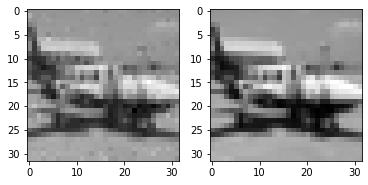

True label: 0
predicted label: 9
Time:  139.98294305801392  seconds
Initial fitness: 
 [0.5589698894595797, 0.4268866335752414, 0.3950282484576759, 0.48596127242992215, 0.37787847982882394, 0.5069944897852018, 0.5108091195698485, 0.39426904611745084, 0.4732958612910778, 0.4404058817573366, 0.39987066889885176, 0.5131879072617143, 0.348974887958138, 0.44001084221361375, 0.3900600710648159, 0.4597869507336384, 0.42061753026974, 0.49236937886808824, 0.3660767029537225, 0.4571828259556444, 0.3982322784196216, 0.36239222420785044, 0.45797543683205033, 0.4290265773761989, 0.5701522526993703, 0.4097198869465206, 0.44544266032046814, 0.5535835098524788, 0.38383999645933375, 0.4061723689842577, 0.4861920254577853, 0.4391480619358137, 0.39311460917867325, 0.37958055899777643, 0.42155244538904957, 0.3944388114879315, 0.46445739840187555, 0.3153302972586827, 0.38123931097433994, 0.3920148744432646, 0.38255405676993415, 0.4082412137935655, 0.5271901900181323, 0.49208581816743413, 0.4081120877488388

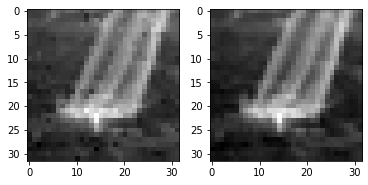

True label: 0
predicted label: 2
Time:  80.80516052246094  seconds
Initial fitness: 
 [0.022172699761654174, -0.18132121503301862, -0.11470309599783482, -0.39375154360540454, -0.14021384979871987, -0.20501598606458535, -0.21216381709180546, -0.3133488740750877, -0.11825268899065161, -0.3762992643921931, -0.13026707177377664, -0.2688867624869165, -0.18307287508210468, -0.15212922214803792, -0.21507963210011546, 0.2684586263877159, -0.33103525332432615, -0.2469119073181227, -0.26559098458315755, -0.28103985711782575, -0.28451629217303875, -0.2463420596137789, -0.2917935647338661, -0.1752298455122537, -0.2137934971503299, 0.008869623879847882, 0.08295144397132008, -0.2256602483249356, -0.19405527369355474, -0.2579213514049198, -0.20084160793824257, -0.17891185317439046, -0.34740122526279693, -0.08395666454002101, -0.35091055694730766, -0.3075741081237534, 0.0009041766036379517, -0.14607968726640602, -0.13447208252364912, -0.33502958348737566, -0.4283832678496606, -0.1911665759085391, -0.3

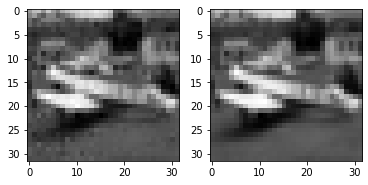

True label: 0
predicted label: 8
Time:  159.2202386856079  seconds
Initial fitness: 
 [-0.6008458430424711, -0.6001998999028936, -0.600779959490032, -0.6005239916126632, -0.6014186658903125, -0.601559232238974, -0.6021322641681988, -0.6013575306489543, -0.6034117199710988, -0.601765643738244, -0.6026514266487608, -0.6005821720545683, -0.6024878336122375, -0.600660603111949, -0.6028115010695398, -0.6000888108044051, -0.6031264182661037, -0.6005460546869216, -0.6042971658461902, -0.6000153891676294, -0.6030726275749534, -0.6032612967510236, -0.6001054139494928, -0.6012359793634078, -0.6031097854557281, -0.6002620713074238, -0.6022251148062004, -0.6022014094439861, -0.6025527571591874, -0.6016810367674545, -0.600208999138939, -0.6019526967795801, -0.6006606107271596, -0.6006483633084905, -0.6027164390635633, -0.6004481683902779, -0.6004292278307376, -0.6019910412643785, -0.6024758250306832, -0.6007615814854538, -0.6005618757827289, -0.6022628491431847, -0.6019155465497069, -0.603448889271

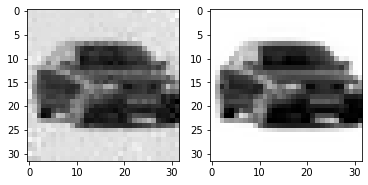

True label: 1
predicted label: 8
Time:  441.8569507598877  seconds
Initial fitness: 
 [-0.562338200137903, -0.5290993187314481, -0.5361391602383948, -0.5376155863766788, -0.5639222141396463, -0.5421128295530071, -0.5656452555076412, -0.5666500028670115, -0.5443735098513214, -0.5479121183727319, -0.4941375291859498, -0.5574274446451439, -0.35689537340629796, -0.5524539782367979, -0.48128970986043873, -0.5409831386189483, -0.5369711977166071, -0.5291520939712623, -0.501481256103544, -0.5439891615047343, -0.5560852051877148, -0.49202940004832424, -0.537463339765947, -0.5485319237709689, -0.5488048083482562, -0.5502664420478788, -0.518112263382249, -0.5080119255443827, -0.5591946255553751, -0.5250572842079868, -0.5422800535762327, -0.483656998673885, -0.5586041395356451, -0.5324531854688852, -0.537256024596595, -0.4885843059179308, -0.44260988775646204, -0.5542671889524737, -0.5398006561691843, -0.5268216617451629, -0.5441171997813528, -0.5567782360691862, -0.5520601835568733, -0.565618198

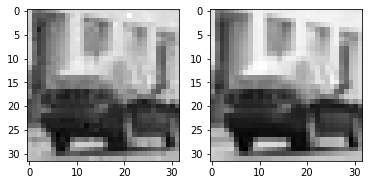

True label: 1
predicted label: 9
Time:  132.95066285133362  seconds
Initial fitness: 
 [-0.6017328114657026, -0.6007417915424664, -0.6050552794976037, -0.6071119999284988, -0.6003255189345283, -0.6057320449200672, -0.607823378591758, -0.6027060090751103, -0.6021375484406617, -0.6023445431527923, -0.6005679601582834, -0.6001453748303864, -0.6048376953011778, -0.605929443464434, -0.6019901681679259, -0.6006852530962015, -0.6041206747619771, -0.6021596871707093, -0.6005632701023234, -0.6043082237033917, -0.6004010509376008, -0.6077975956947368, -0.6001722810427892, -0.6047728643405117, -0.6019130918352342, -0.6031476170746578, -0.601438587952797, -0.6001782035865432, -0.6044018210510124, -0.6027119688351876, -0.6010945013464972, -0.6021136191700223, -0.6026363022273898, -0.6020803693223161, -0.6031979200170777, -0.6007639988550372, -0.6007924561508616, -0.607507027660825, -0.6014213647626883, -0.6035180001999356, -0.6014236181376211, -0.6030207281388812, -0.6059802263501994, -0.6048202788

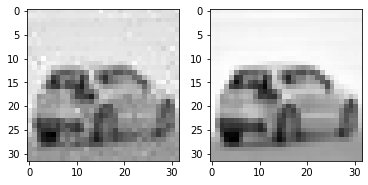

True label: 1
predicted label: 9
Time:  240.42707991600037  seconds
Initial fitness: 
 [0.31917410951484626, 0.07157084825619156, 0.49499096275064325, 0.18584691886912605, 0.6370262873537252, 0.22706622516279318, 0.4516758822540986, 0.5650678328105464, 0.42190040880502394, 0.330998864177436, 0.4024646564018106, 0.32938884117013767, 0.3755222952403525, 0.3746731535611436, 0.3340479008184748, 0.30942902338907013, 0.4742764892695992, 0.2503598800171395, 0.519144981768385, 0.27586193086783684, 0.25276039274592377, 0.4965726341469159, 0.41096451357267494, 0.21753413852323794, 0.31599289322764745, 0.38670737629554286, 0.4208247982862269, 0.30940133473024983, 0.4872087189033951, 0.4554322539868843, 0.4150626363165361, 0.33667014759537384, 0.4270547220082113, 0.34585573812885995, 0.2679891729372558, 0.28270196064731645, 0.4399264613487131, 0.5968762104530982, 0.7885373385690169, 0.39035267513757016, 0.47094788351954064, 0.5757215580732833, 0.3574835102498636, 0.27608074921887205, 0.47317360752

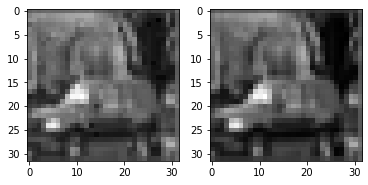

True label: 1
predicted label: 7
Time:  84.00631070137024  seconds
Initial fitness: 
 [0.5774357062097444, 0.5670459640719618, 0.6226227559358325, 0.5803439803139132, 0.5421093101316921, 0.5965483857473668, 0.4759415151647862, 0.6223464511481982, 0.6564127787823248, 0.4980439693007871, 0.5312867871841349, 0.5804433742268615, 0.6085149654271447, 0.565669699775678, 0.5028845290629904, 0.5016099581144703, 0.46776576395317326, 0.5902731091006661, 0.5611554505506118, 0.5568508583060948, 0.5058577902341004, 0.5585528567225863, 0.48280499392530074, 0.575211021491799, 0.48789557583461374, 0.4954827433237884, 0.5584069421163684, 0.5766607019400266, 0.5865599380728087, 0.5545884213510714, 0.5403108006772881, 0.5884751288529617, 0.6516355604128816, 0.6712303794937101, 0.5574063374122378, 0.6082327920127977, 0.42648482667290394, 0.48272983656670276, 0.5207308819633982, 0.43751815394667526, 0.5237413893822244, 0.5615440905646938, 0.6017589525861046, 0.5238794530384598, 0.26187856208573385, 0.460768

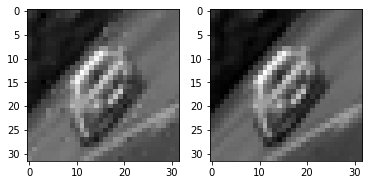

True label: 1
predicted label: 6
Time:  86.40572190284729  seconds
Initial fitness: 
 [-0.5850996121506504, -0.5957837808263557, -0.5955818758001411, -0.5898150265040011, -0.595241115819356, -0.5855772839064932, -0.590884175849516, -0.5917021103117551, -0.5953959881552706, -0.5905984694685077, -0.5924652951742305, -0.5903749955985268, -0.5913853524453545, -0.5917750091280992, -0.5917825512001944, -0.5926462041215896, -0.5938607952548951, -0.5959508254432925, -0.5874528248280493, -0.5913813561447897, -0.5935312315374959, -0.582655899078103, -0.5702242938530654, -0.5918471378852334, -0.5914680135058401, -0.5883744550473888, -0.5900489730998605, -0.5942373826166688, -0.5902375591377347, -0.5927584928830233, -0.5934217648514275, -0.5931083673324096, -0.5932212809623982, -0.5767822787376541, -0.5863339852869358, -0.5922443472317555, -0.5653032746548811, -0.5888639910027204, -0.5932516823942704, -0.5934508521006082, -0.5933551166003045, -0.5948580554015521, -0.592769714681948, -0.59396267280

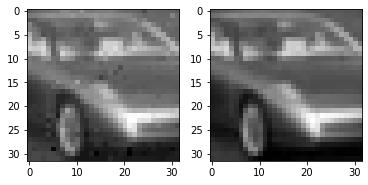

True label: 1
predicted label: 0
Time:  97.55191612243652  seconds
Initial fitness: 
 [-0.6000233721286912, -0.6000304600895161, -0.6000604351567549, -0.6000421656946122, -0.6000490713585249, -0.6000528036944743, -0.6000254763293008, -0.6000322689537231, -0.6000700206107007, -0.6000357681528596, -0.6000717518084692, -0.6000402240934107, -0.6000336486704508, -0.6000029832075009, -0.6000219239916671, -0.600045600663335, -0.6001411951186361, -0.6000354821360496, -0.6000050270733034, -0.6000349777925067, -0.6000128668336748, -0.6000188268612267, -0.6000458819402947, -0.600037847259188, -0.6000168547723799, -0.6000690273372569, -0.600064611296405, -0.6000303646817184, -0.6000688774247169, -0.600023803918658, -0.6000582620675186, -0.60010615828155, -0.6000378565658997, -0.600029607808731, -0.600048853189027, -0.600032305821774, -0.60006248944109, -0.6000206378914736, -0.6000753591395593, -0.600068362521491, -0.6000514783213011, -0.6000438784054597, -0.6000986693849721, -0.6000009124286353, -

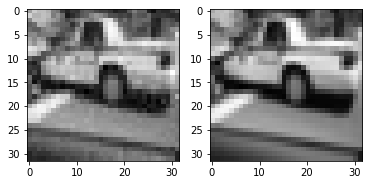

True label: 1
predicted label: 9
Time:  571.1189758777618  seconds
Initial fitness: 
 [-0.6000746481584945, -0.6004562378016925, -0.6003299812735361, -0.6000115955956085, -0.6001904726553072, -0.6015196994587066, -0.600032697926228, -0.600035976509932, -0.6001697436584981, -0.6000926098931, -0.600131708392827, -0.6002442139506798, -0.6004941274313993, -0.6003001773957735, -0.5999749130182136, -0.6008481491621033, -0.6043542869528316, -0.6001867889713597, -0.600446595683559, -0.6000831558284417, -0.6004588756844336, -0.6009079656512725, -0.6006356504456567, -0.6001061147747754, -0.6008523512288169, -0.6000557579439983, -0.6002293749704184, -0.6001820067101673, -0.6000836869015778, -0.6011517109317289, -0.6015719848943002, -0.6002125411110811, -0.6001137328897379, -0.6002324920107382, -0.6000915923269541, -0.6002568904350941, -0.6015085712525265, -0.6036400572772163, -0.6015909017362601, -0.6001325742958294, -0.6000381793925508, -0.6020318030390369, -0.6002746028012749, -0.60145240015320

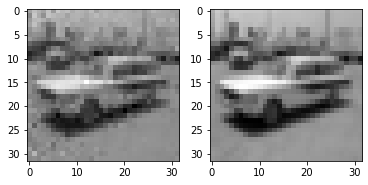

True label: 1
predicted label: 0
Time:  218.86139106750488  seconds
Initial fitness: 
 [-0.600055710198575, -0.6000824426561105, -0.6000774861363861, -0.6000395461203308, -0.600069447904166, -0.6000429212793466, -0.6000192676334131, -0.6000251428471516, -0.6000504420359101, -0.6000197290159639, -0.600048103230181, -0.6000504175699878, -0.6000836784337467, -0.6000269301512944, -0.6000576485732476, -0.6000240261783777, -0.6000850084984632, -0.6000436387907434, -0.6000201188467094, -0.6000624459267421, -0.6000271168949298, -0.6000365053895713, -0.6001110037595131, -0.6000009461242526, -0.6000501308604522, -0.6000379992296896, -0.6000573378243126, -0.6000641067292619, -0.6000724760928923, -0.6000270674961261, -0.6001426663679236, -0.6000538930221202, -0.6001108921264325, -0.6001022015969413, -0.6000389489568687, -0.6001264618443864, -0.6000887281577247, -0.6000696929575449, -0.6000562588385681, -0.6000024615902398, -0.6000324610099381, -0.6000217769499219, -0.600085148579333, -0.6001252929

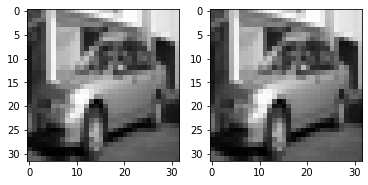

True label: 1
predicted label: 1
Time:  50.5949010848999  seconds
Initial fitness: 
 [-0.5993667330282179, -0.5987957943256643, -0.5997466784615109, -0.6002844557583651, -0.6000753411283706, -0.5996729647038809, -0.5996842066132977, -0.6000681431153898, -0.5998314758997091, -0.59940894181574, -0.5996346293133447, -0.5999430184662543, -0.5997233883854658, -0.5996168696986982, -0.5998424705897066, -0.5998999428266173, -0.6000679274576565, -0.5995265043072342, -0.6001571145585852, -0.5999158447203798, -0.6001322938639084, -0.5991525490297147, -0.5998164430931772, -0.5998058301929069, -0.5998847645087824, -0.5990776894432581, -0.5995035036027163, -0.5997014553659614, -0.599889258833737, -0.5996465898627426, -0.5995525461655601, -0.5995162367720949, -0.5996372007950397, -0.6000391653244841, -0.5992639324385847, -0.5996240516086098, -0.599343547511979, -0.5995817333826943, -0.6002251987491017, -0.5989991552826642, -0.5999718998902575, -0.5995784747320334, -0.5994135518373651, -0.599906936981

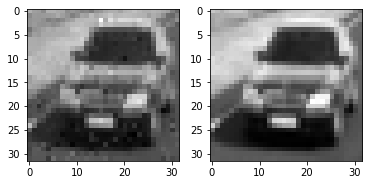

True label: 1
predicted label: 9
Time:  117.73828601837158  seconds
Initial fitness: 
 [-0.6000336401833953, -0.6001386753076817, -0.6000245415697976, -0.6001203721435528, -0.6001276298067844, -0.6000273156300697, -0.6000719945072855, -0.6000489029654168, -0.600163488095091, -0.6000365177836944, -0.6000605378012447, -0.6001386161249469, -0.6001176516739741, -0.6000984647438243, -0.6001517443963131, -0.6000737066627881, -0.6000639261169918, -0.6003644388229002, -0.6001289552835799, -0.6000921553437295, -0.6001043446203451, -0.6002971493476974, -0.6001906908575653, -0.6001001322287808, -0.6000816961931525, -0.6001499144603779, -0.6001496850453965, -0.600130669036685, -0.6002243282220316, -0.6000555435458749, -0.6000307340421842, -0.6000588770792225, -0.6000410713333929, -0.600113605703611, -0.6001460901049255, -0.6001118233473552, -0.6000494574006515, -0.600156311546103, -0.6001559774192402, -0.6000642747370254, -0.6000271252433945, -0.6000453725510264, -0.600045036227792, -0.60004893051

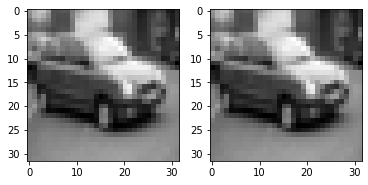

True label: 1
predicted label: 1
Time:  50.09195518493652  seconds
Initial fitness: 
 [-0.6003275996092071, -0.6000244975643867, -0.6001470537384788, -0.6000774433576014, -0.6005883253488667, -0.6001936745839171, -0.6000785052409126, -0.6000479917321873, -0.600219068487762, -0.6002616688148205, -0.6003101248667818, -0.6003182420002477, -0.600050385374855, -0.6001109961008941, -0.6001865893893034, -0.6003168100307691, -0.6001639055734646, -0.600158543114651, -0.6002328280157563, -0.6002441812129193, -0.6002950388539836, -0.6002007275422613, -0.6008405977479766, -0.6001554057032417, -0.6001659250593084, -0.6002968757301979, -0.6001404511920867, -0.6000650137554038, -0.6001594425945194, -0.6001066949457563, -0.6004108200865562, -0.6001362334112156, -0.6001480068442706, -0.6002033987045767, -0.6001666333679836, -0.6000780363483941, -0.60002604594593, -0.6000898828712694, -0.60034487102095, -0.600889842299199, -0.6001309438045784, -0.6000715794486726, -0.6001348473347574, -0.600097341714859

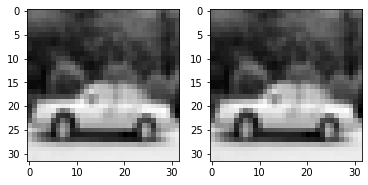

True label: 1
predicted label: 1
Time:  50.68251132965088  seconds
Initial fitness: 
 [-0.5934751489954393, -0.5937565717499014, -0.5939301057925586, -0.595701235541026, -0.5895331451989736, -0.5899098958995074, -0.5930629583144004, -0.5926879910417483, -0.5918513950744015, -0.5919920300421264, -0.5930472548580299, -0.5933259119869606, -0.5938471222214405, -0.5943890131712903, -0.5916247822661058, -0.5926505373177077, -0.591828684182905, -0.5885635841073299, -0.5923514364328875, -0.5934618452462768, -0.5931077160873813, -0.5903410272443697, -0.5945820489277773, -0.5934663265520652, -0.5920490376154876, -0.5937934761630584, -0.5944105230632042, -0.5935739121639063, -0.5913678280215033, -0.5924059080589742, -0.589075347857277, -0.5933670542360108, -0.5891152536399475, -0.5937971567344243, -0.5881230020238706, -0.5917707130002434, -0.5954443742404423, -0.5946534173878503, -0.592105854142878, -0.5939929743978063, -0.5880090951463094, -0.5912772383902495, -0.5895969320556677, -0.59446672775

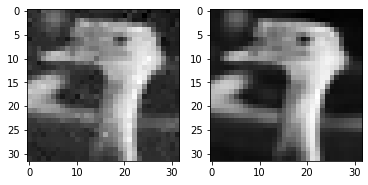

True label: 2
predicted label: 3
Time:  221.1465973854065  seconds
Initial fitness: 
 [0.7276680199924171, 0.63044502785272, 0.40032448885096095, 0.5904802391617217, 0.6021919068392503, 0.6675901807767795, 0.6356969245494066, 0.6921569044403967, 0.6903142255912164, 0.774651101518978, 0.7022194512010194, 0.6115873504040726, 0.7521578431917942, 0.6581621840240287, 0.8742570105979728, 0.565492446506422, 0.8058098295734044, 0.5022254360788299, 0.7230014719582966, 0.562063733788624, 0.5799904247774145, 0.7708531240846925, 0.8414937089058226, 0.3613462348623947, 0.5309822303442744, 0.6632325268220552, 0.5351056682651241, 0.7681279648405883, 0.649187869274569, 0.7008063804855454, 0.5733267204094864, 0.660199530877238, 0.5471374113797657, 0.6982769895203829, 0.6992392688483363, 0.7145628167207903, 0.46628272630135803, 0.7186156994517908, 0.6471972775798933, 0.5893532823025169, 0.5372807609638091, 0.535174819543395, 0.6456484341703821, 0.2541484442990004, 0.6822705382392794, 0.5644912053146132,

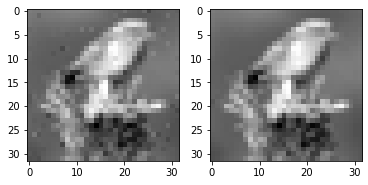

True label: 2
predicted label: 6
Time:  74.09058904647827  seconds
Initial fitness: 
 [-0.26050926123099316, -0.12217794042827249, -0.2670958734559976, -0.31912758909548217, -0.292757693041111, -0.23259871018023384, -0.21333881349815845, -0.11747996374316388, -0.3192901182293558, -0.19053759248913021, -0.33448986961517146, -0.16995671314572747, -0.21669067769615818, -0.16123012209521217, -0.2634689122362019, -0.17727314413626263, -0.33013965136158335, -0.3234369485485872, -0.17758151952806472, -0.2346051860739449, 0.28845561955763366, -0.2980317156340002, -0.3200938267771122, -0.2120920002345311, -0.16066581892517035, -0.3068882867168292, -0.19190520163016117, -0.16928056220849363, -0.24644002184376398, -0.1196925608446838, -0.3059394908249573, -0.23657105667780337, -0.2620514350369924, -0.2786204397378528, -0.28637009019135884, -0.2950153533351677, -0.2816438703267212, -0.04686686214066177, -0.1686413917410269, -0.2415078733547593, -0.21279058568296075, -0.2586334319899345, -0.1842000

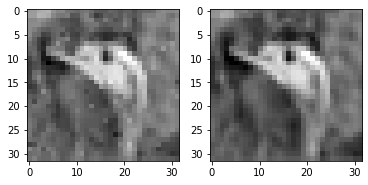

True label: 2
predicted label: 6
Time:  92.94599485397339  seconds
Initial fitness: 
 [-0.28761324915952824, -0.44896926011888005, -0.2745823350359458, -0.34204079531682574, -0.19598684952367748, -0.13460743185144483, -0.21147144210059055, -0.3420636564738734, -0.10202186204845531, -0.1815589574278504, -0.06325655760178317, -0.2871131707556739, -0.16945006052377642, -0.23550877401179512, -0.33811154654200026, -0.0918123619852324, -0.3380478963027127, -0.44717588155045873, -0.39488575762068145, -0.2710254769478162, -0.2380023635018679, -0.2554015594700576, -0.2163304754236201, -0.14419846247254667, -0.2541662456157129, -0.19691106432472572, -0.23800221122112192, -0.2289573557563671, -0.28686722395059616, -0.1328041624591614, -0.241911427932612, -0.23664972300653797, -0.16174661851292504, -0.3119851305988932, -0.1870305604894733, -0.06610729544604088, -0.10999302178825143, -0.1532847969004616, -0.11618723777260218, -0.36865766964722546, -0.28868547950742207, 0.03741120187697469, -0.23399

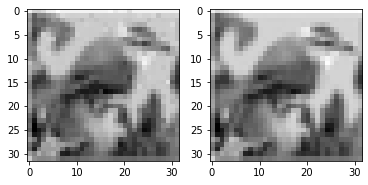

True label: 2
predicted label: 5
Time:  122.90987539291382  seconds
Initial fitness: 
 [-0.6001114415897404, -0.599696557735361, -0.5999856663641898, -0.6015251904572605, -0.5997735056244637, -0.5999070737715848, -0.6001340168671283, -0.5995604201496878, -0.5998347410877631, -0.5999239857646947, -0.5998923670311544, -0.5996526812843569, -0.5998825149379274, -0.599700474554396, -0.5998827194853841, -0.6003480279121665, -0.5998952199909924, -0.6000196421544305, -0.5998417560360276, -0.5999551810797761, -0.6003815308209653, -0.5999844909170167, -0.6002551565473894, -0.5998576366351296, -0.600340216721989, -0.6000584805687875, -0.5998992077918245, -0.6008245849786088, -0.5999495566651679, -0.5998667310427219, -0.600505071548757, -0.60016159833664, -0.5999261259399989, -0.6000662094198342, -0.5999980490020564, -0.5997646425171729, -0.5997837827680882, -0.6000285949851212, -0.5998327324902468, -0.5998457505537094, -0.6003436010882937, -0.5997837591091126, -0.6006437251391581, -0.600074074821

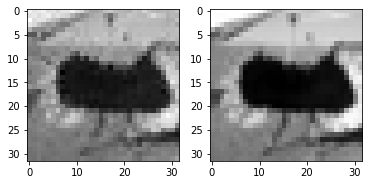

True label: 2
predicted label: 0
Time:  330.0076322555542  seconds
Initial fitness: 
 [-0.2630458489328483, -0.07927573667629648, 0.3196311954430875, -0.2522398816628458, -0.09919600108043666, 0.07033615701398137, 0.1897605672733318, 0.009277431546424991, 0.18236672663616152, 0.0578973755077552, -0.30686575086799717, -0.21983647434079218, -0.12512481959018829, -0.21049435221403281, -0.20251718725153536, -0.25110833846176156, 0.1053132561950278, -0.013135120365885183, -0.03874867819067257, -0.16543371958530279, -0.02954020050470413, -0.13854254320839327, 0.051452209444210306, 0.11239411415784419, -0.060219638049878565, -0.01061660274386797, -0.046828932796815353, -0.3547779654438834, -0.1960271042992159, -0.03167659554713975, 0.1553085116526012, -0.19306382790634094, 0.04106954558985568, -0.3927753830127857, -0.0069608468408561275, -0.13624297855032333, -0.0793559192726559, -0.06522235174583374, -0.11497385188794237, -0.24554979372587252, -0.34418572517379775, -0.12904154262895057, -0.2

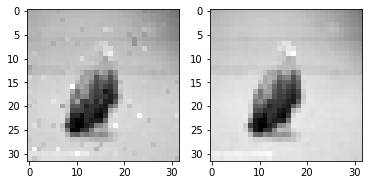

True label: 2
predicted label: 6
Time:  73.46089720726013  seconds
Initial fitness: 
 [-0.5953816081795553, -0.5972376043172147, -0.5962331397948051, -0.5967384455385212, -0.5960782586059516, -0.5943582829506877, -0.5957559459800397, -0.5954703803578419, -0.5960825223201808, -0.5950146218671366, -0.5979357857682309, -0.5951326159970167, -0.5951151263425462, -0.5951974934450484, -0.5961383111822172, -0.5945391800616239, -0.5913983280593371, -0.5946905227498308, -0.5926567579592891, -0.5944050244256782, -0.5952234132326354, -0.5967079357119527, -0.5948539739814516, -0.5957207725150913, -0.5911895348457716, -0.5936090540436215, -0.5948379104954514, -0.5946969834481532, -0.5970460112090421, -0.5920868195064449, -0.5968348599811515, -0.5892474776810008, -0.5976144841890023, -0.5943586897083466, -0.5965893374413975, -0.5935827959798786, -0.5957404057934487, -0.5899741457681525, -0.5961761864187978, -0.5973255971921215, -0.5968577277628618, -0.5961440085021579, -0.5977729042539828, -0.5961202

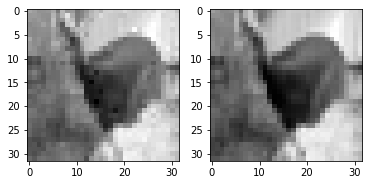

True label: 2
predicted label: 4
Time:  92.30133986473083  seconds
Initial fitness: 
 [-0.019688718159867502, -0.15892859463316755, -0.12634279722598452, 0.10419127033616479, -0.04924314325007126, -0.07323282009239274, -0.08391783677497622, -0.09075325391375985, -0.13402676881804465, 0.02309819402978905, -0.14373901311477943, -0.08386507424320205, -0.3718760032833317, -0.08549054190151928, -0.14006342083958764, -0.07293940787778544, -0.001968020257761105, -0.2250375201136468, -0.10784820663397604, -0.1414222279266975, 0.005487031687104432, -0.20426388336418805, -0.08717780715956397, 0.052167561725187966, -0.19329642991734952, 0.07290090243058076, -0.14071713626196813, -0.3580277375624996, 0.16259778950168474, -0.14066057554626377, -0.2329690621965025, -0.11672927027071653, 0.033504267124295384, -0.24145783134184823, -0.026406490731181592, -0.06978773344612546, -0.20301617934697802, -0.164990194142609, -0.05982569518385589, -0.07807342771157139, -0.029440076544733518, -0.059095721735456

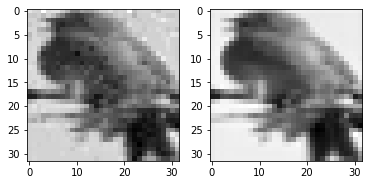

True label: 2
predicted label: 3
Time:  150.08180475234985  seconds
Initial fitness: 
 [-0.5823473142152775, -0.5383078052123572, -0.574959201666006, -0.5811529660988441, -0.5766457128978347, -0.5775201349018003, -0.5810284201633428, -0.5884904165029253, -0.5472573598629915, -0.5880045606152864, -0.576326250880935, -0.5119331884256189, -0.5905200110253696, -0.5738018602016082, -0.566972023556539, -0.5667111014547948, -0.5795334155970557, -0.5719126331177603, -0.5588316454293885, -0.5860563281097806, -0.5720332443574032, -0.5832248126021187, -0.5839326279373287, -0.573765195231958, -0.5777658497816673, -0.5755865450157991, -0.552992039374496, -0.586331240722493, -0.573386849542559, -0.5860106421592843, -0.5794663465901612, -0.5860493612813227, -0.5787479861611355, -0.593511205869157, -0.5667522836957615, -0.5891444264201173, -0.5864189190637894, -0.5908951589603055, -0.5755653550193729, -0.5810691866391635, -0.5893399857821608, -0.57821849522957, -0.578163299168946, -0.5809151000191506,

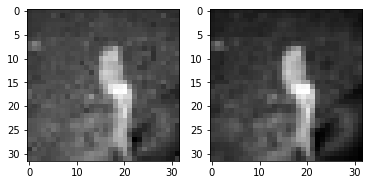

True label: 2
predicted label: 3
Time:  125.85241365432739  seconds
Initial fitness: 
 [-0.5516231194735308, -0.5681154413148723, -0.562293658963548, -0.5608089401005807, -0.558483626424183, -0.5479749337397996, -0.5485706031081286, -0.5309685886112641, -0.5469116314535648, -0.5515987253172092, -0.5544451650981452, -0.5660766717239747, -0.5580109045643223, -0.5476385112242373, -0.5669711226373398, -0.5613530630471646, -0.5535986195900431, -0.5639085784620292, -0.5599563351340426, -0.5516805243567068, -0.5579043321837811, -0.5511724252025884, -0.5584965430948247, -0.560844439611773, -0.513590645505114, -0.5684426979465014, -0.5567126758552168, -0.5469689582154661, -0.5574265616073477, -0.5432097746216114, -0.5436068627403976, -0.5602796829657807, -0.5489168868814974, -0.5367918293593263, -0.5563890759595442, -0.5610230402658116, -0.5578790301492588, -0.5710594163716258, -0.5727154536580593, -0.5498282834504891, -0.5548705307589196, -0.5534362701867341, -0.5573074035616472, -0.5574621553

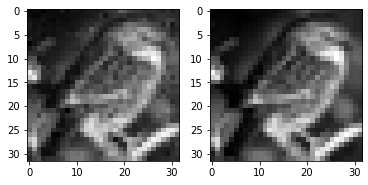

True label: 2
predicted label: 6
Time:  180.20699954032898  seconds
Initial fitness: 
 [0.9191082348950673, 0.8569004890009408, 0.8719002007564579, 0.9268769967269896, 0.7460593032287639, 0.6885941933751993, 0.902043537072645, 0.8777869576693869, 0.8838502412939865, 0.8978114526243803, 0.8841100246365519, 0.8894304293547526, 0.8961972063793587, 0.892611982494548, 0.9256021924932555, 0.87006252155821, 0.9101877748465546, 0.8821565795426758, 0.9446150633240709, 0.8797967973302339, 0.9002376089635592, 0.8078441660050814, 0.8774749653368894, 0.9038434797302378, 0.8986156689313611, 0.9180887511765583, 0.8546763002785022, 0.7726635742762177, 0.7588269126374831, 0.8950154286357811, 0.9147334422912836, 0.8857946881290186, 0.8807531194504411, 0.8809411970993851, 0.8542872451890005, 0.8196645888961798, 0.8907152744704305, 0.8810613643524399, 0.8832241752136394, 0.9074163506666202, 0.8960825835632749, 0.8810609787795863, 0.8928461072592477, 0.8719715810923607, 0.8982247427726918, 0.88447395521408

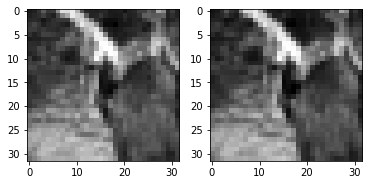

True label: 2
predicted label: 7
Time:  98.46075773239136  seconds
Initial fitness: 
 [-0.6161213208608924, -0.613734212078915, -0.6056319108806556, -0.6167350349993704, -0.632186085735321, -0.6149764779138004, -0.6062771070972711, -0.6201214470355378, -0.6173226689950664, -0.6176859022693729, -0.6119950491153154, -0.6185142071971819, -0.6194167248775773, -0.6098842538832728, -0.6150148491182512, -0.6188062468774389, -0.622636429309054, -0.6201049331619133, -0.6210073198538338, -0.6253206610764217, -0.6163340621138691, -0.6182166893379191, -0.6114906326732629, -0.6207453076003564, -0.6184387731667051, -0.6049198656612185, -0.6102745282083757, -0.6147565249815483, -0.6138621915462397, -0.610835968910135, -0.6177370187467978, -0.6121983925576577, -0.6013834391038196, -0.6294386772402265, -0.6305967479858201, -0.6112187301274479, -0.6091916293961601, -0.6147610083294868, -0.6178651431511473, -0.6013678319995003, -0.6042456225228916, -0.6021375317260369, -0.6230617341390123, -0.61545559766

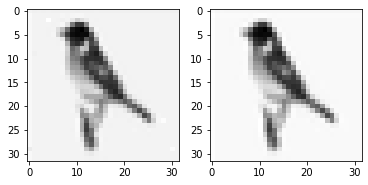

True label: 2
predicted label: 2
Time:  50.93419647216797  seconds
Initial fitness: 
 [-0.6002859396651474, -0.600528610820823, -0.6012134514682778, -0.6006045979285166, -0.6000538460314188, -0.6001068736443701, -0.6000245035284448, -0.6002132769188787, -0.600279811923291, -0.6002126985880277, -0.6002458100298999, -0.6000500162379894, -0.6006524200276435, -0.600361095349372, -0.6000162289165527, -0.6002033286435754, -0.6001679282953407, -0.6003135238489636, -0.6005906445778801, -0.6001404397771704, -0.6002647606689863, -0.6003756765401932, -0.6001581063481927, -0.6000688118231754, -0.6002001030406918, -0.6000555005630487, -0.6006183493049965, -0.6000205284589457, -0.6008773162011113, -0.6001501891797361, -0.6003188944689488, -0.6002504779414344, -0.6001905560344927, -0.6006640315067422, -0.6001241255145511, -0.6000283176579708, -0.6001334390377059, -0.6007374605473943, -0.6000329941587815, -0.6006967690830946, -0.6003961851114272, -0.6001156898812116, -0.6000507973723382, -0.6002726375

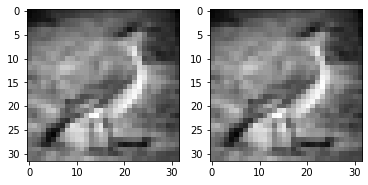

True label: 2
predicted label: 2
Time:  51.07994031906128  seconds
Initial fitness: 
 [-0.6013275622580877, -0.6020402429946852, -0.6022146521340742, -0.6006000806643474, -0.6019009554682007, -0.6008504716054686, -0.60016835202356, -0.6017957821461433, -0.6016996808346389, -0.60189126909067, -0.6003779814137674, -0.600947077774085, -0.6061075155182183, -0.6036378092527475, -0.600719329649056, -0.600801892606303, -0.6015969610851439, -0.6047805184575364, -0.6009907760621986, -0.602089496883943, -0.6013381410566718, -0.6036602481218881, -0.6012372665611818, -0.6000772101522373, -0.6002998895501143, -0.6021649986543312, -0.6030894802420534, -0.6002720068165251, -0.6014726565887075, -0.6012961956977578, -0.602542736918637, -0.6020695358177699, -0.600205087791353, -0.6016310273693564, -0.6004455381610432, -0.6007492934318011, -0.6005522617830401, -0.6032213177218575, -0.6025066798644504, -0.6023150375985564, -0.6003019736423677, -0.60062045338244, -0.600683715474548, -0.6003516889115437, -0

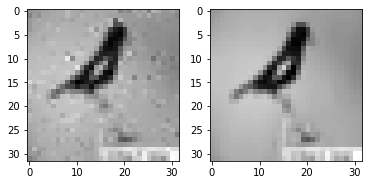

True label: 2
predicted label: 0
Time:  155.076833486557  seconds
Initial fitness: 
 [0.994560102555188, 0.9912136688351625, 0.9861093905582943, 0.9901464699930336, 0.9889869113675418, 0.9795235863006921, 0.991366341396585, 0.9842334260384781, 0.9851375870054878, 0.9726278691031064, 0.9828863513552513, 0.9733824842211659, 0.9928105719780403, 0.985688841617691, 0.9919827931558941, 0.9715894524212341, 0.9901981841222349, 0.98957010771594, 0.9790392531712783, 0.992655391034946, 0.9800013292272625, 0.9840573467993228, 0.9926537985999724, 0.9805458350344229, 0.9889573250385847, 0.9900240246585653, 0.9915643087900914, 0.988696192172006, 0.9894496560589805, 0.9895779199463189, 0.9891854997386924, 0.9911312428886311, 0.9925495911877525, 0.9845244224720939, 0.9780026115697702, 0.9857741365175161, 0.9900550741261324, 0.9820161058412734, 0.9898896475755448, 0.9613136593456693, 0.9795806732848088, 0.9908718377394974, 0.9880358406395218, 0.9871205831047484, 0.9856145343851563, 0.9845392781266317, 0

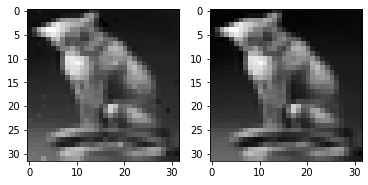

True label: 3
predicted label: 2
Time:  68.7921826839447  seconds
Initial fitness: 
 [0.14539504157772393, 0.4110723529512156, 0.33627835354367575, 0.16370236301077634, 0.4317479379001727, 0.27833917082817217, 0.500581407829904, 0.3428941144813121, 0.19897657339713845, 0.21434562600063037, 0.1652749519642852, 0.13239105435526832, 0.29625870233692064, 0.2185044431093896, 0.21931172265002286, 0.0758372353878305, 0.39878076933943885, 0.387578995959985, 0.07732363645697868, 0.0412218411503906, 0.3386211908828498, 0.28491918052958226, 0.40302606577073974, 0.2947571314757608, 0.28461167872482396, 0.31229117344863155, 0.4008251923295895, 0.45327805694068546, 0.3315580080169036, 0.3711058909846848, 0.16286515563632567, 0.27376573905713186, 0.03789164719619151, 0.39080808899405356, 0.19168781635100518, 0.13653761615213436, 0.33387632870884476, 0.29633737740169197, 0.0637363863932103, 0.19307885236098823, 0.39607311217539987, 0.21959061739304137, 0.3181158623880392, 0.3635021577483055, -0.011060

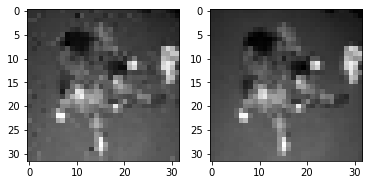

True label: 3
predicted label: 0
Time:  138.80130100250244  seconds
Initial fitness: 
 [-0.25908089623050334, -0.21571480738307677, -0.31463464954448095, -0.16523812566404572, -0.2955153839711895, -0.17258321924413336, -0.32555766002850756, -0.2651543580074169, -0.24645075529493046, -0.2539197200199972, -0.32403008854069565, -0.3219929264018707, -0.1964626203981614, -0.3134242258995995, -0.304773937978727, -0.3936035093284308, -0.23603596476294914, -0.24075314692163988, -0.30297181174535903, -0.3718988398013625, -0.33567950726628215, -0.31065021131554876, -0.2961600167855617, -0.3223797846938202, -0.29755285145306976, -0.24375821533530995, -0.22480146380371757, -0.278100944058181, -0.28245412865226655, -0.29468180750950856, -0.30842805228450176, -0.22082020927932872, -0.23750747614088152, -0.2650720027673409, -0.22423967176549978, -0.3464146504956406, -0.21708409248274108, -0.12366798806690299, -0.41683132882282503, -0.2831170094055382, -0.31707547047550844, -0.2564514180264783, -0.223

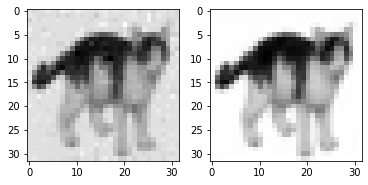

True label: 3
predicted label: 5
Time:  247.04815530776978  seconds
Initial fitness: 
 [-0.5472650346568879, -0.5317947146119921, -0.5572703411408921, -0.5637447129323374, -0.5561432730671605, -0.5611499695663881, -0.5751644774147621, -0.5548575785943145, -0.5684502482596828, -0.5517426494013526, -0.5747429259525173, -0.5418448388620144, -0.5509870564028225, -0.5680140135869898, -0.551865522048384, -0.5619995081697428, -0.5646457384822645, -0.5519997209400531, -0.5835662178985499, -0.573973825465811, -0.5681011261790128, -0.5627195598691577, -0.5505247810974886, -0.5792223907214668, -0.5614724479754645, -0.5804530584609775, -0.569106948859933, -0.5547455314474149, -0.5651852463638787, -0.5640578195812321, -0.5682970846464502, -0.5754235057386863, -0.5622986205538487, -0.5586324173315789, -0.5704553831378718, -0.565591495772488, -0.5565250279765189, -0.5757260247530099, -0.5659416482831962, -0.5752845598967224, -0.5129013257490315, -0.5634632428567833, -0.5697809470169197, -0.5680752990

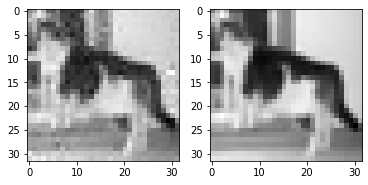

True label: 3
predicted label: 7
Time:  391.1915304660797  seconds
Initial fitness: 
 [0.5773242825670484, 0.755651158088493, 0.66757999993753, 0.6001474907869426, 0.6720820614482528, 0.669673058314519, 0.6078141642175585, 0.710242697412549, 0.6621459607768644, 0.6447798850163788, 0.7905022087576632, 0.6850001856756734, 0.6688569839201494, 0.7042151254268186, 0.5205973814752111, 0.6363217135492978, 0.7822218756383592, 0.6733490229663314, 0.7876900107673066, 0.5511429207961169, 0.5620150709609524, 0.6924129533703113, 0.7619413894963031, 0.6724562606190594, 0.705315942769054, 0.6610275658444669, 0.6555177721865263, 0.654063517339819, 0.40731741512959463, 0.7132179171287787, 0.7230861897952713, 0.7198716682327824, 0.5083418816206733, 0.7633551752090125, 0.7043959038518647, 0.6567115722297938, 0.629481345862375, 0.7339880265905527, 0.7808269632400895, 0.6851846063954625, 0.5267146730998098, 0.6492318387952146, 0.6809513375481951, 0.6443147081809886, 0.6895267338465882, 0.6903012553007681, 

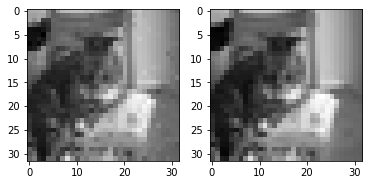

True label: 3
predicted label: 2
Time:  117.55196690559387  seconds
Initial fitness: 
 [-0.2459550228767795, -0.2413824561121718, -0.2462444554042835, -0.14095765106619074, -0.15723380504236803, -0.22194120494433514, -0.23474974903324702, -0.3132939414890902, -0.277112634177372, -0.14600349887573394, -0.2521936381668624, -0.2677391026949626, -0.3447591735423994, -0.28972653380276336, -0.28577194065362854, -0.19644878112599146, -0.20973659143159848, -0.2745507013266778, -0.24167011776186675, -0.18481155965538978, -0.31352352053170107, -0.24856805187472308, -0.22419265688934406, -0.31535174359605433, -0.29836305486201764, -0.2976904789843883, -0.2763619077009361, -0.266206806037385, -0.20139626632215848, -0.32887148235812436, -0.18031975740083112, -0.22557846537506715, -0.250704357874692, -0.31208334294964046, -0.21967611667975578, -0.21525721611760754, -0.25420260308678977, -0.217715436262459, -0.3116890649882774, -0.23987195697486433, -0.2560645869918593, -0.20717216770772406, -0.18444

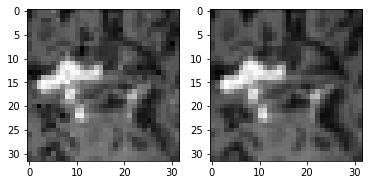

True label: 3
predicted label: 6
Time:  118.96350574493408  seconds
Initial fitness: 
 [-0.5871924447899293, -0.5754741758214459, -0.5869073339614846, -0.5879758405090911, -0.5852770015231656, -0.5894319664107444, -0.5839023822258053, -0.5802474689822561, -0.5876435336643282, -0.5944901966189223, -0.5769174058727131, -0.5865276971872004, -0.5794652276279328, -0.5867582281635473, -0.5756996653882498, -0.5862343684637104, -0.5895268357106969, -0.5846276380814772, -0.5827455274127671, -0.5799161494649057, -0.5900825608186621, -0.5817125176086383, -0.5853752573759216, -0.5803513914744545, -0.5766238829476764, -0.5835904063306505, -0.5881568597384488, -0.5868915845494558, -0.5883442253140562, -0.5879933235692865, -0.5885212670522699, -0.5847784778047878, -0.5871736565239329, -0.5885303739667276, -0.5857336590667601, -0.5875381983461165, -0.5843470085095733, -0.5858986655968582, -0.587301091616974, -0.589761439946323, -0.5810840844636516, -0.5863392970710686, -0.5821062237524437, -0.58733640

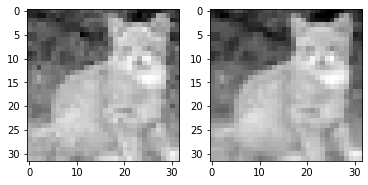

True label: 3
predicted label: 5
Time:  308.90431666374207  seconds
Initial fitness: 
 [-0.41177160589396994, -0.07003408424410962, -0.24399223870052017, -0.4223849708242957, -0.33559394470507375, -0.318180807378755, -0.4099036170540392, -0.3685614115741564, -0.34200730301915394, -0.33101219124357767, -0.30206696069229244, -0.4226204074184089, -0.11602422173288268, -0.30547166947138915, -0.38242471878615336, -0.2619065938264384, -0.17244628689506786, -0.3339742773602581, -0.30997104765310435, -0.382929711804384, -0.26698427396017244, -0.37352235180914595, -0.27920363458787845, -0.4191270739800419, -0.3393380109935371, -0.4131383690752073, -0.0827083968961474, -0.4008803617582675, -0.3606245103629695, -0.2988371786527704, -0.3396856826328397, -0.38991306391174496, -0.24036879325792795, -0.31541006763587276, -0.4338638477371779, -0.44449994069533827, -0.4094740434471015, -0.3579742345416522, -0.3748181782602409, -0.35989830327911687, -0.3413565459801219, -0.3612270625953662, -0.327166567

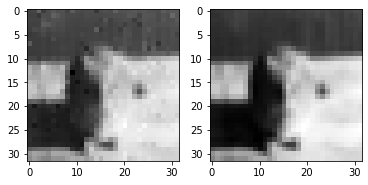

True label: 3
predicted label: 7
Time:  115.3420922756195  seconds
Initial fitness: 
 [-0.5861523880163784, -0.5818671740032835, -0.5845058085576967, -0.5850102895875992, -0.5883412630018259, -0.5742812401823997, -0.5799560529995528, -0.5616022849729758, -0.5879110327086816, -0.5902528445822998, -0.5769487857754261, -0.5947706922726621, -0.5804019606118647, -0.5745084912157343, -0.5860236866282318, -0.5782807963157505, -0.5822688939946629, -0.59471151644204, -0.5766521910559682, -0.58449027100982, -0.5851489651125238, -0.5849402253548837, -0.5816902841356947, -0.5840887541408869, -0.5840260327964084, -0.5584349104915315, -0.5727346820161276, -0.5721592186910939, -0.5722400013621611, -0.5822305584954013, -0.590338765919201, -0.5694446067093201, -0.5803092905887905, -0.5757825153933284, -0.5806189004597155, -0.5831435141324319, -0.5812893450829855, -0.5933001583687055, -0.5830642545576656, -0.5873011877397374, -0.5849738043082242, -0.5824788566240231, -0.5831813805334425, -0.586514045501

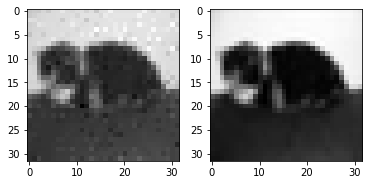

True label: 3
predicted label: 5
Time:  144.66287422180176  seconds
Initial fitness: 
 [-0.5393880391764853, -0.5578959152367609, -0.5614019618232549, -0.5405625279738951, -0.5586255129949658, -0.5462208739175816, -0.5474584725667185, -0.5574272914811508, -0.5385277933168175, -0.5489176425481952, -0.5181863322215392, -0.5475094247054387, -0.5624112248316391, -0.5453588120191187, -0.5514766612535917, -0.5286884800287296, -0.5526154552577998, -0.5530005170384442, -0.5195964931853191, -0.5367308808686451, -0.5570883523986355, -0.5450134154145185, -0.5562497887291955, -0.5437016117490874, -0.5173337616809005, -0.5380878049641046, -0.5536554367130455, -0.537548814936261, -0.5180297408228591, -0.5345571873245206, -0.5299018870248926, -0.5202255946539193, -0.5280698397594658, -0.5708837405049252, -0.5489818431423211, -0.5396907542848319, -0.5460942484729487, -0.560429879258517, -0.5174995787899375, -0.5482395593182425, -0.5463203659683094, -0.5235362742251813, -0.5536851895027988, -0.55716925

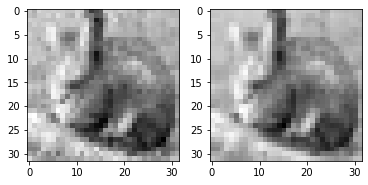

True label: 3
predicted label: 2
Time:  261.2199559211731  seconds
Initial fitness: 
 [-0.5234832355095214, -0.5379592022248768, -0.5168482008488443, -0.525897857652561, -0.5099757878996378, -0.5081202312288082, -0.5282599709276296, -0.4871908818687837, -0.5303396816298871, -0.48318753691806693, -0.5314922839710245, -0.5014974762316149, -0.4794163209974358, -0.5213303407331119, -0.5084205719027906, -0.5147679687032309, -0.48960037825022384, -0.5161982529176827, -0.5141970818038969, -0.497248675392541, -0.49462571839089364, -0.5214357857666441, -0.5144235915021782, -0.5262515125825282, -0.49997132118571097, -0.4885371490436271, -0.512602129946693, -0.5447223417473964, -0.5365829700133552, -0.5287770969825674, -0.512071134005462, -0.5008683923882884, -0.4920398398453859, -0.5032653410531577, -0.534125248699214, -0.5539424832739814, -0.5446848016148134, -0.528909069930995, -0.4964392768128589, -0.5065964137060012, -0.5174833481904113, -0.5054484233760327, -0.5345721621596047, -0.516536785

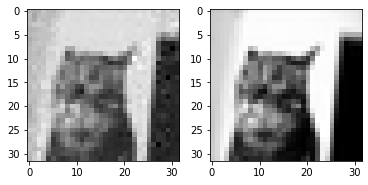

True label: 3
predicted label: 5
Time:  478.98631501197815  seconds
Initial fitness: 
 [0.6538888863964585, 0.7512902069850491, 0.6601091983909972, 0.5524225630875625, 0.6405310719206121, 0.727180098335422, 0.7271812021847832, 0.6345151426323886, 0.6278483558739445, 0.7354790753353415, 0.67559989671411, 0.625936822787865, 0.6635807074936824, 0.7011797601812488, 0.616747698714818, 0.6811239533979875, 0.5370850293805258, 0.6907881642832361, 0.6375379790670432, 0.7038160326581824, 0.7452213332346008, 0.6476794536407915, 0.6031830155189108, 0.6204585423784239, 0.7090997758762829, 0.5965302164347228, 0.7252864553172782, 0.6695122728920584, 0.6842632615035702, 0.6817035340098776, 0.6435755584920473, 0.6238552066307538, 0.6517779046507501, 0.7017442590162689, 0.6908505652792157, 0.5582302635449795, 0.5561455060601569, 0.6540619973460515, 0.6694059487943091, 0.7367764147210079, 0.7253859306066048, 0.6333903816223228, 0.6573273656610072, 0.6606857504340091, 0.5979192585775901, 0.687525635415719

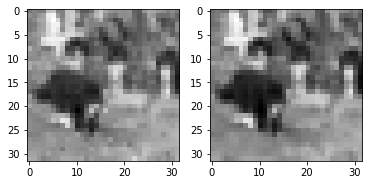

True label: 3
predicted label: 2
Time:  90.90836119651794  seconds
Initial fitness: 
 [0.2901003341650787, 0.21210366761738153, 0.38641696899351974, 0.4359144313526545, 0.3179528342965727, 0.31320279791044703, 0.40706667892863724, 0.35313857437534857, 0.42084076089857975, 0.3709253221722674, 0.379890531279233, 0.3896847131669219, 0.3416682395797007, 0.21324650836969156, 0.3340090297310604, 0.3549883775466992, 0.5550774690108797, 0.4781252337300931, 0.42323907901263214, 0.4490680431782429, 0.36034451337985995, 0.44300680097609235, 0.34429560993875263, 0.181394143878207, 0.41874176623165715, 0.33955157022601046, 0.2938314536886815, 0.49939937145140695, 0.289632067422973, 0.23323692088806827, 0.3472470561354234, 0.3656466636679123, 0.4853488336441226, 0.2561740165741988, 0.2629213841373428, 0.31512567158220567, 0.3713466406559625, 0.46066522266993726, 0.38907753416478386, 0.2666570301714303, 0.4076586467605302, 0.16507593197801324, 0.3437042156071072, 0.28570492133605424, 0.28423590148935

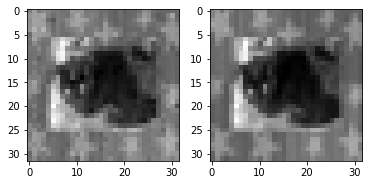

True label: 3
predicted label: 5
Time:  175.5259895324707  seconds
Initial fitness: 
 [-0.6001416158461221, -0.600102004304498, -0.6000605541815105, -0.6000913434485843, -0.6000118905266818, -0.6000819917339828, -0.6006513142763774, -0.6002213577942579, -0.6001723915760685, -0.6000828363025615, -0.600071400613373, -0.6002323843456249, -0.599997705213668, -0.6001139125265652, -0.600017648315543, -0.6000219020853484, -0.6003023212138473, -0.6001426316084932, -0.6002687002823288, -0.6001970051487688, -0.6001254658050467, -0.6002632571877352, -0.6002217094183062, -0.6001664901178043, -0.6003991627793289, -0.6000522518240778, -0.6001889311152019, -0.6001080556408467, -0.600357015038449, -0.6002078513654775, -0.6003950047158431, -0.6001717765479636, -0.6001489006031182, -0.600011802823049, -0.6002633980213916, -0.6000210273358135, -0.600094280024543, -0.6003702480625941, -0.6001245478887123, -0.600531081012882, -0.6002243914876273, -0.6002276288545207, -0.6006813542704698, -0.600188399046094

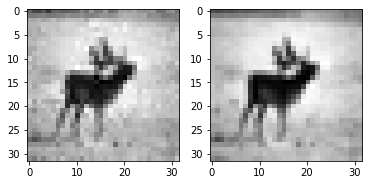

True label: 4
predicted label: 2
Time:  241.95631575584412  seconds
Initial fitness: 
 [0.7015642348199375, 0.7733584620883389, 0.7628027417216492, 0.6436204369839638, 0.7316518861634115, 0.6475946883575636, 0.7041122144823139, 0.6304424150526237, 0.6177862795046069, 0.6603525743419985, 0.6852408696074639, 0.6704564977049253, 0.36096946767701, 0.6861415540515785, 0.5233297878644781, 0.6369966942355885, 0.7131991580551905, 0.6427065721006904, 0.5782932216602503, 0.43421762689253085, 0.2284211624535106, 0.7675606534152323, 0.6634448450643797, 0.6842216409757507, 0.6129883836783602, 0.6373265124628418, 0.6298727446425268, 0.7220071928366366, 0.39700872367356477, 0.5979735326133288, 0.6766918139532221, 0.6347122502719986, 0.655781152383878, 0.7253546016967716, 0.694307139849433, 0.7283414885638091, 0.6683375374246281, 0.662398226517246, 0.6468832767995004, 0.45597436526352597, 0.48432919276138686, 0.6539449362740927, 0.7647448789372393, 0.6820189637082541, 0.6837137940805459, 0.49931032436

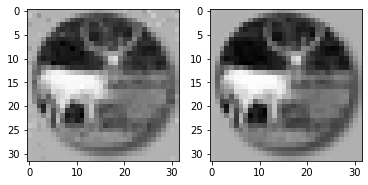

True label: 4
predicted label: 1
Time:  104.89725351333618  seconds
Initial fitness: 
 [-0.4853530829105247, -0.3779971966573078, -0.47367138704936684, -0.44986092646533565, -0.5264904032395819, -0.4523837426487335, -0.5028468564840005, -0.5005005213238141, -0.44786562224195575, -0.3421721939717924, -0.47293801953368386, -0.5149285775225633, -0.48509473173390083, -0.43616248900028187, -0.4379590679976037, -0.5020635305269315, -0.38282825857482344, -0.4802736116724139, -0.44020165244863996, -0.47969694201547863, -0.5288285679136939, -0.41274754167301997, -0.5021121152791075, -0.4781052784151204, -0.4786753824031964, -0.34279417179490224, -0.4368577835556079, -0.3415971413733968, -0.44064079876649864, -0.38098623843855556, -0.4641909334287255, -0.48477253493428996, -0.42937477637710225, -0.4913159488365215, -0.3517864976043248, -0.4510105280066006, -0.49607962970494945, -0.3529718315081236, -0.4849680705565328, -0.4190329003898601, -0.5243372653334226, -0.44488674398683226, -0.4529865302

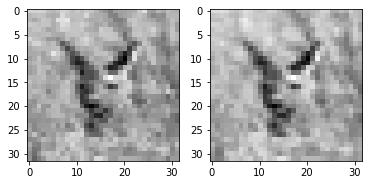

True label: 4
predicted label: 2
Time:  95.81064987182617  seconds
Initial fitness: 
 [-0.5902095291696152, -0.5981662546910145, -0.5944970522964507, -0.5970056702342761, -0.5899590478617213, -0.5915660107233259, -0.5834658040731513, -0.5914094189530585, -0.595066917793629, -0.594100974420098, -0.5927677069966779, -0.5894683388844385, -0.5925734857838048, -0.5924354200344362, -0.5893923326404087, -0.5919789769880557, -0.5903634973558822, -0.5935501634726684, -0.5931507486012118, -0.5952705643510359, -0.594010592246641, -0.5922575986098855, -0.5930396156099542, -0.5948153439658255, -0.5897446187632239, -0.5889341307245388, -0.5930418362446002, -0.5963866563333522, -0.5920886025484363, -0.5946867652330382, -0.5907233108485944, -0.5943795915911763, -0.5928316472055151, -0.5902342247710827, -0.596004985705545, -0.5925694732890199, -0.5900157805461058, -0.5904903426975271, -0.5957757408003919, -0.5921664086188996, -0.5937846133906692, -0.589091113598468, -0.5953821941431386, -0.590736660822

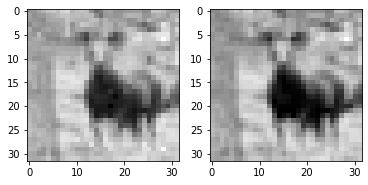

True label: 4
predicted label: 7
Time:  123.03126883506775  seconds
Initial fitness: 
 [-0.49304837301465304, -0.5078056467328311, -0.5599574707144204, 0.018789730538451843, -0.5408874075654415, -0.5792938112247918, -0.5478494864950347, -0.5249940087342592, -0.37870080619982055, -0.5033703803729106, -0.5155315754607612, -0.5057477944911019, -0.5247744013955193, -0.5277259309786477, -0.5191515113967934, -0.5633434709528593, -0.5168311058327268, -0.49868418328336583, -0.5252500224285118, -0.38146972065458973, -0.4945015715268437, -0.49209914116047804, -0.5919293737419686, -0.516157777412732, -0.48976958641700274, -0.5473638332826121, -0.5457131681275276, -0.45528469008541983, -0.5317952757444226, -0.5328815753990075, -0.44423212979016824, -0.4615125398238489, -0.521543444124254, -0.5108022615787859, -0.5413141662818604, -0.4586895073631526, -0.5437375396174523, -0.5022327589886548, -0.5099319718996662, -0.5559247958462084, -0.4709664637417307, -0.5744779490533438, -0.4882822746010023, -0

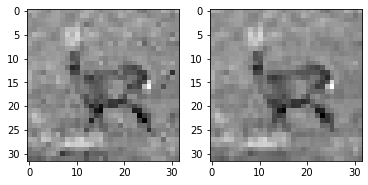

True label: 4
predicted label: 2
Time:  83.97836709022522  seconds
Initial fitness: 
 [-0.5959378193340252, -0.5957571025150931, -0.5952014871243215, -0.5883186998051595, -0.5850506647768554, -0.5871242768162114, -0.5920754146358522, -0.594963291909079, -0.596607849386381, -0.5896397322502693, -0.596026443449515, -0.5954793620988499, -0.592342956195245, -0.5898872479393362, -0.5966706722159102, -0.5959255843491776, -0.5980973096048958, -0.5942549641801951, -0.5944183860553454, -0.5960696131426867, -0.5968744646581644, -0.5934853717276499, -0.5889665466310718, -0.5873470888855647, -0.5873732748409947, -0.5960476205140918, -0.5981384211037706, -0.5944558132184311, -0.5889788587024779, -0.5948329151003942, -0.5964517207708758, -0.5960920163676653, -0.5911419422606888, -0.5963562663001086, -0.5940859470310115, -0.5956542031830583, -0.593618860610006, -0.5957869248277641, -0.5972963836206227, -0.5954706474605892, -0.5929408784444643, -0.5959917845365597, -0.5875488431170787, -0.591066622578

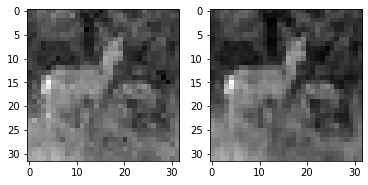

True label: 4
predicted label: 2
Time:  94.33585548400879  seconds
Initial fitness: 
 [0.36692941078173125, 0.5188298108738517, 0.2399642388782055, 0.3677144899304431, 0.24728857217508804, 0.44306757344857073, 0.18804988079289192, 0.32627146742766644, 0.22378247357780257, 0.1842559496294489, -0.14354854122586125, 0.45658028949680474, 0.00899413547914904, 0.4702851778863885, 0.450252234040249, 0.5888250081551507, 0.4208423691994564, 0.40706763625941556, 0.3224980489475482, 0.088120202433262, 0.4385995814182526, 0.1586931898202244, 0.2777187620152276, 0.11449400165086959, -0.19111324425307877, 0.04124141358787392, 0.24216498418048682, -0.024086925472977, 0.11841985185970122, 0.361384134672493, 0.3531884393372168, 0.37854866169465784, 0.25290214600360705, 0.5538346791802828, 0.5241075328433322, 0.4170361088705127, 0.4000345693180196, 0.27710249768199424, 0.2735504978992432, 0.32899670290468425, 0.06393038676248053, 0.27882988487909893, 0.5443829594146299, 0.2907736614260311, 0.43093159650

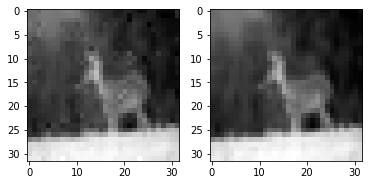

True label: 4
predicted label: 3
Time:  114.7424213886261  seconds
Initial fitness: 
 [0.9941376475932021, 0.9945189190715228, 0.9942322914051039, 0.9968857476094231, 0.9876382218046701, 0.9963860280389154, 0.9970480067391739, 0.9929540685890337, 0.9950063600153063, 0.9941605673210285, 0.9971696834536541, 0.9983061013593647, 0.9945202695763852, 0.9965615516470148, 0.994647895316125, 0.9970796312898652, 0.9943577595004571, 0.9956038276463082, 0.9940172499340734, 0.9961591577839009, 0.9954835207659932, 0.9966155095608095, 0.9951214534465804, 0.9967798638679515, 0.9974130239315375, 0.9971276531686291, 0.9959823890375334, 0.9961469528488522, 0.9960626015015204, 0.9965285927883608, 0.9975561590834083, 0.9969547717634817, 0.9970658736121769, 0.9965451575976174, 0.9938172883269576, 0.9956166033815984, 0.9975290455758068, 0.9962900901823319, 0.9939757999769973, 0.9932077928907359, 0.995161155891123, 0.989953784240613, 0.9957662996146319, 0.9897427107883443, 0.9957420363365969, 0.99592742029781

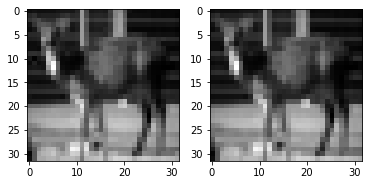

True label: 4
predicted label: 7
Time:  1.920302391052246  seconds
Initial fitness: 
 [-0.5641418126417062, -0.5609001510618578, -0.5830737607707834, -0.5840182318954925, -0.5624662275972505, -0.5761438484417847, -0.5586059867472734, -0.5736731431787218, -0.5650977729991454, -0.5518621724489934, -0.5603777290585501, -0.574828969702099, -0.5671105796461089, -0.5474432220752482, -0.5728646428394665, -0.5642209683422464, -0.5833367083050931, -0.5595151862414757, -0.5687038079787207, -0.5764675910718458, -0.573858104243575, -0.552766947734253, -0.5720266242666966, -0.5699674776265458, -0.552639144273348, -0.5741301466308599, -0.5735947764025258, -0.5607592951896773, -0.5747550062380765, -0.5671565275295657, -0.5633045221556441, -0.562158777786335, -0.5653356313253824, -0.5723704776579062, -0.5667937353507895, -0.5624863358554437, -0.5736456360717842, -0.5621287161286597, -0.5725706730987761, -0.5684966970963272, -0.5646011917236704, -0.5697153010452392, -0.5661123447782558, -0.574329392650

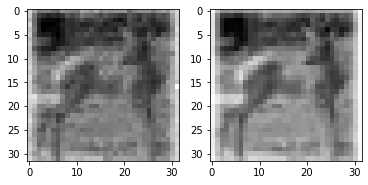

True label: 4
predicted label: 2
Time:  310.7298729419708  seconds
Initial fitness: 
 [-0.5946637203634376, -0.5915779242092526, -0.5927744425135736, -0.5934980648190735, -0.5930073649275731, -0.5921678297444417, -0.5947341701316096, -0.5914684104562564, -0.5949152637597782, -0.5950341438788566, -0.5929103551455792, -0.5952223057494869, -0.5970992997977036, -0.5947847240219131, -0.593515869786855, -0.5920495734427343, -0.5911117612698358, -0.5958339264918958, -0.5922311203658114, -0.594539061167307, -0.5819154902416082, -0.5933919751130203, -0.5935560001997073, -0.5948128611385619, -0.5939677221676397, -0.5935107857021715, -0.5926709036808243, -0.5933540067577955, -0.594039773960927, -0.5931751070799705, -0.5905737941204794, -0.5940110556375978, -0.5934729119557414, -0.5937800793100377, -0.5935893399282717, -0.5918139059535777, -0.5955501545144366, -0.5900229117551561, -0.5929492759618521, -0.5916833751713735, -0.5821881305578938, -0.5930641191975236, -0.5941068736624829, -0.5938688380

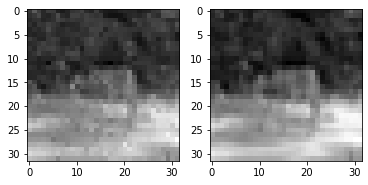

True label: 4
predicted label: 2
Time:  132.01822328567505  seconds
Initial fitness: 
 [-0.023382685221864485, 0.03320159424818803, -0.07655329363144589, -0.017680568266621455, -0.03628448178246904, -0.024852603703508724, 0.032562119785920995, -0.27576656076000616, -0.30318274274014495, -0.10843237196714395, -0.000788630559305642, -0.10199664483633969, -0.1536370334496151, -0.43489356128103296, -0.04320749924116343, 0.17786095882688727, -0.10701768315345295, -0.1325223159900607, -0.10977432839506815, 0.018786782572072752, -0.035268575355584586, -0.08369901582189707, 0.1030812306846339, -0.2524459877848264, -0.3044464914946341, 0.05154234253809192, -0.09519058200638753, -0.0813319062924355, -0.12827222237551478, -0.06230498918692223, 0.2750104208769223, 0.016376542356641766, -0.10598051855989069, -0.28698783147116724, -0.05258060871522699, 0.03549490841544384, -0.1971191637385299, -0.08442008206746504, -0.12457071440376988, -0.32776941225290657, 0.01948882540532071, 0.10358790484583237,

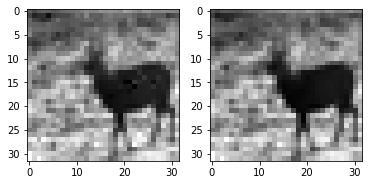

True label: 4
predicted label: 2
Time:  82.20175981521606  seconds
Initial fitness: 
 [-0.5931061609046735, -0.5951057981182188, -0.5963799851870297, -0.5957239073444782, -0.5935663973491145, -0.5949747522287757, -0.5944922782690879, -0.5955376175870318, -0.5932379448122738, -0.5885480817162647, -0.5969384065021939, -0.5960417223423722, -0.594904237196916, -0.5966427964551688, -0.5889605634451631, -0.5965527268535067, -0.5963686786089407, -0.5935960158520659, -0.5956595702659129, -0.5963793022773106, -0.5959158073205216, -0.5927062868679072, -0.59549495849945, -0.5976499970136218, -0.5959670743736425, -0.5900877030466137, -0.5965128787121394, -0.594689596977483, -0.5938710252295023, -0.5909712119578018, -0.5978976269315115, -0.5963476584539096, -0.5955983070278681, -0.5975116178705109, -0.5965750234470073, -0.5930272004829658, -0.5957107009639734, -0.5934807304574408, -0.5974764028655454, -0.5956692412604729, -0.5951416214859006, -0.5919676662741858, -0.5959365168864725, -0.59429907244

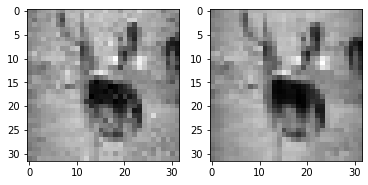

True label: 4
predicted label: 2
Time:  180.2111508846283  seconds
Initial fitness: 
 [0.4009340916121341, 0.4187818580185746, 0.6099046102425758, 0.3408673696238855, 0.28340756595374295, 0.46507382803094316, 0.39934051780738467, 0.49012335530705387, 0.3429155577433364, 0.4283960716847284, 0.3874738676412813, 0.47412981839517016, 0.49480375702245183, 0.42768918954536966, 0.26778026452330916, 0.4467374445937796, 0.4931687506835094, 0.41589955424413655, 0.09825743105715642, 0.31560826129566805, 0.35613130208449184, 0.3320194993771407, 0.3319888794146913, 0.38191747656834274, 0.3235538817666579, 0.37448636803471635, 0.3960244573665539, 0.3864982894882033, 0.4075394553650393, 0.4893380698721649, 0.40586137137277223, 0.265350324005478, 0.3302682756055536, 0.3880330842908486, 0.3323351731864338, 0.3697392411291204, 0.46145609901158624, 0.5348551890508639, 0.374114807767399, 0.38140999104146595, 0.4383203527236367, 0.32227815555674877, 0.3086620474112477, 0.4660576203447262, 0.210088799360475

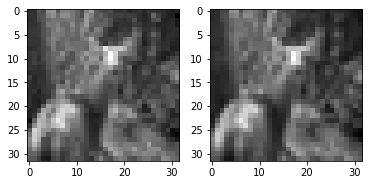

True label: 4
predicted label: 2
Time:  106.22584509849548  seconds
Initial fitness: 
 [-0.47606347774943536, -0.22498283692121418, -0.22074700589761917, -0.12617669076174565, -0.26174672017384637, -0.0884523710072326, -0.14812446146579428, -0.4327145670719761, 0.13052598096113727, -0.10274435620946137, -0.29620441607569525, -0.2939938466138552, -0.14780417985787636, -0.22792700310216735, -0.28712668429954186, -0.3374981988608294, 0.05030864486347991, -0.28973168200688143, 0.10386181510912601, 0.34261458023075103, -0.2327575876180485, -0.2800892956509691, -0.15292506698209746, -0.13246115061113364, -0.3196221189526951, -0.4059564814751433, -0.20526794867112141, -0.08528771383435249, -0.3827394844055009, -0.27244722484087003, -0.4300617484264948, -0.2916096534499001, -0.08081625612177368, -0.28814817686635585, 0.0501297517914753, -0.4279034878010418, -0.22452877617495778, -0.3908421983961801, -0.38469524912411246, -0.349403548056364, -0.3041472270351848, -0.4320907342303707, -0.31991563

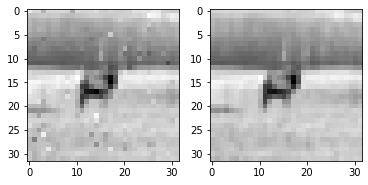

True label: 4
predicted label: 2
Time:  87.61346912384033  seconds
Initial fitness: 
 [0.027537543051304847, -0.11034782176357172, -0.2042567102771628, -0.2943742405553519, -0.09959989840105632, 0.41459193211384654, -0.01413633958461813, -0.3484210320529739, -0.38124935651948827, -0.19226869068582267, -0.1538908293286245, -0.11781221202733119, -0.21624773044410056, -0.31554893404175266, 0.007224220765025269, -0.13514129072265882, -0.15623066739581692, 0.31566830733317675, 0.04990168879552592, -0.10965019883257696, 0.2572127619871569, 0.10220211344126379, -0.28140112750011104, -0.020864425147390342, -0.23396306441426415, -0.23112307151141281, -0.23497279616152447, 0.03634117807000009, 0.038322106539541045, -0.1423994005822584, -0.045736943363250626, -0.11358211618467451, -0.035623859547549014, 0.35543024686456437, -0.08219008518090301, -0.1770323348218231, 0.020122706995934214, -0.10609879060610125, -0.18081483351680624, 0.2521167043224225, -0.23496574545319024, 0.10813558611374668, -0.

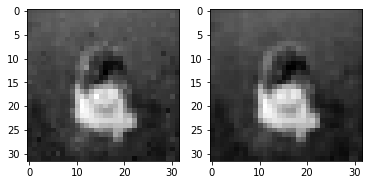

True label: 5
predicted label: 3
Time:  104.58802270889282  seconds
Initial fitness: 
 [-0.5830693596541964, -0.5849841540344313, -0.5859041643077394, -0.5828768210826722, -0.581330280551319, -0.582580004081555, -0.5883907167723205, -0.5822338213643096, -0.5795950763076587, -0.5877879279879439, -0.5770605063860503, -0.5881312531270928, -0.5857836136883474, -0.5862148191537987, -0.5870013302037397, -0.5826076655026744, -0.5866424034897963, -0.5906603488935696, -0.5914716424750752, -0.5897901775821095, -0.5864914576728733, -0.5689230632847487, -0.5906349779050956, -0.5819383420658978, -0.5868341390886856, -0.5852013133390503, -0.5777852270244968, -0.5837139741347783, -0.5877598589966426, -0.5807351307110342, -0.58547846488476, -0.5856681215148765, -0.5843745855324408, -0.5866201088385312, -0.5881979350832371, -0.5840715217619395, -0.5890625932729857, -0.577121408713888, -0.5796211659293649, -0.5839141195377434, -0.5793011129811603, -0.5788848584910612, -0.5848515044725413, -0.58676470686

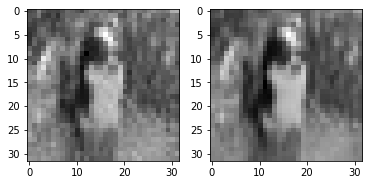

True label: 5
predicted label: 2
Time:  331.6677906513214  seconds
Initial fitness: 
 [-0.3419897020654157, -0.5045954789021541, -0.3218465546632111, -0.49246159428833214, -0.42266433009742166, -0.3671838761268602, -0.41648980201918184, -0.45891239911294746, -0.3768432944581088, -0.4793333865838898, -0.49914109915641025, -0.5051936568301214, -0.43442959965187555, -0.5260319961062202, -0.4533365331919279, -0.4311137647324801, -0.4489853977135163, -0.40013907932280013, -0.498885406870479, -0.3986508619866177, -0.4445808183127206, -0.37951975787397413, -0.28239041952249566, -0.46465372765003576, -0.30374752082470213, -0.4369490114875125, -0.45063255773835686, -0.5324331375261389, -0.3913346268064689, -0.3918311471653355, -0.40939545823066825, -0.10807476990697715, -0.38570811122767046, -0.4919663263310793, -0.4111608518789399, -0.43233899656451363, -0.39768610333577703, -0.49514006681453654, -0.3909378830407465, -0.39763867974577266, -0.5017417112001761, -0.43220609090844064, -0.470571851

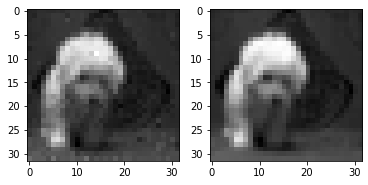

True label: 5
predicted label: 2
Time:  122.23801970481873  seconds
Initial fitness: 
 [-0.5881883398795978, -0.5837482538734454, -0.582103969980198, -0.5813106667365995, -0.5684759447795199, -0.5837711071045376, -0.5744067846109496, -0.5831138757476768, -0.577492399471748, -0.5865784397270557, -0.5852142855522988, -0.5847075727053799, -0.5812938136106368, -0.5900097248815286, -0.5883326808817341, -0.5786347135114664, -0.5861704263153263, -0.5838346623867542, -0.5838881271075623, -0.5723731396211605, -0.5864157895919178, -0.5860366710319962, -0.5673602057822028, -0.5832563771751953, -0.5823719832066252, -0.5865811186299439, -0.5851175131385088, -0.5799875262119503, -0.5850532672898074, -0.583126336971412, -0.5836014640026066, -0.5881833078240699, -0.5828191652232484, -0.572712809137476, -0.5846994593625102, -0.582113843455317, -0.580311286431825, -0.5734668737354578, -0.5843318829726243, -0.5821209996512506, -0.5853722852905661, -0.5868942096731217, -0.5783834302468369, -0.573758892419

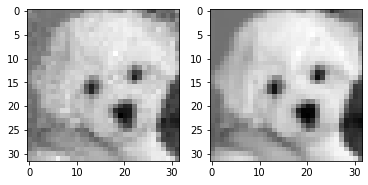

True label: 5
predicted label: 3
Time:  271.171010017395  seconds
Initial fitness: 
 [0.07068361251947733, 0.039476909507335484, 0.010442087635825631, 0.11988828832152282, 0.15860925910864765, 0.08371634292690477, -0.12023170188814497, 0.2805460062948384, -0.13345587960916433, 0.09271656288585799, 0.13635153798315303, 0.5068523877751798, 0.5404102484748116, 0.2532066556652527, 2.4380026488912687e-05, 0.2848244754761043, 0.03465887516233429, 0.15385451164976532, 0.07957309370097952, 0.16990157740618517, 0.04401128857889744, 0.05488796247523822, 0.13834494128400132, 0.3024772468357419, 0.17345853175426687, 0.11429177260336482, 0.4023171856120242, 0.18880491070913547, 0.2485525674240433, 0.09784743643470337, 0.01718578904536941, 0.0556231884619722, 0.0436351851164172, -0.12290474123588288, 0.16781422303314739, 0.2105768130849733, 0.18957977385167454, 0.23031323451373947, -0.028955912638731207, 0.1176173899222253, 0.10168167035575446, 0.1510139194016365, 0.3406498998057471, -0.171286079136

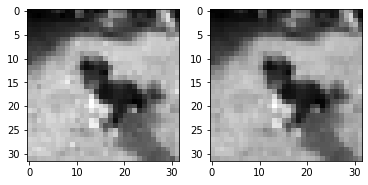

True label: 5
predicted label: 2
Time:  80.22575855255127  seconds
Initial fitness: 
 [0.04515464909865091, -0.13388180940742084, -0.046002595142521835, -0.2490417215554539, -0.04585381076135436, -0.15206725986046815, 0.023265971616810738, -0.15560375954683986, -0.2230932783049255, -0.13381744974596083, -0.00994816094983933, -0.11886465372371297, -0.07634336842478756, -0.07335065311539474, -0.08599445618040541, -0.09047109588619226, 0.16606653375137226, -0.15536002606057067, -0.059287974722416925, -0.1382350892812143, 0.13509435049330693, -0.07942859680991002, -0.06999434987892719, -0.031512816964798795, -0.1559940400844654, -0.09066871525960019, -0.027487131183476565, -0.259086053365542, -0.025412344942821935, 0.014227887834808856, -0.10427030265446163, -0.07021065787921038, -0.052979357897474766, 0.03627838101195882, -0.02723980130647527, 0.1228224048841284, -0.15672364955722637, -0.044156483411839476, -0.03892059100245682, 0.15796951038508494, 0.39464246778120793, -0.155557305568876

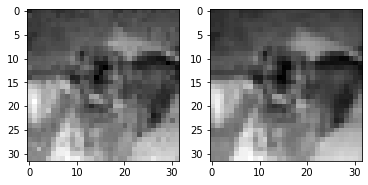

True label: 5
predicted label: 6
Time:  228.70570969581604  seconds
Initial fitness: 
 [-0.5990574083973113, -0.5996126157514736, -0.598887524364839, -0.5986200870753497, -0.5991141379288579, -0.5999528039609615, -0.5991209627979377, -0.5993811644324276, -0.5990929128018152, -0.5990673070039172, -0.5993633422160776, -0.5989387994098582, -0.599156479294984, -0.601480278540075, -0.5980120158635523, -0.5997797045408748, -0.6010533279092161, -0.6027255936970028, -0.6014279271755015, -0.5989971386434004, -0.5989714433423992, -0.6002620920969056, -0.5990846285551841, -0.5997051627296418, -0.5983193978739213, -0.6012591800889935, -0.5999483989510165, -0.598859601094899, -0.6009862553144802, -0.5984839552876976, -0.5993366808690328, -0.5989180297075003, -0.6011338085321047, -0.598812466515719, -0.598445653144603, -0.5993725343656273, -0.5987036819469063, -0.6015070072863152, -0.5984228092349015, -0.599492692694776, -0.5999936671735282, -0.6018680568728142, -0.5991806366461844, -0.5985910351569

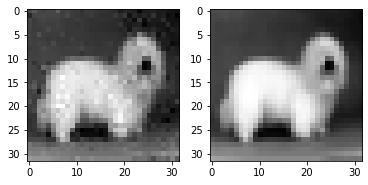

True label: 5
predicted label: 3
Time:  180.722962141037  seconds
Initial fitness: 
 [0.7522759352760818, 0.7488897872699097, 0.7329229129535705, 0.7127440387112074, 0.7374721079405582, 0.7892570062029567, 0.7384486950977771, 0.683350332349749, 0.7142065685525172, 0.7149059661416954, 0.7282313394525223, 0.769471140131571, 0.7681826493501116, 0.7323976639639702, 0.7866105084414191, 0.7178324318593776, 0.7462035575749552, 0.7298224474150736, 0.7535685122309226, 0.6766973284714348, 0.7276436373073775, 0.7488765185015478, 0.723214722827806, 0.6781472711579825, 0.7539996350573608, 0.8030690835792377, 0.7605993909208102, 0.7261553969978235, 0.7097313402333333, 0.7402937663056529, 0.7670772521268134, 0.7254758189909316, 0.6935057220382215, 0.7311105153599293, 0.7260440089180882, 0.7448401370299329, 0.698417421051024, 0.778493545444442, 0.6796970013350394, 0.7042978110887965, 0.720996989912842, 0.7026523091301986, 0.7732683891173293, 0.6726515585843993, 0.7241318984438119, 0.7736803773675146, 

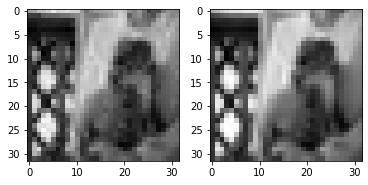

True label: 5
predicted label: 3
Time:  228.60467791557312  seconds
Initial fitness: 
 [-0.2856399716059713, -0.2580886674930676, -0.2783481266618559, -0.36811127704758584, -0.18661605416713672, -0.2628762737373383, -0.23530974219903916, -0.3864654126433833, -0.2791537011651528, -0.4541982362407736, -0.33232724724435647, -0.30732366416133255, -0.4232919850516699, -0.34983408282233064, -0.29985286295723707, -0.3228488472139298, -0.41053210514709615, -0.34096350037611767, -0.3841126948330478, -0.29742720161563113, -0.3490811620498914, -0.3504901841759394, -0.330475402461778, -0.3692013278311207, -0.30979602647246973, -0.3375982225712989, -0.37277011936862503, -0.3280605811856342, -0.35850350280161836, -0.3176999524577683, -0.35079994231866973, -0.33732991165788684, -0.2992719708472531, -0.35238857484751795, -0.36397528186936456, -0.3660564602609728, -0.3586006751800649, -0.2931929458721315, -0.35951956100982896, -0.36255799062981897, -0.462152858171027, -0.33344136269995606, -0.327015133

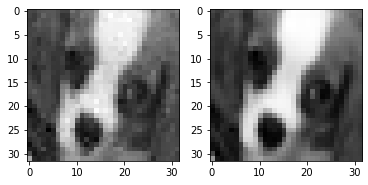

True label: 5
predicted label: 3
Time:  237.44994378089905  seconds
Initial fitness: 
 [0.2485799034449234, 0.1297950470184743, 0.18209643818669638, 0.13618301422193052, 0.14127529117682538, 0.16938548830505518, 0.3103243046434619, 0.14298293371567217, 0.15107877593139862, 0.1828272351140349, 0.10477387230041704, 0.24370096204987313, 0.24622248768139723, 0.15347182147261698, 0.2619777962053745, 0.1989097820412758, 0.14178150603694775, 0.11005711308775837, 0.1427209258860963, 0.1585316927464741, 0.23513298578510453, 0.142971426333517, 0.18193459299048653, 0.24959377819921674, 0.07271031860917279, 0.21373326359010647, 0.23278851228986613, 0.3053386913435957, 0.13310876773791502, 0.1706499299892812, 0.23560380948876677, 0.18604783589625273, 0.18473019986687603, 0.05498194284362859, 0.2048268774464119, 0.21034470400321942, 0.13029130200721334, 0.19316324445148517, -0.059924370799638665, 0.0679684892624084, 0.24907929568026155, 0.2605054546830766, 0.27137998615897824, 0.20724982275746404, 0

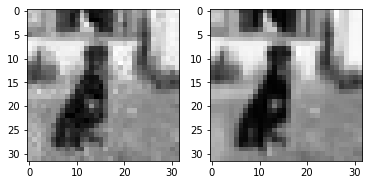

True label: 5
predicted label: 3
Time:  291.709121465683  seconds
Initial fitness: 
 [0.5034316455628163, 0.5740938147285946, 0.5019209907626686, 0.6447477436847566, 0.5478262683365157, 0.6510408051492375, 0.6248656312185886, 0.5895687576649062, 0.5518024426257231, 0.6646072694073671, 0.5278637223508961, 0.5952638623618178, 0.5412298707059578, 0.49520483171734453, 0.5211188439292238, 0.6372879342326014, 0.5294402493102419, 0.5883962304768177, 0.6560360670185197, 0.653067153126106, 0.5009979717016979, 0.6436009862796238, 0.5776099840043032, 0.6270520852755476, 0.5760307988389093, 0.511507614874273, 0.6177736304246604, 0.5728068911944206, 0.5537865543055482, 0.5967182207563334, 0.5220637169519733, 0.5984621652638087, 0.5461142659545353, 0.3743906248690582, 0.5749670666465977, 0.503211961959565, 0.6949922412658371, 0.5273884528112193, 0.5049898468475489, 0.5988476911729295, 0.5574942510704046, 0.5642142271448976, 0.5980494243592068, 0.5039406378505092, 0.5869684448145498, 0.52389985666300

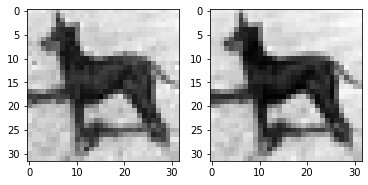

True label: 5
predicted label: 7
Time:  214.7585964202881  seconds
Initial fitness: 
 [-0.6000465458927136, -0.6000005365877832, -0.6004726795562267, -0.6000353970429727, -0.6000687236266541, -0.6001906216896804, -0.6000026751382089, -0.6004445319117866, -0.6001496584388818, -0.6000593319190535, -0.6001261241516116, -0.6001087263003213, -0.6002804539201283, -0.6002198973767956, -0.6001236340263241, -0.600836165889384, -0.6000169269510448, -0.6000422732926718, -0.6000197785326062, -0.600117074547629, -0.6003666552624556, -0.6000652598175712, -0.6000476795797758, -0.6001130549030651, -0.6003367844041666, -0.6001255957522371, -0.6004304677688286, -0.6002874007668547, -0.6006346790766524, -0.600002504334266, -0.6004202761859518, -0.6000870469873594, -0.6000418480809339, -0.6001091110706216, -0.6003100315160996, -0.6001352371969941, -0.6002754288212399, -0.6003957363433583, -0.600115572470459, -0.6003899341944284, -0.6001740635104809, -0.6008362563184064, -0.600017566888081, -0.600051855521

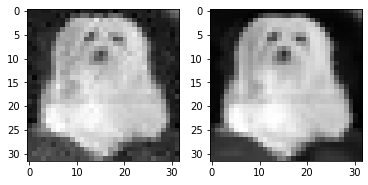

True label: 5
predicted label: 3
Time:  282.97311067581177  seconds
Initial fitness: 
 [0.3170424096444462, 0.3567439222553266, 0.197137642677968, 0.2531754092106099, 0.3321041521582516, 0.3316392097084804, 0.3170822187796123, 0.040633345188660464, 0.23453988639816542, 0.33324135400811583, 0.35702782338130756, 0.3135954571553622, 0.39013924556678714, 0.28232075213554386, 0.35979811146790497, 0.28115227617873884, 0.13113843570788458, 0.27536300296681276, 0.37670975939572704, 0.3367244629278052, 0.35837133238931684, 0.40970652446290307, 0.3176413367215004, 0.3663996723565213, 0.4244188361049492, 0.3271006712573057, 0.3131826741140258, 0.3181416299565785, 0.288739725353729, 0.37696868301482184, 0.4216825943299377, 0.3283788239766172, 0.26400161357193774, 0.3818904177187411, 0.1451121431197018, 0.2933688707511716, 0.22230928095386898, 0.3115970728325012, 0.2850777529125191, 0.3572184144761421, 0.3480572395804532, 0.35828602017366507, 0.2919720619943643, 0.30711220120269295, 0.3533715033936

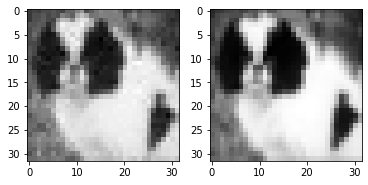

True label: 5
predicted label: 3
Time:  264.395126581192  seconds
Initial fitness: 
 [0.3355384918859767, 0.3290474920417476, 0.2968663246922816, 0.4140333312507384, 0.3447733972370147, 0.29859474458701096, 0.49137883969592544, 0.47738180106624745, 0.334561048396889, 0.3126861440011396, 0.38926718444893793, 0.5526895162381154, 0.3387475748470019, 0.1864100560616132, 0.3903009882402105, 0.3647953231656927, 0.7408951789729488, 0.3742237213812528, 0.5431118802987798, 0.3279067704054468, 0.5505221536475751, 0.5748684037901752, 0.24513105168964552, 0.3793564343673831, 0.47105209869486225, 0.4178691216526901, 0.5174671032550913, 0.42933785628910714, 0.5094665922890104, 0.10096646888817307, 0.3879442857536135, 0.4901162389885698, 0.3298166969421681, 0.3293738292056607, 0.4896631593862567, 0.20743453035712905, 0.3795257139774383, 0.4085365015814463, 0.5907003387955309, 0.6604797011524804, 0.4010447796663293, 0.4220020978849505, 0.3125505347510631, 0.4420765749654722, 0.13540756638567003, 0.602

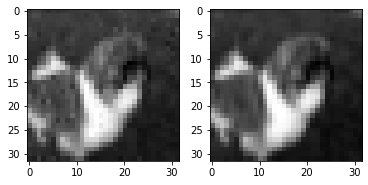

True label: 5
predicted label: 3
Time:  121.94319176673889  seconds
Initial fitness: 
 [-0.6001192528882808, -0.6000156143667632, -0.6001323734046933, -0.6001960765935224, -0.6001982755280934, -0.6001910325717152, -0.6001850380211946, -0.600545985291259, -0.600113872043518, -0.6004918580946914, -0.6003710406646149, -0.6002424582539074, -0.60013901564122, -0.6001854578874304, -0.6007740866153186, -0.6001302943577819, -0.6000530172154083, -0.6000989359359395, -0.6001664911860074, -0.6001333004507978, -0.600209743107872, -0.6003816770754093, -0.6000393092503403, -0.6002483345117481, -0.6000862248042872, -0.6008880281247818, -0.6001180542645156, -0.6003356653955534, -0.6003031565745064, -0.6002272256294359, -0.6000945901998461, -0.6004111995753568, -0.6003445565784034, -0.6001639480635825, -0.6003640445906149, -0.6002686823993417, -0.6000247874551425, -0.6004007412505495, -0.6003141119170455, -0.6007026390322651, -0.6004609425016633, -0.6003575823257727, -0.6003195165512599, -0.60010621707

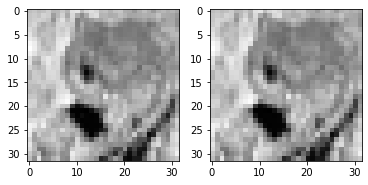

True label: 6
predicted label: 6
Time:  60.83423161506653  seconds
Initial fitness: 
 [-0.541287097319248, -0.5433032358497336, -0.5627179467533114, -0.5740417162686478, -0.5311336125997107, -0.5515271140760337, -0.5277964198275797, -0.5500788317816236, -0.537928825114081, -0.529963086070975, -0.569616163492008, -0.5359306198208095, -0.5836386773337492, -0.5548042896548492, -0.5537513723812016, -0.5391418028410462, -0.5350634891537724, -0.5575635224328077, -0.5508938900613757, -0.521699516411632, -0.5531084532407531, -0.5172803323212481, -0.5383215635888574, -0.5608765049666486, -0.5399447724659574, -0.5515885878513036, -0.579624379518733, -0.5530668437926438, -0.5519635389310024, -0.5558107495301187, -0.5234776151980627, -0.5485681281432958, -0.5692835034385529, -0.5459360805294574, -0.5616128178582321, -0.5445373318246174, -0.547858851400912, -0.5503985733793892, -0.5650299994262522, -0.5553204499675674, -0.5708094464071799, -0.5090836624955938, -0.5449596673683561, -0.56694870465947

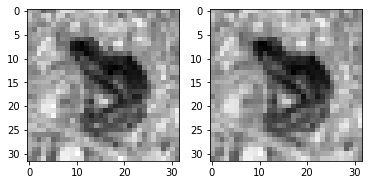

True label: 6
predicted label: 2
Time:  142.62324166297913  seconds
Initial fitness: 
 [0.526244236375553, 0.5469421217542476, 0.5100035455391005, 0.587133465686726, 0.5340783696600058, 0.55609321047035, 0.5701957875476974, 0.5816757094270693, 0.6121912791428233, 0.5848872502181728, 0.5418883761697428, 0.5643776059314195, 0.5919340822664281, 0.5974764918887363, 0.5694606523621527, 0.666959651312139, 0.5615748491604285, 0.5505867781700852, 0.5801904191468192, 0.7045908477091782, 0.5216954421077233, 0.6076272751235744, 0.5915767361193472, 0.5306646650049597, 0.48728867571547174, 0.5661768001394767, 0.5659737027369509, 0.5745929263832508, 0.6414414641672734, 0.5857608919660104, 0.5222319859956437, 0.6408967772736361, 0.5174145566959756, 0.5359365849327857, 0.5418564690162293, 0.5305284642392013, 0.5128011166799353, 0.5709755217557748, 0.4381813581739873, 0.5267360305248413, 0.5937463168694219, 0.512810450865185, 0.529271909919411, 0.5834960389025049, 0.4762511023179583, 0.4861148427921906

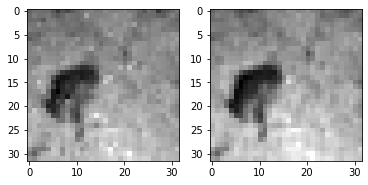

True label: 6
predicted label: 2
Time:  125.82330226898193  seconds
Initial fitness: 
 [-0.5995386023310623, -0.5997404308212397, -0.5996751574311209, -0.5997505916333123, -0.5994217542712912, -0.5994959982471573, -0.5997116293384902, -0.5995773036527363, -0.5994961450648396, -0.5994176504914532, -0.5997336822644631, -0.5996574138548527, -0.599638091854173, -0.5995357804181785, -0.5996725165302723, -0.5994719878047117, -0.5995643727829187, -0.5995777491841461, -0.5996956504140176, -0.5996499399711205, -0.5996258455112644, -0.5992961906415069, -0.5996955576143104, -0.5993915533342988, -0.5995754022936526, -0.5996707939058865, -0.5995328651232641, -0.5997440309765361, -0.5996921277474787, -0.599696829245764, -0.5998028670500205, -0.5997431706744205, -0.5999468301327434, -0.5996349600412627, -0.5998510922934968, -0.599515397044054, -0.5994963063273466, -0.5996325710315868, -0.5995692294499397, -0.5996442351465723, -0.5995890360232891, -0.5996211201896411, -0.5994415713621546, -0.599650108

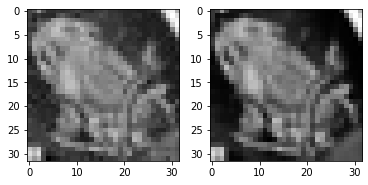

True label: 6
predicted label: 2
Time:  374.1999354362488  seconds
Initial fitness: 
 [-0.5992078228825757, -0.598751499267758, -0.6094880541874356, -0.6103792440530573, -0.5999594688215601, -0.6004023789524047, -0.6031800387857438, -0.5962492179976182, -0.5981600397013407, -0.6013789577264863, -0.613956625850103, -0.5960515164948446, -0.6007331751225754, -0.6040024436695404, -0.5988859937325081, -0.5979457112558553, -0.6067558064957052, -0.6016026380009617, -0.5987585102300901, -0.6048533184241123, -0.6051940794056115, -0.5988032484669956, -0.6034758683299238, -0.5994514465879135, -0.594844755566738, -0.6012271168345582, -0.5967280028771076, -0.5992472372748568, -0.6003301394499614, -0.6064893442109767, -0.5976436745910612, -0.6065789366542842, -0.6047661218867282, -0.597897583222661, -0.6046833627423674, -0.598911752386458, -0.5998093140401386, -0.5969729489480136, -0.6045205314837704, -0.599150444222601, -0.5971012903196555, -0.6025768087768695, -0.5969628962550013, -0.6077088662587

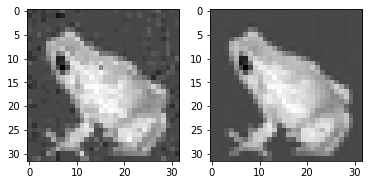

True label: 6
predicted label: 2
Time:  217.22973823547363  seconds
Initial fitness: 
 [-0.49382716461864434, -0.5315914443541482, -0.491567516910949, -0.4747343117004371, -0.4438871592535311, -0.48573637387193225, -0.4727422667656628, -0.5311378764432088, -0.4713128052585943, -0.5305808492211994, -0.48585140587962605, -0.48600903071738755, -0.39730115636427066, -0.5376811905268286, -0.5070724957986258, -0.45398209294687186, -0.5541663082103091, -0.5235529393203215, -0.5168189435916908, -0.48038395183938964, -0.5083535844753652, -0.4857908788076464, -0.465573288402904, -0.5184722062394824, -0.5210270293666469, -0.4754573608767023, -0.46685541528014746, -0.451732331332627, -0.46498093547185665, -0.4933899420418849, -0.47273403134175124, -0.4747850595227857, -0.4778184922419487, -0.45874245729375296, -0.5130892345419493, -0.5054741753012961, -0.50380229387385, -0.47344433081616316, -0.44696248902432256, -0.5149084237577604, -0.5368217003331531, -0.5298407623984318, -0.4751951660772367, -

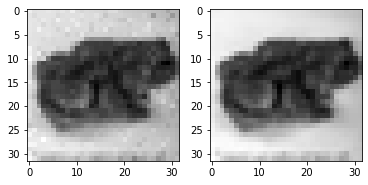

True label: 6
predicted label: 3
Time:  192.24362754821777  seconds
Initial fitness: 
 [-0.5992144865936901, -0.6003916739941287, -0.5996255058469542, -0.5994477447719356, -0.5995499567275117, -0.598508902021906, -0.5994988257131734, -0.5981420280444616, -0.5997588969359592, -0.5991479668374494, -0.5991388035087574, -0.5995307499312037, -0.599828191530676, -0.5997608937376218, -0.5992266354631527, -0.5990840565780445, -0.5998974130469903, -0.5993643926036053, -0.5992290997579888, -0.5993411158611848, -0.5980059534284519, -0.5987714137045401, -0.5986854355861394, -0.5992925504201831, -0.5991482069871473, -0.5995791811356335, -0.5991693295521683, -0.599082263452317, -0.5991604546229561, -0.5988759927009699, -0.5996756757505857, -0.600029636568038, -0.5993566431662296, -0.5991688471614923, -0.5990234341557128, -0.5994629165086038, -0.5987459610120895, -0.5989480971119671, -0.5989524274074652, -0.5995543271788479, -0.5990986698089756, -0.5984302006817833, -0.5999922288368582, -0.5990964434

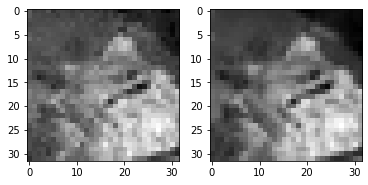

True label: 6
predicted label: 2
Time:  319.5515367984772  seconds
Initial fitness: 
 [-0.12597922148130863, -0.09870817293325088, -0.18997649824222512, -0.05975860211434664, 0.0002379509651393441, -0.19787976219990677, -0.2881134211124025, -0.03565365680529853, -0.34671702410987093, -0.1370704065376733, -0.12492077245524336, 0.012865227457942913, -0.130546499996839, -0.062273953146445016, -0.2752498944061492, -0.14229673548160318, -0.05123184864590938, 0.038604946957737196, -0.13131852827993556, -0.20282974946799157, 0.029664439490438232, -0.02412441387623515, 0.04016951472219346, 0.06770645227355127, -0.19178266597786447, -0.10434073439555344, -0.31777830789583117, -0.13033336550160077, -0.06819230790320502, -0.22332598165950915, -0.09445092879331476, -0.060598599933910396, -0.18025869345321716, -0.24718585591569353, -0.38412627507329666, -0.08428918161610838, -0.00394139592333545, -0.351716482994338, -0.11610580113427083, -0.3116256115142705, -0.0289955361443531, 0.01683858436353855

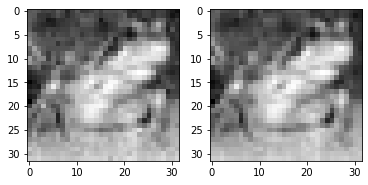

True label: 6
predicted label: 4
Time:  134.9393482208252  seconds
Initial fitness: 
 [-0.5998016375319069, -0.5998358900901832, -0.5998984661949511, -0.5998116088149763, -0.599825008719423, -0.5999421313464521, -0.5998400310897447, -0.5998817733870359, -0.5997905087236785, -0.6000825882457811, -0.5999294368686343, -0.5998139788689643, -0.5998580542315012, -0.6000066735547032, -0.6000360391407853, -0.5996961060380719, -0.5999611819729419, -0.6000417382588081, -0.5997772456327334, -0.5999704642282859, -0.5997726672573358, -0.5998118506358865, -0.5997553876994317, -0.600089378325181, -0.5998431086976324, -0.5998108926177754, -0.5999835655807576, -0.6000337067518404, -0.5999139304388839, -0.5999272995612666, -0.6003553151021237, -0.5998895325721438, -0.5999814244080419, -0.5997605031679208, -0.5997556887901568, -0.6000159677319877, -0.5998258255706321, -0.5998168776872155, -0.5999741330800301, -0.5998645616925752, -0.6000586332106598, -0.6000040465016984, -0.5999392187461793, -0.599989081

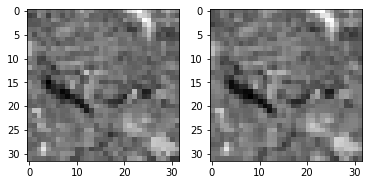

True label: 6
predicted label: 2
Time:  456.88603353500366  seconds
Initial fitness: 
 [-0.5906176194435807, -0.5952553835064016, -0.5887297605444013, -0.5964228131340653, -0.5878934737061359, -0.5827130507972256, -0.5894050469492111, -0.5863354965829437, -0.5891457031064115, -0.5894571182708659, -0.5954829534279791, -0.588608615478724, -0.5902865772665901, -0.5870201859290933, -0.5831737108790305, -0.5903755763684724, -0.5854403603603415, -0.5935665059134272, -0.5907388878706219, -0.5908409410374116, -0.584999873825677, -0.5869380402832057, -0.5921679115682676, -0.5915471630107734, -0.5869047608652103, -0.5876299156584697, -0.5934265778343749, -0.5862310222887865, -0.5890920261313158, -0.5866787177360797, -0.5899601186943308, -0.5921725224435204, -0.5868281760358186, -0.584729149935942, -0.583799514303943, -0.5933062767587677, -0.586899615794944, -0.5909999891202291, -0.5861948400776824, -0.5874416722833841, -0.5896298590906239, -0.592741601285742, -0.5836950188008718, -0.588521283252

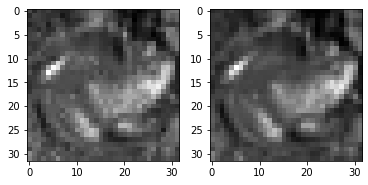

True label: 6
predicted label: 3
Time:  183.1697313785553  seconds
Initial fitness: 
 [-0.5983319113157753, -0.5976138932632373, -0.5978246167105271, -0.597324225525294, -0.5987926563935366, -0.5978401061838006, -0.5980138831330895, -0.5974593354672603, -0.5976326282253621, -0.5964139192437095, -0.5979099312011771, -0.5967311038710589, -0.5977281352788425, -0.5984089201860824, -0.5971070470161233, -0.597981735560714, -0.5982136901169053, -0.5973759198152241, -0.5985729149999109, -0.5976179216635608, -0.5982847719799865, -0.5981238904280133, -0.5977315364583231, -0.5975094573071527, -0.5980359696452745, -0.5977006464540106, -0.5976352419874786, -0.5977942474835688, -0.5983349774432791, -0.5980342796762557, -0.598177827295718, -0.5978885196176825, -0.5980686286034412, -0.5975217569193175, -0.5971270489272734, -0.5977848190034283, -0.5982669775176706, -0.5985045848215783, -0.5976480808949916, -0.5984632218599641, -0.5980783633629105, -0.5970802774569801, -0.5978797230532122, -0.5983755678

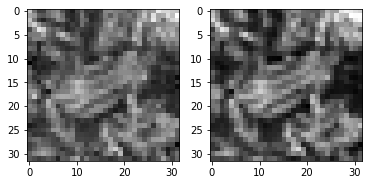

True label: 6
predicted label: 2
Time:  689.0073523521423  seconds
Initial fitness: 
 [-0.5954448018350661, -0.5958955696968088, -0.5974581190298202, -0.5977078509439988, -0.5960297557737808, -0.5961044051667882, -0.5962203791468166, -0.599354750187072, -0.5961268490523645, -0.5982755738824516, -0.596611081682315, -0.598889577684768, -0.5954833333828177, -0.5965288429958029, -0.5981709699099207, -0.5957998020589887, -0.5978747925562792, -0.5945839709190939, -0.5962672552506681, -0.5994752816887048, -0.5975021371524103, -0.5975005374621319, -0.5982999276522012, -0.595109848754248, -0.5980666671479936, -0.5950669557663433, -0.5965005834327562, -0.5993059029321687, -0.5942214607890565, -0.5983042065508838, -0.5983159988162842, -0.5982114332616554, -0.5971285295106126, -0.5959678963868289, -0.5961357812509915, -0.5971952316334544, -0.5958986002229661, -0.5958301348277446, -0.5946571282770067, -0.5927778913290375, -0.5978370712448872, -0.5969468584505915, -0.5971054924595902, -0.59403221668

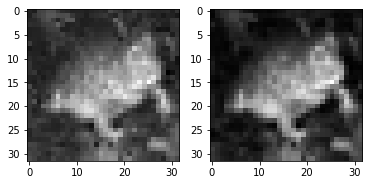

True label: 6
predicted label: 2
Time:  159.45363974571228  seconds
Initial fitness: 
 [-0.5990630165582439, -0.5982495327252215, -0.5977007420475343, -0.5987329553167156, -0.5979723835285273, -0.5978030959904794, -0.5991108360245884, -0.598794542182394, -0.5978820820686108, -0.5986304819251785, -0.5989661169288087, -0.5982079636030144, -0.5981643823423858, -0.5977253436096549, -0.5990092488691532, -0.5989238107903724, -0.5986894465789578, -0.597639903550558, -0.5982407725364899, -0.5980913894438539, -0.5979345788493561, -0.5977795991605502, -0.5984905401122678, -0.5982143350381404, -0.5986362780973727, -0.5982524802055575, -0.5990599121208418, -0.5965761843042413, -0.5992632454299995, -0.598867136214026, -0.596774373156302, -0.5980295435466695, -0.5968777898838971, -0.598512297274101, -0.5988290661902135, -0.5976448228093713, -0.5974522877181603, -0.5979872571377136, -0.5983421316274561, -0.5980440399927547, -0.5980979121292291, -0.5979716751432931, -0.5983491499354829, -0.59949683438

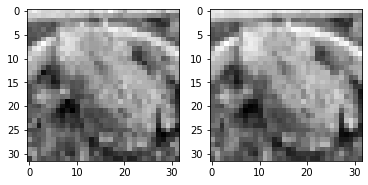

True label: 6
predicted label: 2
Time:  321.6504168510437  seconds
Initial fitness: 
 [-0.6009670988642302, -0.6011728889074204, -0.6011526040483812, -0.5992129052356772, -0.602455054357064, -0.6020588868062833, -0.6001839143700425, -0.6004957603186044, -0.5997448787563455, -0.6023230063723575, -0.5994671979540906, -0.6015857320880482, -0.6005284664502972, -0.5992412393010008, -0.5992782755632445, -0.6005480534317544, -0.601190310407427, -0.6031235574922066, -0.5994251888489452, -0.5992964706588233, -0.6000817968390743, -0.5998336067319299, -0.6016616693973112, -0.6024152308305298, -0.6001797853067083, -0.600893093111755, -0.5996512093911202, -0.5999065415912515, -0.6015992530291715, -0.6015530232608292, -0.6008160372031713, -0.5994738565639234, -0.5996907934463165, -0.5996223507431114, -0.6008268903191769, -0.6018042061359978, -0.5997205821368216, -0.6025449781726223, -0.5994685709718144, -0.6022766605924905, -0.5993969470733576, -0.5995754645530926, -0.6012162067442178, -0.6003369413

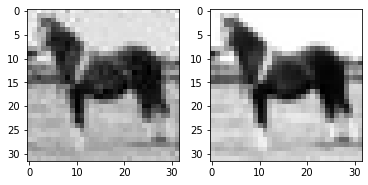

True label: 7
predicted label: 5
Time:  469.7546443939209  seconds
Initial fitness: 
 [-0.6006831132821839, -0.6031537780512612, -0.6005262356729857, -0.6030049965437895, -0.603624584578663, -0.6005149930139911, -0.5998430832671131, -0.6061762091022652, -0.6007585910840789, -0.6027302887543116, -0.5996040705225376, -0.6014378478511841, -0.6102530754864055, -0.5986144280147376, -0.6054669854367761, -0.6038751452264124, -0.5996285613887734, -0.6053117114173588, -0.6033304884605762, -0.6073126103040233, -0.6012003819169139, -0.6020888008462579, -0.5997842901697162, -0.6042477005765744, -0.599233116928586, -0.6003845398476034, -0.6039311733948359, -0.6024283877792452, -0.6029480869873873, -0.599800604084639, -0.6003077453468608, -0.6010432036236592, -0.6001215800199488, -0.6008757613685958, -0.6027897848812236, -0.5995565313627603, -0.5992272753138344, -0.6026655768963858, -0.6034493538044585, -0.6017486878118862, -0.6009247339463755, -0.6041761092199085, -0.6046396796567207, -0.5998287427

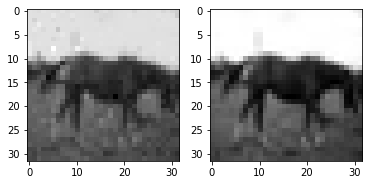

True label: 7
predicted label: 4
Time:  167.9850468635559  seconds
Initial fitness: 
 [-0.6013720037238558, -0.5998382663611865, -0.5998484500194404, -0.600494476711049, -0.5999216613479157, -0.600069026579741, -0.6001470749051966, -0.6000250439424948, -0.5999618526287342, -0.5996427887751992, -0.5996530137257248, -0.6004982155877111, -0.6006163020535791, -0.6002819636756874, -0.600248867890655, -0.6009819371164615, -0.6015539643724797, -0.5995725750667623, -0.5996850451596505, -0.6001965577322986, -0.5995940961427266, -0.6014700459263757, -0.600605961052894, -0.6002458683612516, -0.5998234767158751, -0.6003701543259492, -0.5997615351314292, -0.5998251253893144, -0.599697821224791, -0.5995778118868225, -0.5997006469463655, -0.5999879880811925, -0.5998360408497106, -0.5993931506542537, -0.6001471382950271, -0.5997141283636648, -0.5998044849322585, -0.5997740520664028, -0.5998333742541676, -0.6006588615598789, -0.6012742189287272, -0.6002482634710656, -0.599753069882686, -0.6004054102144

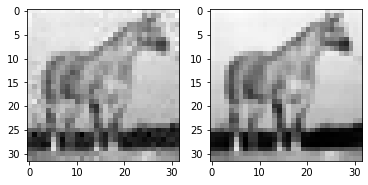

True label: 7
predicted label: 6
Time:  355.33801770210266  seconds
Initial fitness: 
 [-0.5466883830842504, -0.5541694784597289, -0.5182650977821441, -0.5130930155381265, -0.4707592883553422, -0.49866806518300477, -0.5561461828450368, -0.49259468195650846, -0.4897653009013586, -0.4507658865616325, -0.5211216896412076, -0.527254182487617, -0.512306114719425, -0.4282391463953851, -0.5097273096015843, -0.5225228642014049, -0.5408311646361115, -0.45976958559636816, -0.4929921664930724, -0.5346856872316057, -0.5124482163150443, -0.5222973985715926, -0.5104727638567921, -0.502121393326955, -0.49046675711689125, -0.5207757833640232, -0.5053604714931643, -0.4874599038063119, -0.49631750357394866, -0.5458036522131471, -0.5050918954759619, -0.5468783932124223, -0.5230322248543323, -0.5111068311930864, -0.5324562172643078, -0.5195905987832984, -0.49542118140365454, -0.5026589654896666, -0.48508293567986954, -0.511775821457563, -0.5101858094781141, -0.503212032480059, -0.5461561218885831, -0.5668

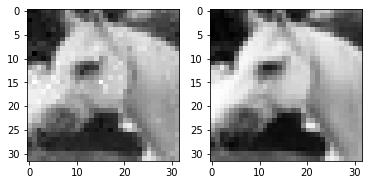

True label: 7
predicted label: 3
Time:  195.8554127216339  seconds
Initial fitness: 
 [-0.49725465673766855, -0.5014893683456187, -0.4006578657602703, -0.47339731219793313, -0.46013654179500263, -0.49986589651295776, -0.4864033536438871, -0.45496845537670993, -0.4624533439122084, -0.52428450826262, -0.4540401671269715, -0.36825753837378394, -0.4927936454120121, -0.46710833955555364, -0.4435422975132002, -0.4946650170836375, -0.4868169321226967, -0.38833035539707195, -0.5275810509246277, -0.4762895891117883, -0.4940587697610802, -0.43980021870353614, -0.4068575811351869, -0.5173172229501758, -0.5074166315332295, -0.4707465628039387, -0.3744796221040669, -0.5060490319321589, -0.5014966696666159, -0.4913631128541063, -0.5050404687221701, -0.4283970812060721, -0.4071942083440534, -0.481603349994733, -0.4978811113567697, -0.46785267797428726, -0.31329919403564666, -0.4987720952579172, -0.4545683837478822, -0.5160441077161978, -0.47911122514324866, -0.520623653361285, -0.39958202571912776, -

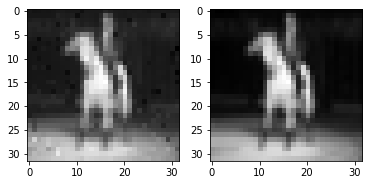

True label: 7
predicted label: 5
Time:  132.5674695968628  seconds
Initial fitness: 
 [-0.6000782096179237, -0.6003014819391641, -0.6004038269270531, -0.6003518242006622, -0.600110375829808, -0.6003954560053469, -0.6011637183519728, -0.6001457874132243, -0.6002606955892575, -0.600336068845547, -0.6003738326263781, -0.6005856332738885, -0.6000272380066549, -0.6007312501799705, -0.6007607144445937, -0.6001821223635471, -0.6000939860928634, -0.6005047640372385, -0.6000096123591796, -0.600391600782501, -0.6000815764714142, -0.6005929403906669, -0.6004092909278614, -0.6001507435923565, -0.6008932372198439, -0.6004630391510049, -0.6004767111286498, -0.6004304804055792, -0.6010059398880278, -0.6009995054011026, -0.6001636965906544, -0.6005251156757255, -0.600585752679802, -0.6013661272519304, -0.6018418291791138, -0.6006521497146642, -0.6005133385629073, -0.6001062519363927, -0.6003300601182544, -0.6005585515998246, -0.6002693241561079, -0.6000607085949694, -0.6001249151715344, -0.60187309751

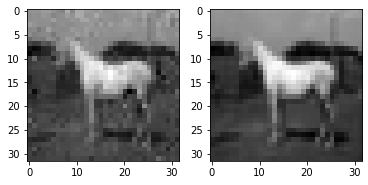

True label: 7
predicted label: 5
Time:  210.21290946006775  seconds
Initial fitness: 
 [0.5818439573576406, 0.6107839086910017, 0.7386469448188431, 0.6110379780386004, 0.6497066544395906, 0.5565662515283182, 0.6674501944026152, 0.7101716225789985, 0.5874925236713193, 0.6122100277581596, 0.591312675759507, 0.5854708541057704, 0.5567729116622717, 0.6007707163624003, 0.5539505545749384, 0.5398213843254587, 0.615318397144256, 0.6163791454044991, 0.5986430641310647, 0.6024472846348992, 0.6127085696360445, 0.6580873218394301, 0.580535020666066, 0.5889031750025779, 0.6195734332460139, 0.5702259765116597, 0.6061134730163654, 0.6132254260093176, 0.5563581724679568, 0.6001669714035829, 0.5334497901650045, 0.5784370008724886, 0.5982115494682869, 0.5601467367393014, 0.5960287707574099, 0.6821531916658158, 0.5736374813727114, 0.5771771365010423, 0.6458081169609153, 0.48806816334691644, 0.6485376570177654, 0.545194448973069, 0.6308427831519984, 0.6817027911941869, 0.6397271270662759, 0.6524287565332

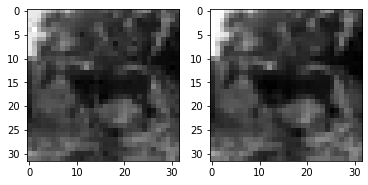

True label: 7
predicted label: 4
Time:  100.63013792037964  seconds
Initial fitness: 
 [0.309766889800618, 0.1779537292624723, 0.40558910770666723, 0.3494038005056565, 0.3570291813303822, 0.3946175722037911, 0.46368933115426214, 0.34739254922801244, 0.28111498931297746, 0.33824126629198703, 0.4791945563206328, 0.2891110595991211, 0.3299204322187156, 0.36662030088778114, 0.2674087234609136, 0.305440378600707, 0.3407667554692864, 0.2985797134817804, 0.37849871644642585, 0.27946980736378463, 0.3094697709183176, 0.27191552228962174, 0.4538331435074401, 0.3479980264590974, 0.22242153222475697, 0.3240588600556947, 0.3714629078991272, 0.3877173482636281, 0.3301205830502593, 0.44089001764277735, 0.23877806731902027, 0.46743985779898267, 0.22176982726872002, 0.19094819680822933, 0.3181797215732632, 0.438679101190597, 0.2962723054975344, 0.39031948899577856, 0.337483645662578, 0.31462940426882124, 0.39182531413898447, 0.30420496771370387, 0.3003730562772005, 0.30118584219487116, 0.30231411892120

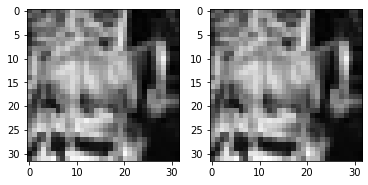

True label: 7
predicted label: 9
Time:  2.3620223999023438  seconds
Initial fitness: 
 [0.41997215325481896, 0.15171718669576734, 0.12976660481143373, 0.5009937382888523, 0.19655852791801273, 0.2517136538848015, 0.28935582947133176, 0.5241169643665048, 0.34483923195767563, 0.26209591949433947, 0.2931902996045869, -0.233037614171701, 0.23240477971468448, 0.23663828864552414, 0.4526981145749734, 0.3023171021940686, 0.23913529721497603, 0.21934466009661951, 0.25062491044504487, 0.2730753393316925, 0.23235957132692797, 0.353450343745252, 0.17142269873834534, 0.26542372455567775, 0.3891096774656087, 0.2912322767425884, 0.2641281354821243, 0.6463480892781872, 0.3135352755456039, 0.35256987991478805, 0.2712205691478864, 0.3713307997197527, 0.40100669579467, 0.09477771766352816, 0.21809994413883138, 0.18920192882274514, 0.3188641295458832, 0.20771191156814994, 0.19803635787202994, 0.4145367069683263, 0.1703512218253752, 0.15601288701396104, 0.2632027463769214, 0.2505334386611662, 0.27046693588

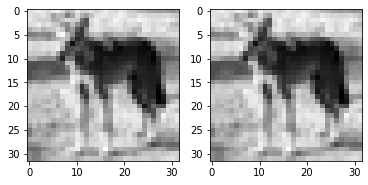

True label: 7
predicted label: 4
Time:  2.335894823074341  seconds
Initial fitness: 
 [-0.5780653880201235, -0.5887499938788462, -0.5788695450234245, -0.5804039229026893, -0.5804419246114054, -0.5716681284804872, -0.5773323510118121, -0.5708131161570908, -0.5800085435601023, -0.5753230018348839, -0.5784349511759356, -0.543487281226054, -0.5770684649722202, -0.5810972785143307, -0.5686824241340628, -0.5793891917196985, -0.5852074785581414, -0.5799752994419548, -0.584499681039246, -0.5702702037160113, -0.5797220895644255, -0.5694413029041078, -0.5327543578543328, -0.573645029469271, -0.5516928218051147, -0.579351104158389, -0.5845372743032148, -0.5825984434169231, -0.579567244459175, -0.5741166322692152, -0.5682478676711196, -0.5780829728018806, -0.5805068197975743, -0.5854654222879652, -0.5788423938229185, -0.5857792095142897, -0.5874046236816366, -0.5768557705750191, -0.5766629082180003, -0.5875895041909179, -0.5810842615586054, -0.5875043030427143, -0.5758709643857107, -0.582046456435

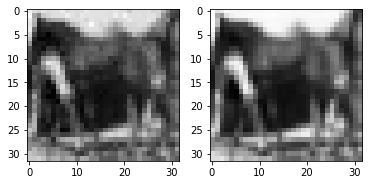

True label: 7
predicted label: 6
Time:  178.01785373687744  seconds
Initial fitness: 
 [-0.5957875398208136, -0.5957719375997556, -0.5973844116837266, -0.5982810011314492, -0.5955295669876814, -0.5985091794757416, -0.597511890586387, -0.5921313271082136, -0.5971877765346023, -0.5966827116567379, -0.5971902406091019, -0.5970828537222519, -0.5973812818109908, -0.5972323389281016, -0.5978018839361847, -0.5977014880131415, -0.5973386214760861, -0.5975560090506535, -0.5978711381705747, -0.597308474075795, -0.5955097503325038, -0.5975924919054744, -0.597018915047664, -0.5963860454588263, -0.597190726681382, -0.5950616856445218, -0.5938212691882094, -0.5958534613379939, -0.5966448111863721, -0.59820431550854, -0.5977654121752614, -0.5973092096288534, -0.5970208945554469, -0.5976304042792473, -0.5978315180543519, -0.5961144686906927, -0.596799046833822, -0.5981206755923073, -0.5959568601124171, -0.5957794744090936, -0.5962023975570758, -0.5958084769906027, -0.5952829693182107, -0.5975693479157

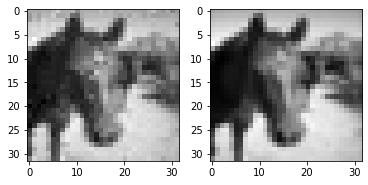

True label: 7
predicted label: 3
Time:  205.23261904716492  seconds
Initial fitness: 
 [-0.5822963338077689, -0.5884505860479974, -0.5927687853578524, -0.5849264905563263, -0.5873332366917333, -0.5907914944673844, -0.5874100442674633, -0.5909468244851339, -0.5902140267075553, -0.5917987424048605, -0.5893206530589538, -0.5699216109631022, -0.5854697082818221, -0.5887785294008051, -0.5922294094243081, -0.5857036348496043, -0.5905384027858382, -0.5858837484990378, -0.5872900318559277, -0.5898783699729224, -0.5921874698100947, -0.581486506637369, -0.5946875081596725, -0.5888137470378816, -0.5943906150138867, -0.5881139335204844, -0.5809988622845635, -0.5870865493761707, -0.5852811553807133, -0.5891777239035038, -0.5903412707863106, -0.5885404314763125, -0.5893809947331338, -0.5752600292103667, -0.5860559742129097, -0.5927290500593089, -0.5931710432064411, -0.589043036853119, -0.5906772933031423, -0.5870824245099657, -0.5752291330683347, -0.5902287939111017, -0.5876335941298906, -0.58969128

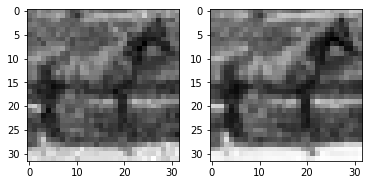

True label: 7
predicted label: 4
Time:  289.79522824287415  seconds
Initial fitness: 
 [-0.3244378696715403, -0.18343818908165027, -0.2955880932532917, -0.22550789311982455, -0.3038194831202251, -0.2813737057565341, -0.1374558315078005, -0.38785724467642857, -0.30421128531558783, -0.39858950850511354, -0.2756265306233744, -0.35913428286497756, -0.3406465112220351, -0.06987755251327532, -0.3434894669793127, -0.42506109786776536, -0.24476049513109202, -0.24071948994526546, -0.20954192843105382, -0.27370236609523113, -0.37611771771877994, -0.32830691351748875, -0.2359725883656743, -0.30836287392819905, -0.12405993230202556, -0.2988587961750013, -0.2875700970114371, -0.22732481754248146, -0.30136295222985193, -0.18127476699753586, -0.24592362354106975, -0.20181385663331952, -0.2815078110142023, -0.31191912095395835, -0.38084211778372257, -0.35267878253122886, -0.11299309036023811, -0.35734868088286725, -0.35877931283489567, -0.34927262131047804, -0.18830066086811792, -0.3284802770745139, -

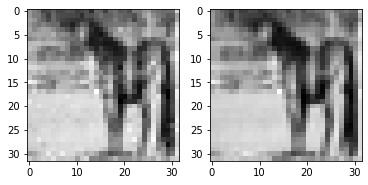

True label: 7
predicted label: 4
Time:  150.29998779296875  seconds
Initial fitness: 
 [-0.5995739176385328, -0.5993036394811371, -0.5991124190623548, -0.5989820016470145, -0.5996360262987244, -0.5995396687049978, -0.6004939894919528, -0.5996217290842687, -0.5996060318404629, -0.5998552569090391, -0.5992253533273365, -0.5993692631095373, -0.5995731337098523, -0.5997562183519146, -0.5996979654171648, -0.5997355127864088, -0.5997424641081537, -0.6001896294715299, -0.59952483135308, -0.5994332286396121, -0.5994083958188664, -0.599302349935076, -0.599556262013373, -0.5997545053584876, -0.6005566363271544, -0.5999335241314124, -0.599262015218897, -0.599464265659647, -0.5995017918214762, -0.5994418424564469, -0.5998393583923795, -0.6000502633425575, -0.5993002683867878, -0.5990403105865291, -0.6005736035407646, -0.5992957119294036, -0.598292682013178, -0.6002877320653219, -0.5993604219580174, -0.5996282646472048, -0.5994537875415362, -0.5999194349145759, -0.599614552928684, -0.59922080095333

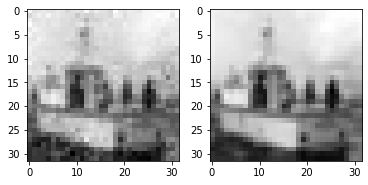

True label: 8
predicted label: 9
Time:  492.3563187122345  seconds
Initial fitness: 
 [-0.5777837495197844, -0.5528892781182861, -0.5643953381339778, -0.57701384854702, -0.5712860905866224, -0.5752132480165713, -0.5664539808884577, -0.5582384505900246, -0.5642027316152632, -0.5544290638087177, -0.5791174095394069, -0.5605358885356116, -0.5484971319662847, -0.572376684717844, -0.5656197359571985, -0.5685545417414476, -0.49237157181568997, -0.5761670747166516, -0.5536582695209827, -0.5762558697879199, -0.5806498529362756, -0.5624192929762533, -0.5740796249453755, -0.5671539409623207, -0.5728135890462537, -0.5266335388943331, -0.5752309526682216, -0.5492268720053584, -0.5563800588187198, -0.5557731726823434, -0.5654054289477837, -0.5691266349606214, -0.5553644244793076, -0.5679102381900483, -0.5694434305968179, -0.5569750003232394, -0.5735308551244369, -0.5690732493617487, -0.5753491285432082, -0.5793113676741894, -0.5833362647178869, -0.5641427441899654, -0.5706827503675014, -0.570868707

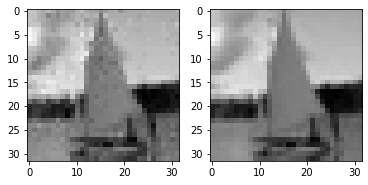

True label: 8
predicted label: 4
Time:  182.8042857646942  seconds
Initial fitness: 
 [-0.3254138926388529, -0.31100984514392527, -0.2047631875040301, -0.28024270390658823, -0.3812902514967217, -0.27312376019457973, -0.35253669465376114, -0.24628306191699223, -0.32464230813189565, -0.37853853552090533, -0.17673928922669874, -0.46354685002351725, -0.25108295501254396, -0.24538771757484504, -0.12301098285123613, -0.2987181148075003, -0.1783678264772451, -0.28471865335140484, -0.35505795713597976, -0.24924088925355706, -0.21208352481938958, -0.2732855104351797, -0.30432307141870496, -0.49015542554729613, -0.15453687272690325, -0.2692580079124304, -0.2626912560674643, -0.4225760594913157, -0.49971200711937575, -0.40881003137864946, -0.36503200505603983, -0.3784775659035655, -0.23855859920770067, -0.2734817278035204, -0.10560568586518365, -0.41178062510410274, -0.49632506227348827, -0.12475124637730217, -0.3345287150089121, -0.3428296968564364, -0.03346296288067785, -0.3254383156481827, -0.

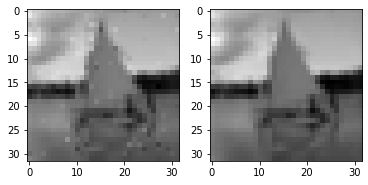

True label: 8
predicted label: 7
Time:  94.42607092857361  seconds
Initial fitness: 
 [-0.6037552139703045, -0.6068787712004756, -0.6074700125956704, -0.6050245938094224, -0.6072738057851746, -0.6007885394409958, -0.6036748413532564, -0.6011696158678225, -0.6005930457601012, -0.6064218899306922, -0.6021723510455731, -0.6029898638861078, -0.6063529101523701, -0.6016747790324559, -0.6061643660326492, -0.6040037804159991, -0.6025641547510561, -0.604855254787227, -0.605430389155335, -0.6061537525100905, -0.6024486609969297, -0.6020112174949631, -0.6022804421103357, -0.6006903646997815, -0.6008500320721664, -0.6025864548507731, -0.6063913508558505, -0.6016502301572816, -0.6054197019637156, -0.6012808904309704, -0.6070613332522663, -0.6049462400860095, -0.6021006000128514, -0.6095873999487398, -0.6020604361484636, -0.6063156208630285, -0.6073084748021298, -0.6091561026177851, -0.6029493418174969, -0.6044523812277779, -0.6024173579336211, -0.60094146479938, -0.602119670107826, -0.601963953913

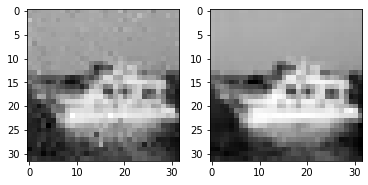

True label: 8
predicted label: 0
Time:  265.08348536491394  seconds
Initial fitness: 
 [-0.5996216828772195, -0.5997358597474103, -0.5997702249098559, -0.599579510210302, -0.5995439325577121, -0.5998755979936894, -0.599207786494631, -0.5995712008022296, -0.5994919554547041, -0.5994508666264873, -0.5994511655325299, -0.5995807902889274, -0.5994949271702618, -0.5994958850788039, -0.5995660403109798, -0.5996192112698697, -0.5995226319027409, -0.5992818618539173, -0.5996821889993289, -0.5991711214910831, -0.5995587432045146, -0.5997996984218062, -0.5996641372348988, -0.5995686688867797, -0.5995690268277081, -0.5996865871710579, -0.5994132974999894, -0.5994046131688449, -0.5993180326711017, -0.5999840060806649, -0.5996692474824232, -0.5996126137802176, -0.5995209912710233, -0.5995570944398331, -0.5996903007466288, -0.5995851866513118, -0.5997180667747388, -0.5996018268984425, -0.5995458831546098, -0.5994519366412494, -0.5995101008996246, -0.5993531102191816, -0.599790870418709, -0.599198313

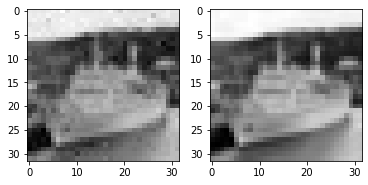

True label: 8
predicted label: 6
Time:  234.46081590652466  seconds
Initial fitness: 
 [-0.5945861426827235, -0.5906632390920704, -0.5892714888820694, -0.584027654303599, -0.5931205189281017, -0.5920517193129748, -0.590680256648911, -0.5894129562394966, -0.5970145445326281, -0.5897731967097168, -0.5812609047954671, -0.5897613339927719, -0.5936248949958889, -0.5912455900976901, -0.5902376698342511, -0.5901999925292383, -0.5831575937091842, -0.594170507930831, -0.5957487659912017, -0.5892070890095815, -0.5936753217672219, -0.5574500636165967, -0.5922270087786128, -0.5894059807955763, -0.5948705476634121, -0.5929492620072215, -0.5890259493645414, -0.5885596864443773, -0.5927078131981006, -0.5871660157654445, -0.5903971224765254, -0.5953449867189098, -0.5860709992011458, -0.5870561321378889, -0.5899261755733887, -0.5924878676642897, -0.5921198794341281, -0.5880939801873368, -0.5892416417847288, -0.588576854902909, -0.5860776381714435, -0.5849266147018808, -0.5835074046193903, -0.5888526447

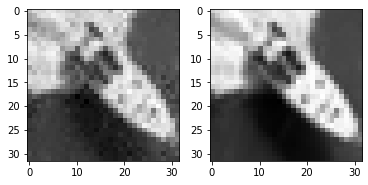

True label: 8
predicted label: 0
Time:  413.7386872768402  seconds
Initial fitness: 
 [-0.6003382063371743, -0.6017028844829789, -0.6089938061940323, -0.6006037744007774, -0.6024956043863181, -0.6006924315637902, -0.6033295550108662, -0.6003768712435101, -0.60127668245804, -0.6021309913460706, -0.6013479440097618, -0.6016103408983525, -0.6007245857013466, -0.6031065418424768, -0.6004712806146684, -0.6038417158442189, -0.6030412831992067, -0.6002109816532535, -0.6033140105926242, -0.6067277538763147, -0.6027970638045823, -0.6031160763436827, -0.6025553617804207, -0.6002980939145297, -0.6012176903150546, -0.6009023924547575, -0.6019470007352032, -0.6025313928572541, -0.6007448532787415, -0.604200253197237, -0.6016144447833276, -0.6000028551195238, -0.6019322565602886, -0.6015092863038447, -0.600139126430044, -0.605204717227022, -0.6018499637129116, -0.601488591510847, -0.6003614806585404, -0.6007916225367756, -0.6068533359943732, -0.6005104363643992, -0.6033506257677335, -0.6013586624697

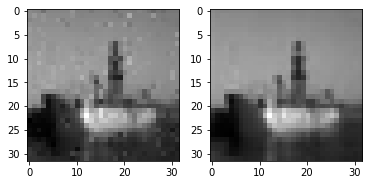

True label: 8
predicted label: 4
Time:  148.50180077552795  seconds
Initial fitness: 
 [-0.5998977635052833, -0.5996429046229779, -0.5998789260953451, -0.5995666860766566, -0.6002486751293921, -0.5995802274835353, -0.5995653195782886, -0.5995932909953525, -0.5999149100937332, -0.599666450862568, -0.599695218079038, -0.5996373801069373, -0.5998023992565756, -0.5988307553017919, -0.5994608296218362, -0.5994959934893446, -0.5997718905990387, -0.599951182015338, -0.5997190187818225, -0.5996224473865545, -0.5998769251118471, -0.5997325199209775, -0.599756969251862, -0.5996637233433098, -0.5997521437237903, -0.5997216263373122, -0.5996765489673846, -0.5999168286197679, -0.5996338486982635, -0.5998970505176229, -0.5999867525949747, -0.5996372154646621, -0.5997096500446052, -0.5995114504295848, -0.5991346921691644, -0.5998261832274074, -0.5996310815894612, -0.599833399507205, -0.6001378164233311, -0.5997668293899296, -0.5996818422021251, -0.6000937072095713, -0.5995906447421511, -0.59971460585

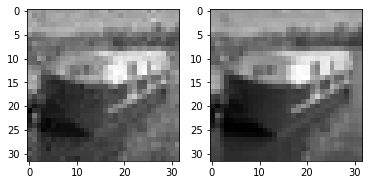

True label: 8
predicted label: 6
Time:  333.58995175361633  seconds
Initial fitness: 
 [-0.3327227601191901, -0.34689383919602157, -0.4484482621901592, -0.3559743970686018, -0.15847076619049064, -0.0493564782214824, -0.13333327918449697, -0.24357788011912157, -0.36163239010777204, -0.2754247350571582, -0.4714709205574209, -0.1098183552276655, -0.28741959907777986, 0.031469877700167265, -0.12074708111742033, -0.245365581579347, -0.3953090120955255, -0.2713305130032609, -0.39050374921003866, -0.4767353449269144, -0.3470457859711242, -0.15622383740878068, -0.3718879327108494, -0.12661055323439832, -0.1595043153806533, -0.16986554775216786, -0.1094483755621892, -0.2538725322244123, -0.34016645600425477, -0.10695816979363923, -0.37209145546814626, -0.2793124471764532, -0.03488930699984172, -0.06061873964511774, -0.421126341281606, -0.21456279418180477, -0.39020335296854636, -0.2871202064699112, -0.29227209674295085, -0.09014416487801272, -0.328661328948994, -0.4353218729220566, -0.451269162

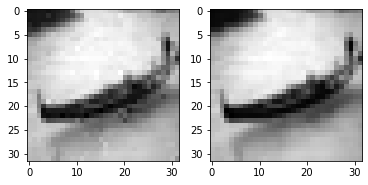

True label: 8
predicted label: 0
Time:  103.94490242004395  seconds
Initial fitness: 
 [-0.6060298812043656, -0.601845313299573, -0.6012228376135224, -0.6022203485016375, -0.5986597442123394, -0.6028573061828524, -0.6027293590747513, -0.5991086299421813, -0.6030983732141756, -0.600015210364338, -0.600510166788588, -0.6000750692959846, -0.6035699744933658, -0.6025259519051286, -0.6032120397286778, -0.6006838380669229, -0.5926429789320128, -0.6019652378605371, -0.5997647640572229, -0.6009591623454972, -0.6014693860885222, -0.6017468605421519, -0.6037153351470672, -0.6019546254316711, -0.6010824505179398, -0.6003407860530255, -0.6042131168520503, -0.6002778389086566, -0.6027650617301208, -0.6061205036230819, -0.5991752738140619, -0.6009144455393923, -0.5994949845579582, -0.601074817340675, -0.5994579921795253, -0.6023496776635051, -0.5932120182495504, -0.6017201583551236, -0.6014191924335051, -0.6024766018274966, -0.6001389021888199, -0.6027461751600356, -0.602567805496882, -0.60006777868

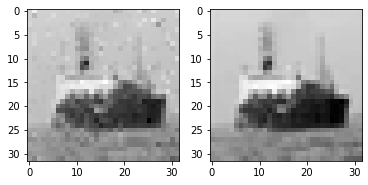

True label: 8
predicted label: 6
Time:  160.1518633365631  seconds
Initial fitness: 
 [-0.6002588698711732, -0.6002902878818446, -0.6000719591973018, -0.6001809570108005, -0.6000424640464743, -0.6000937002437168, -0.6002734209858318, -0.6000534409533859, -0.6004986235094601, -0.6003204756389153, -0.6006479590558116, -0.6000262059465123, -0.6002495377901385, -0.6000514543423453, -0.6002176644431761, -0.6002622285207375, -0.600033125753353, -0.6003496366466239, -0.6002260290100456, -0.6003070375310642, -0.6007172981487087, -0.6004483507594758, -0.600592449347233, -0.600468027989169, -0.6001833370097267, -0.6001880829926078, -0.601198017761114, -0.6002185953419582, -0.6002640969471007, -0.6006744242197356, -0.6004754064746186, -0.6004597405615975, -0.6003810409724938, -0.6000335580695059, -0.6000909982120902, -0.6004832940518335, -0.6001484987597919, -0.6001531644638901, -0.6000820718713773, -0.6003274672173193, -0.6002693575887122, -0.6004075057273818, -0.6001538038037617, -0.60057862636

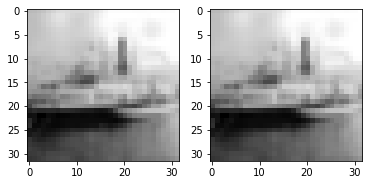

True label: 8
predicted label: 8
Time:  62.32553672790527  seconds
Initial fitness: 
 [-0.5995801252093277, -0.5997102066001044, -0.5995528420088082, -0.5997248523297154, -0.5993300723492745, -0.5994288560042959, -0.5997666819657395, -0.599590652736947, -0.599754380747298, -0.5996017783887834, -0.5996068824476153, -0.5994376136306189, -0.5994956141580693, -0.5997021233023472, -0.5996309084909883, -0.5992050371376052, -0.599598326316345, -0.5992061376129292, -0.599468428040518, -0.5995881483330086, -0.5996049940210513, -0.5996717095907798, -0.5996148802577217, -0.5995986730915902, -0.5995213029493203, -0.5997022411697945, -0.5997628930011436, -0.5989281219528152, -0.5997509808793282, -0.5996250094661123, -0.5996038224375788, -0.5997316977325617, -0.5991805484793788, -0.599279720044335, -0.5996864004815647, -0.599533174400457, -0.5999102704528828, -0.5994452965005526, -0.599419626692878, -0.5994294970610183, -0.5996142385523242, -0.5996453995114657, -0.5997660667643478, -0.59955256992705

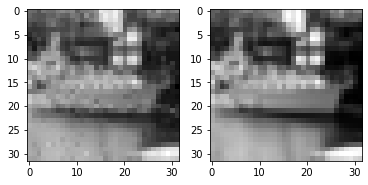

True label: 8
predicted label: 3
Time:  158.18790769577026  seconds
Initial fitness: 
 [-0.604024210894649, -0.602293757906132, -0.6012312838667581, -0.6011941880612377, -0.6012708075275205, -0.6037841288317964, -0.6096982243122367, -0.6020859911025948, -0.6016637279880197, -0.6046373733571357, -0.6039268309843805, -0.6015438635919687, -0.6035453005227807, -0.6018679578797378, -0.6010643943616345, -0.606624325262505, -0.6023829530322062, -0.6010562036320954, -0.6042504333746044, -0.6002028898909398, -0.6065603733621951, -0.602150682406327, -0.6010801287200246, -0.6025985000598432, -0.6021575426586432, -0.6033264190289211, -0.602532180834811, -0.6033974192333009, -0.6032594350508247, -0.6008459199814957, -0.6021465814219953, -0.6037666065659435, -0.6023045830781624, -0.6050576573780211, -0.6055994823392012, -0.6015988908980311, -0.601987687152108, -0.606064872658889, -0.6047804186774381, -0.6039445326756893, -0.6022405451757701, -0.6014703058334506, -0.6036610542983756, -0.6039619575223

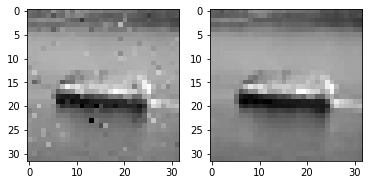

True label: 8
predicted label: 0
Time:  105.44770669937134  seconds
Initial fitness: 
 [-0.6002059620390061, -0.5999378875217851, -0.5999011423044021, -0.599952959620389, -0.5998966546368156, -0.5999877496066655, -0.5999476661745783, -0.5998641388721353, -0.600107408654279, -0.5998928278888415, -0.599942452683995, -0.5999030443994671, -0.6000306212974074, -0.6000724865549544, -0.5999602859427774, -0.5999233776540739, -0.599917380962727, -0.6000147052915665, -0.6000398646740482, -0.5999519772188926, -0.6000451833967193, -0.5999981648092114, -0.6000474261785766, -0.5999497681630926, -0.5999494572495346, -0.5999875391847129, -0.5999256561219721, -0.6001100760726039, -0.6000308911693301, -0.6000361984839684, -0.599920375159805, -0.5999979045418528, -0.6000513110883576, -0.6000279994210707, -0.5999710760612982, -0.5999003004112341, -0.6000272891231847, -0.6000350885802955, -0.5999574840848221, -0.600018169873785, -0.6000600582888806, -0.5999177946724065, -0.6001327715794091, -0.600008163617

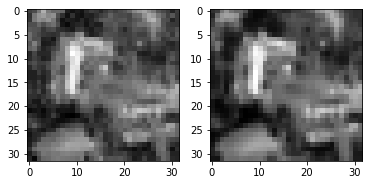

True label: 9
predicted label: 2
Time:  402.2531008720398  seconds
Initial fitness: 
 [-0.32475237659514733, -0.12362747609571523, 0.029725489657240145, -0.24224842923327244, -0.18733745863658488, -0.20793557511240113, -0.2153050640579506, -0.2589355626562116, -0.16602414051135247, -0.2905319012906151, -0.2992915508359639, -0.3686321461984382, -0.12838797262066393, -0.2702998736741553, -0.2072378790926154, -0.2202989440152459, -0.14503648667883257, -0.2626853878659863, -0.03197619023118467, -0.307871558489769, -0.15553771376330772, -0.34564488880324695, -0.29048254606800644, -0.2671891741619753, 0.023019233838979303, -0.21412162449304636, -0.45553536679990736, -0.11719372722237459, -0.24139286969234464, -0.21647728699651433, -0.2808620895607883, -0.19129086063296208, -0.018164478954657948, -0.19817904643070025, -0.2675410231123161, -0.19849674926156657, -0.17363411805625426, -0.30522058467806545, -0.1747200613956611, -0.21678175542526895, -0.11429416598731695, -0.32118266854915845, -0.

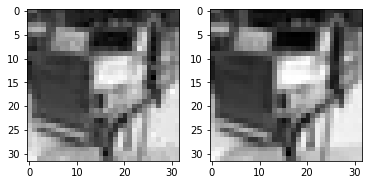

True label: 9
predicted label: 1
Time:  296.2444489002228  seconds
Initial fitness: 
 [-0.5981191574018894, -0.596721340227797, -0.5967124142956052, -0.5984035832159611, -0.5969097334911326, -0.5968756882611304, -0.5980710747048135, -0.5988291955748176, -0.5977136834246157, -0.5980236108270834, -0.5981825494322793, -0.5984152939638928, -0.597337981583578, -0.5974696548285798, -0.5984648813175725, -0.598532669750849, -0.5978323098294507, -0.5968121850892147, -0.598108643117247, -0.5997980625603041, -0.5989556388791002, -0.5985332523439699, -0.5965530802238355, -0.5992308634221262, -0.597768820697039, -0.5985826782447232, -0.5984509119359852, -0.5979934348904398, -0.5978832803891586, -0.5982634287153089, -0.597828440816954, -0.5985602676011522, -0.5989148628335462, -0.598084973552105, -0.5977420946845773, -0.5980156329885147, -0.5983701072032468, -0.5977252744072276, -0.5986618664911767, -0.5973373330131305, -0.5980911736856842, -0.5978789146721746, -0.5979163952437943, -0.59741652473335

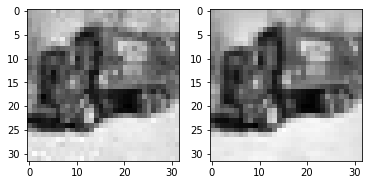

True label: 9
predicted label: 1
Time:  295.44966435432434  seconds
Initial fitness: 
 [-0.6004098210732579, -0.6003581808006536, -0.6044746738818944, -0.6001927988386598, -0.6055772672847001, -0.6014923506167927, -0.6019731757133513, -0.6002172731154265, -0.6005194755986534, -0.6000720701646712, -0.6015872639520332, -0.6031658434180015, -0.6012968747443128, -0.6050359886394722, -0.6002243323570972, -0.6003131093155485, -0.6002767728349432, -0.6001355210037287, -0.6003981478977346, -0.6009867803968044, -0.5999655164855628, -0.6014533293299205, -0.6006565887371651, -0.6005746882615434, -0.601436479062798, -0.6018644363777815, -0.6027246609198635, -0.6012678572788127, -0.6020944953296242, -0.6086751560225758, -0.6001179793479087, -0.6032130882654475, -0.5999644272543411, -0.6007267425597898, -0.6018966882242627, -0.6017194054469872, -0.6013800917705079, -0.6003753274870731, -0.6052634244432351, -0.5999039540745266, -0.6048387412135049, -0.6001246022833903, -0.6050259013511946, -0.5999285

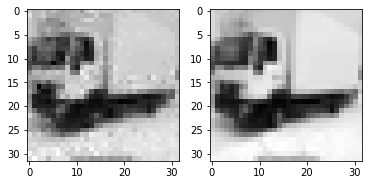

True label: 9
predicted label: 8
Time:  274.3494920730591  seconds
Initial fitness: 
 [-0.5997036650673073, -0.599654770882637, -0.6044518551807616, -0.6039209017124376, -0.6036074256065384, -0.6031786417859495, -0.6025044922043191, -0.599915856106819, -0.6014351884308571, -0.6039446102845618, -0.5998537476210778, -0.6014030471054657, -0.6009880186540282, -0.6025883550348401, -0.6050910602846021, -0.599880354784705, -0.6000050043802272, -0.6014236942912978, -0.6012098516593216, -0.6011268085484365, -0.6001543465116769, -0.6048731168277223, -0.5998476676129311, -0.5998146384023062, -0.6025610476651385, -0.6031963584245229, -0.600458625194306, -0.601256310236917, -0.6070755082716559, -0.5999940644170998, -0.6018834693033476, -0.6019098617400346, -0.5998338362362073, -0.5998234581316355, -0.6015940551138339, -0.5998802335536292, -0.5999801227520913, -0.5998244498342142, -0.6054549004704022, -0.6004940998093754, -0.6025825275561838, -0.6010483862134536, -0.6035978726120954, -0.604858797137

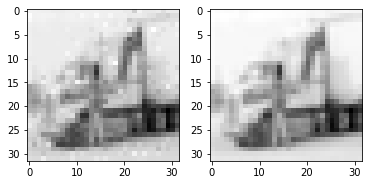

True label: 9
predicted label: 8
Time:  132.22730422019958  seconds
Initial fitness: 
 [-0.600143128287214, -0.6002799344774947, -0.6003044136721045, -0.6001155257796275, -0.6001883737276819, -0.6003360197797075, -0.6001019674321428, -0.6005533750668102, -0.6001695985676433, -0.6000828013949404, -0.6000162660319054, -0.6000454511814638, -0.6000512866088605, -0.6000853614438952, -0.6001522730017159, -0.6001646114804637, -0.6001044665132176, -0.6001263982131245, -0.6002168956138874, -0.6001010697850803, -0.6000444109446638, -0.6002338482424534, -0.6001685878733496, -0.6002654235656404, -0.60024832610393, -0.6001978041464897, -0.6000798498250792, -0.6002380777222587, -0.6000543591566369, -0.6002285643721256, -0.6003362999201108, -0.6000882591448935, -0.6001000394588897, -0.6001995520159829, -0.6001479897356268, -0.6000885519343411, -0.6000315841790422, -0.6000525536543224, -0.6005963044209054, -0.6001337465007177, -0.600067425764058, -0.600103877443352, -0.6001080952616411, -0.60004446496

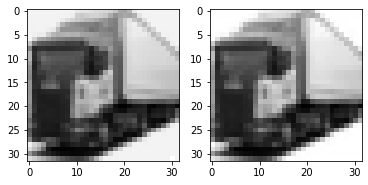

True label: 9
predicted label: 9
Time:  59.29379606246948  seconds
Initial fitness: 
 [-0.40974124612637153, -0.5047421831336647, -0.4638985315086883, -0.4356351985568823, -0.4935115322354201, -0.43952200503095357, -0.499436804229482, -0.47170631279025904, -0.5523230241622492, -0.5205604016696587, -0.4591429310238186, -0.4803188541394886, -0.4831748086244541, -0.5025636394265597, -0.48076610958657473, -0.5363669163917562, -0.4813620043971027, -0.4939604119214626, -0.43730056232843983, -0.4607810140620574, -0.4339969676799622, -0.46060736785635104, -0.5385655335183496, -0.42874041630602316, -0.5087552022550413, -0.5308102370273451, -0.43197180478081654, -0.5273778755839027, -0.4640324587628797, -0.48807706557652974, -0.47496219832002806, -0.5248261086555257, -0.4660531801199161, -0.5170507741416731, -0.43908171720673705, -0.4883612853410997, -0.4940499474378215, -0.47454134891439725, -0.44480802438358796, -0.4941941857790463, -0.4698234327446401, -0.4035659786811431, -0.5105698592396164

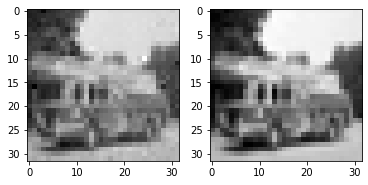

True label: 9
predicted label: 1
Time:  245.21699953079224  seconds
Initial fitness: 
 [-0.5997675517489318, -0.5998704701347585, -0.5999364264129734, -0.5998878764041502, -0.599866430672591, -0.5996821852831695, -0.6002240914711132, -0.5999083390180113, -0.5994995940055347, -0.5999595834027502, -0.5998631523623198, -0.5999284707558408, -0.5996980168076678, -0.5999526187373436, -0.5996799359349702, -0.5999362614156893, -0.5998743728315791, -0.5997868900642926, -0.5999723167691875, -0.599694312889283, -0.600040341498884, -0.5999441269637358, -0.5999809674037122, -0.5998668677061462, -0.5999012264632395, -0.5999213013262759, -0.6000100350510685, -0.6000051204398686, -0.5998972304755729, -0.5999460263944856, -0.599845399280754, -0.5998449689531848, -0.5997312814852929, -0.5999143799717008, -0.5998373720774258, -0.5998161975438009, -0.599951662792613, -0.5999195035882776, -0.6000454784661235, -0.5998191384452353, -0.5999547162822336, -0.5998578468728317, -0.599819639631011, -0.599855476017

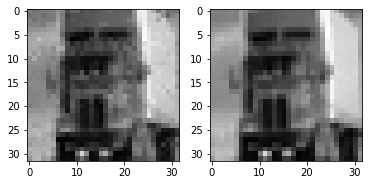

True label: 9
predicted label: 1
Time:  203.2336847782135  seconds
Initial fitness: 
 [-0.5039860241233658, -0.49880168470953645, -0.5250411816251542, -0.4930982376050154, -0.5221028415797259, -0.505974431854975, -0.5085628186974017, -0.517771586334435, -0.5161347006561988, -0.5291490340827529, -0.5382196365972041, -0.5255703263278, -0.4769948805129506, -0.5217504993042392, -0.5134990993006623, -0.5164045856993158, -0.510599016772893, -0.4395517322901974, -0.5375436209746018, -0.524783302806661, -0.5318591488189479, -0.5247857619540044, -0.5217167073583296, -0.46404625423183354, -0.5331145997059974, -0.48389600937889826, -0.5296405688466725, -0.5197318436838652, -0.5328464084454663, -0.45954946183793577, -0.504361490299299, -0.5089836458830699, -0.5138704965359234, -0.5190161014997777, -0.5322305555234599, -0.524468636956898, -0.5119309327629977, -0.5184365908851163, -0.5153776806770589, -0.5087124772266811, -0.5268689205506674, -0.5174557737936384, -0.5180049454562072, -0.510889213829

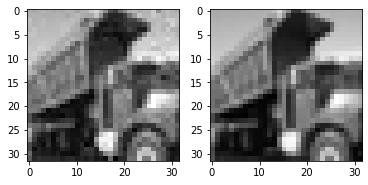

True label: 9
predicted label: 2
Time:  353.1851179599762  seconds
Initial fitness: 
 [-0.5996079537273239, -0.5982067097670395, -0.5986783344457046, -0.5967017520850224, -0.5978243779069596, -0.5977508705199418, -0.5994279524148028, -0.5978332067939107, -0.5996112525979306, -0.5989594830803429, -0.5990699736127836, -0.5980946577335404, -0.5977260752721947, -0.5976729884546598, -0.5988498886714009, -0.5981646058953821, -0.5976710938536052, -0.5977498489114231, -0.5975425514633482, -0.5985833215944997, -0.597979051191143, -0.5972439490561052, -0.5988803809918202, -0.5968575620180994, -0.5987371190642728, -0.5979609513277621, -0.5990422889308101, -0.5983916377844075, -0.5977372698194322, -0.5980740542485313, -0.5991122784786359, -0.598299705332482, -0.5974676847826504, -0.5953123430859656, -0.5972002732491947, -0.598547330836324, -0.598224619872417, -0.5983771291601108, -0.5989784215644524, -0.5963903178073068, -0.5980716698789348, -0.5980945306642783, -0.5983784795175842, -0.60044202487

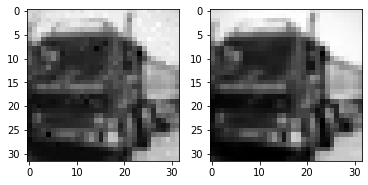

True label: 9
predicted label: 1
Time:  158.53500819206238  seconds
Initial fitness: 
 [0.14566935992238617, 0.13632738325713228, 0.11220154127445986, 0.15642793957968687, 0.16971529721875944, 0.08415443295485003, 0.34686467857956255, 0.11739877123431293, 0.33132869190543945, -0.11982699624931603, 0.14097702632261605, 0.23001177274751064, 0.037221770441291796, 0.1360063259309064, 0.09420126616900386, 0.45991046585022466, 0.19434295328541745, 0.08073303760405498, 0.22994635083054693, 0.05657438502241169, -0.027374289256315465, 0.23144661045515597, 0.06171481496899378, 0.125897987584406, -0.03539698911160469, 0.4938019632226269, 0.13212917764345639, -0.016335525942975798, 0.25860344553479647, 0.1855773273410935, 0.04027248087198329, 0.12320268125684158, 0.053484502551164353, 0.06839545600336763, -0.06653500669749432, 0.10909789626523826, 0.09986344614228568, -0.13805420481609565, 0.11560878078565179, 0.11192299239059286, -0.010176705920227402, 0.0929380005023141, 0.08435135048102861, 0.4

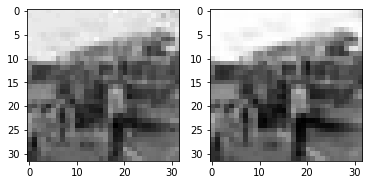

True label: 9
predicted label: 7
Time:  230.58210515975952  seconds
Initial fitness: 
 [-0.6001562383160126, -0.6003979510815708, -0.6000031761086086, -0.6001126797032936, -0.6001085719645497, -0.6002517895138509, -0.6005766364641807, -0.6008213178149634, -0.6001872568420958, -0.5999721478630091, -0.6007637492115621, -0.6001573079669571, -0.600339824935373, -0.6006469581828361, -0.6015959202195966, -0.6011298969267435, -0.6005709137772527, -0.6014863594235786, -0.6006372171204586, -0.6006302262461183, -0.6006535484924168, -0.6005907401764841, -0.6001907125934911, -0.6001475370234601, -0.5999829847197511, -0.6007320870862326, -0.6008349576436943, -0.6016622087137948, -0.6007113791067099, -0.6000403773440742, -0.5999804168477714, -0.6005652876338767, -0.6000743907321725, -0.6002639741689575, -0.6005275804598921, -0.6015122340713158, -0.6005697317162687, -0.6002462501536922, -0.6008263632337227, -0.6003860636670029, -0.6009131813472239, -0.6011417947465808, -0.6032225300595534, -0.6005390

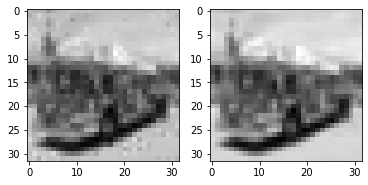

True label: 9
predicted label: 6
Time:  210.5029423236847  seconds
Initial fitness: 
 [-0.6000575295196079, -0.600528619734067, -0.6001016317706203, -0.6003647452918786, -0.6001604616312403, -0.6004500882569163, -0.6001877036777759, -0.6002724145369751, -0.6000614146370592, -0.6006259208988388, -0.6000521014949411, -0.600569372149721, -0.6001489376251793, -0.600166238408552, -0.6004723898211386, -0.6002925365496101, -0.6003875568545455, -0.6001366979838177, -0.6000539617328137, -0.600137795104147, -0.6003071461511587, -0.6000669482775434, -0.6005842825592408, -0.6003313169104372, -0.6000255994096222, -0.6000339260831633, -0.6005657017879045, -0.6002981051924128, -0.5999941625974818, -0.6003085480601579, -0.6000247171947841, -0.6002076208248064, -0.6001298173345587, -0.6000161777671088, -0.6001355848763671, -0.6003916421159955, -0.6001720769227371, -0.6000466913163871, -0.6002287485206068, -0.6001476853939731, -0.600026156686573, -0.6001350523500941, -0.6000215992944894, -0.600380335121

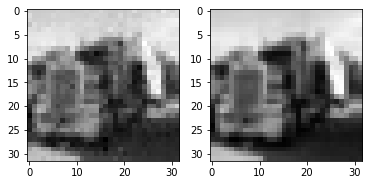

True label: 9
predicted label: 6
Time:  333.86022567749023  seconds
Initial fitness: 
 [0.21448345248659215, 0.31694177183792765, 0.28693400144987935, 0.36354733008370144, 0.18287282624305826, 0.18691761175131938, 0.26530296654746555, -0.08336624136956555, 0.31710550841520313, 0.577378995240976, 0.2872029527898462, 0.11352115200196464, 0.4216264505279289, 0.4443383971296189, 0.31859965409446583, 0.4895710611439741, 0.41895136698214464, 0.44695006733924036, 0.43892041033178475, 0.42194270167196535, 0.39529511011180574, 0.3903251281343089, 0.38252385920004284, 0.44300575109708307, 0.27516198220488874, 0.464601395410117, 0.4542214591379575, 0.3589291252038844, 0.2756589819942841, 0.39416336104178723, 0.39797384819878057, 0.30283893688988694, 0.2131395114424141, 0.4052095242508238, 0.15577878201070164, 0.39860275426825104, -0.01560899151661796, 0.35474632084984237, 0.3522843558252895, 0.47421682158715983, 0.30683054009446903, 0.5301233716110394, 0.34375487069658783, 0.26411663911932076, 0.

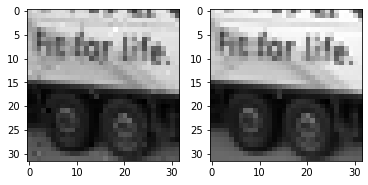

True label: 9
predicted label: 1
Time:  179.73630213737488  seconds


In [11]:
# for each image and label in adversarial
n=50
import time
# these are the examples that are found as adversarialwe will save these at the end in a file
evolved_examples= []
# fitness of the adversarials
fitness_of_evolved=[]
# time necessary to evolve the adversarial
times=[]
# the distance between the original image and the adversarial
ssim_values=[]
# number of round necessary to produce adversarial 
number_of_rounds=[]
# this will serve to see if the fitness changes or not 
best_fitness = 0


numb_of_found_after30=0
numb_of_adv_found=0

#dictionary to keep the best individual to check if the fitness is improving or not 


predicted_class= []
for img,label in zip(adversarial,adversarial_y):
  winner_of_gen = {"image":[],"label": None, "fitness": None}
  #temporary variable to check generations:
  fitness_no_change = 0
  start = time.time()
  label=label[0]
  #intialize population from the image and with the given label
  population = init_pop_from_sample(n,img,label)
  # calculate fitness of these individuals
  fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label)
  print(f"Initial fitness: \n {fitness}")
  #retun the best one from the population
  best,fit_max = return_best_individual(population,fitness)
  #check if adversarial
  check_adv = check_adv_termination(best,label,img, model)
  #define max generation
  max_gen=0
  winner_of_gen.update(image= best)
  winner_of_gen.update(label= label)
  winner_of_gen.update(fitness= fit_max)

  while (len(check_adv)==0 or max_gen<10000):
      new_pop=[]
      for i in range(50):
        parent1= tournament(population, model, img, label) 
        parent2 = tournament(population, model, img, label)
        if 0.8 > np.random.uniform(0.0, 1.0):
          child1, child2 = k_crossover(parent1, parent2) # crossover
          new_pop.append(add_noise(choose_better_child(child1, child2,img,label,model)))
        else:
          new_pop.append(add_noise(choose_better_child(parent1, parent2,img,label,model)))

      # to reshape into an array 
      population= np.array(new_pop)
      #check fitness of the generation
      fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
      #find the highest fitness
      best,fit_max1 = return_best_individual(population,fitness)
      # check adversarial - check if pred != target, distance < 0.001 or fitness didn't improve 0.001 after 30 generations(this is in else condition)
      check_adv = check_adv_termination(best,label,img,model)

      #check if the first termination true 
      if(len(check_adv) != 0):
        print("Adversarial example image: \n")
        evolved_examples.append(check_adv) #add evolved example
        ssim_values.append(1-compare_ssim(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG))) #add the distance
        end=time.time()
        times.append(end-start) #add the time 
        fitness_of_evolved.append(calculate_fitness(model,check_adv,img,label)) #add the fitness value of adversarial
        number_of_rounds.append(max_gen)
        pred_l=np.argmax(model.predict(check_adv.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}") 
        print("Time: ",end-start ," seconds")
        numb_of_adv_found+=1
        break
      #check the second termination 
      else:
          #check if fitness increases, if not , add +1 to temporary var
        if fit_max1>fit_max:
          fit_max=fit_max1
          winner_of_gen.update(image= best)
          winner_of_gen.update(label= label)
          winner_of_gen.update(fitness= fit_max1)
          fitness_no_change=0
        else:
          fitness_no_change+=1
      
      #print after every 10 generations to see the progress
      if (max_gen % 10 == 0):
        print(f"Generation {max_gen}")
        print(f"Max fitness value {fit_max}")
      max_gen+=1

      # if fitness did not improve for 30 generations, save the image that was best , saved it in a dicitonary
      if fitness_no_change==30:
        print("FITNESS DID NOT IMPROVE FOR 30 GENERATIONS")
        print("Best adversarial image we could find: \n")
        evolved_examples.append(winner_of_gen["image"])
        ssim_values.append(1-compare_ssim(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG)))
        number_of_rounds.append(max_gen)
        end=time.time()
        times.append(end-start)
        fitness_of_evolved.append(winner_of_gen["fitness"])
        pred_l=np.argmax(model.predict(np.array(winner_of_gen["image"]).reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}")
        print("Time: ",end-start ," seconds")
        numb_of_found_after30 +=1
        break




# Save files


In [12]:
import pickle
file_ = open('GA_adv_cifar_ssim_uniform', 'wb')
pickle.dump(evolved_examples, file_)
pickle.dump(times, file_)
pickle.dump(ssim_values, file_)
pickle.dump(fitness_of_evolved , file_)
pickle.dump(predicted_class, file_)
pickle.dump(number_of_rounds, file_)
file_.close()

print(f"Max time: {np.max(times)}")
print(f"Min time: {np.min(times)}")
print(f"Mean time: {np.mean(times)}")
print(f"Std time: {np.std(times)}\n")

print(f"Max fitness evolved: {np.max(fitness_of_evolved)}")
print(f"Min fitness evolved:: {np.min(fitness_of_evolved)}")
print(f"Mean fitness evolved: {np.mean(fitness_of_evolved)}")
print(f"Std fitness evolved:: {np.std(fitness_of_evolved)}\n")

print(f"Max ssim: {np.max(ssim_values)}")
print(f"Min ssim: {np.min(ssim_values)}")
print(f"Mean ssim: {np.mean(ssim_values)}")
print(f"Std ssim: {np.std(ssim_values)}\n")

print(f"Max round: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")




print(f"Percentage of adversarial founds sucessfully : {numb_of_adv_found/len(adversarial_y)} %")
print(f"Percentage of adversarial founds after fitness not improving for 30 generations: {numb_of_found_after30/len(adversarial_y)} %")


Max time: 689.0073523521423
Min time: 1.920302391052246
Mean time: 192.19042799347326
Std time: 119.84222304055714

Max fitness evolved: 0.9988023444329798
Min fitness evolved:: -0.6013678319995003
Mean fitness evolved: 0.8901382661300241
Std fitness evolved:: 0.37869671290260337

Max ssim: 0.33835804611293985
Min ssim: 4.730621262938328e-06
Mean ssim: 0.04467366696985318
Std ssim: 0.04788750218727948

Max round: 339
Min rounds: 0
Mean rounds: 97.73684210526316
Std rounds: 60.55642925290664

Percentage of adversarial founds sucessfully : 0.022556390977443608 %
Percentage of adversarial founds after fitness not improving for 30 generations: 0.9774436090225563 %


Open adversarial

In [20]:
with open('./results/GA_adv_cifar_ssim_Kcrossover', 'rb') as f:
    evolved_examples = pickle.load(f)
    times= pickle.load(f)
    ssim_values = pickle.load(f)
    fitness_of_evolved = pickle.load(f)
    predicted_class = pickle.load(f)
    number_of_rounds = pickle.load(f)

In [21]:
#Correction of ssim values
new_ssim=[]
for s in ssim_values:
    new_ssim.append(1-s)
    
print(f"Max ssim: {np.max(new_ssim)}")
print(f"Min ssim: {np.min(new_ssim)}")
print(f"Mean ssim: {np.mean(new_ssim)}")
print(f"Std ssim: {np.std(new_ssim)}\n")

Max ssim: 0.9999719092126748
Min ssim: 0.6997527243063725
Mean ssim: 0.9594270743027448
Std ssim: 0.04437958341615912



In [24]:
#Correctionf of rounds  (replacing 0 with 1)
number_of_rounds = np.where(np.array(number_of_rounds)==0, 1, number_of_rounds) 
number_of_rounds

array([ 96,  67,  48, 155, 134,  47, 171, 254, 115,  43,  65,  50,  68,
       158,  66,  30,  68,  45,  95, 183,  55,  31,  63,  30,  30, 219,
        44,  50,  70, 157,  43,  56,  62, 153, 158,  50,  30,  30, 157,
        37,  57,  72, 117,  71,  79,  77,  53,  64,  65, 182,  59,  59,
       113,   1,  72,  89,  39,  47,  53,  35,  78, 105,  52,  98,  58,
        53,  46,  88,  66, 183,  54,  74,  96,  57, 166, 120, 105, 230,
       110,  52,  30,  76,  47, 232,  94, 128, 170,  77, 174, 105, 283,
        69, 109, 142,  49, 150,  80,  85,  87,  52,  55,  51, 102,  84,
       120,  73, 161, 127,  64, 147, 170, 166,  51, 126,  58,  63,  30,
        94,  49, 124, 141,  98,  56,  79,  30, 260, 165, 129, 104,   1,
        58, 173,  73])

In [25]:
print(f"Max round: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")



Max round: 283
Min rounds: 1
Mean rounds: 92.47368421052632
Std rounds: 54.939690645571574



# Examples of what functions do

In [0]:
population = init_pop_from_sample(50,adversarial[15],adversarial_y[15][0])
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),adversarial_y[15][0])
print(fitness)

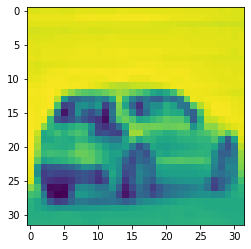

Class for this 1
[[2.2063480e-10 1.0000000e+00 6.6041472e-14 3.5760719e-12 3.9276270e-13
  1.1313486e-13 8.8119643e-13 6.8588521e-13 1.9681285e-13 3.7839783e-08]]


In [0]:
plt.imshow(population[0].reshape(CIFAR_IMG,CIFAR_IMG))
plt.show()
print(f"Class for this {adversarial_y[15][0]}")
print(model.predict(population[0].reshape(1,CIFAR_IMG,CIFAR_IMG,1) /255.0))

In [0]:
parent1 = tournament(population, model, adversarial[15], adversarial_y[15]) 
parent2 = tournament(population, model, adversarial[15], adversarial_y[15])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


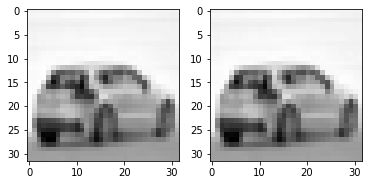

In [0]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(parent1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(parent2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")

In [0]:
child1, child2 = multi_crossover(parent1, parent2,adversarial[15]) # crossover 
#child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


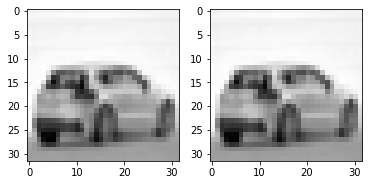

In [0]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(child1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(child2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")


In [0]:
print(f"diff between children {np.unique(child1-child2)}")
print(f"diff between parents {np.unique(parent1-parent2)}")
print(f"diff between p1 and c1 {np.unique(parent1-child1)}")
print(f"diff between p1 and c2 {np.unique(parent1-child2)}")
print(f"diff between p2 and c1 {np.unique(parent2-child1)}")
print(f"diff between p2 and c2 {np.unique(parent2-child2)}")

In [0]:
bb = choose_better_child(child1, child2,adversarial[15],adversarial_y[15][0],model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


In [0]:
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
print(fitness)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


[-0.26002962878595726, -0.25999958545736684, -0.26007314251448344, -0.26004007622401076, -0.26003266487525345, -0.26011373574731095, -0.2599816460817825, -0.25998496480763594, -0.2600353571926644, -0.2600021864303609, -0.260040721413234, -0.2600228430135187, -0.26003768485830203, -0.26002701209750284, -0.26006302743228543, -0.2599796432991168, -0.2600043346069123, -0.26003024147792836, -0.2600466627237271, -0.26003812318804226, -0.2600652442884724, -0.2600447098702882, -0.2600085762943468, -0.26001327339828323, -0.2599806557454484, -0.26007237070197037, -0.25996000471207786, -0.2600457997287944, -0.2600101441535663, -0.26005323947618036, -0.2600554130353725, -0.2600860828123626, -0.26003997918862914, -0.26004537198733424, -0.2600515291553301, -0.2600503663988854, -0.26001231736237695, -0.2600170667581806, -0.2600851316879575, -0.2599960477747653, -0.260017809873727, -0.2600171997460062, -0.2600455137861651, -0.26001145913341955, -0.2600466317811507, -0.2600557191632309, -0.260061281083